In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import ticker, container
from hera_cal import io, delay_filter, utils
import hera_qm
from tqdm.notebook import tqdm
from pyuvdata import UVFlag
import scipy
import warnings
import pickle
import copy
import hera_pspec
import simpleqe as sqe
import matplotlib.gridspec as gridspec
import pandas as pd
from IPython.core.display import display, HTML
from scipy import special
from matplotlib.ticker import FuncFormatter
import h5py
import astropy

/users/jsdillon/lustre/tmp/ipykernel_24177/2247296263.py:18: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Array, Antenna Flagging, and Epochs Plots

In [2]:
nights = {}
flagged_nights = {}
total_ants_per_night = {}
flagged_ants_per_night = {}

yaml_files = sorted(glob.glob('/lustre/aoc/projects/hera/H1C_IDR3/IDR3_2/h1c_idr3_software/hera_pipelines/pipelines/h1c/idr3/v2/a_priori_flags/*.yaml'))

for yaml in tqdm(yaml_files):
    ant_flags = set(hera_qm.metrics_io.read_a_priori_ant_flags(yaml))
    JD = int(yaml.split('/')[-1].split('.')[0])
    auto_files = sorted(glob.glob(f'/lustre/aoc/projects/hera/H1C_IDR3/IDR3_2/{JD}/*autos.uvh5'))
    if len(auto_files) > 0:
        hd = io.HERAData(auto_files[-1])
        total_ants_per_night[JD] = len(hd.data_ants)
        flagged_ants_per_night[JD] = len([ant for ant in hd.data_ants if ant in ant_flags])
        for ant in hd.data_ants:
            if ant not in nights:
                nights[ant] = []
                flagged_nights[ant] = []
            nights[ant].append(JD)
            if ant in ant_flags:
                flagged_nights[ant].append(JD)


  0%|          | 0/107 [00:00<?, ?it/s]

In [3]:
def draw_pie(dist, xpos, ypos, size, ax):
    # for incremental pie slices
    cumsum = np.cumsum(dist)
    cumsum = cumsum/ cumsum[-1]
    pie = [0] + cumsum.tolist()

    if np.all(np.array(dist)[1:] == 0):
        ax.scatter([xpos], [ypos], marker='o', s=size, c='paleturquoise', ec='none')
    elif np.all(dist[0] == 0 and dist[2] == 0):
        ax.scatter([xpos], [ypos], marker='o', s=size, c='lightcoral', ec='none')
    else:
        for i, r1, r2, c in zip(range(len(pie)-1), pie[:-1], pie[1:], ['paleturquoise', 'lightcoral', 'w']):
            try:
                if pie[i] == pie[i+1]:
                    continue
            except:
                pass
            angles = np.linspace(2 * np.pi * r1, 2 * np.pi * r2)
            x = [0] + (np.sin(angles)).tolist()
            y = [0] + (np.cos(angles)).tolist()
            xy = np.column_stack([x, y])
            ax.scatter([xpos], [ypos], marker=xy, s=size, c=c, ec='none')
    ax.scatter([xpos], [ypos], marker='o', s=size, c='none', ec='grey')        

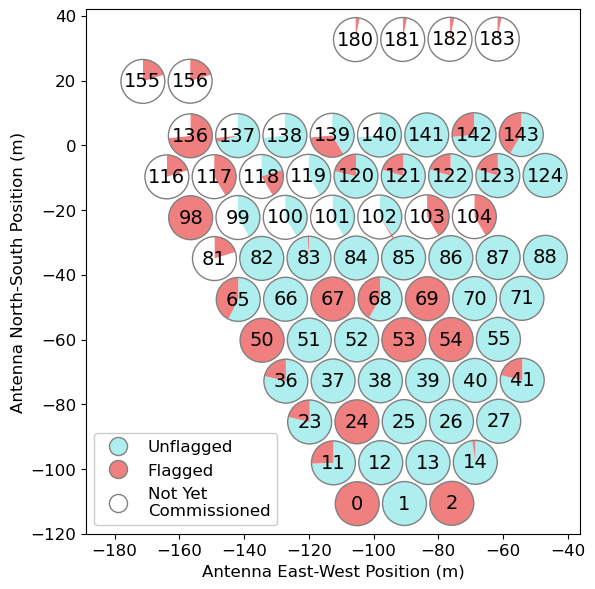

In [4]:
max_nights = np.max([len(nights[ant]) for ant in nights])

fig, ax = plt.subplots(figsize=(6,6), dpi=100)
for ant in nights:
    if ant > 200:
        continue
    pos = hd.antpos[ant]
    draw_pie([len(nights[ant]) - len(flagged_nights[ant]), len(flagged_nights[ant]), max_nights - len(nights[ant])], pos[0], pos[1], 1000, ax)
    
    plt.text(pos[0],pos[1],str(ant), va='center', ha='center', color='k', size=14)
    
    
legend_objs = []
legend_labels = []
legend_objs.append(matplotlib.lines.Line2D([0], [0], marker='o', color='w', markeredgecolor='grey', markerfacecolor='paleturquoise', markersize=13))
legend_labels.append(f'Unflagged')
legend_objs.append(matplotlib.lines.Line2D([0], [0], marker='o', color='w', markeredgecolor='grey', markerfacecolor='lightcoral', markersize=13))
legend_labels.append(f'Flagged')
legend_objs.append(matplotlib.lines.Line2D([0], [0], marker='o', color='w', markeredgecolor='grey', markerfacecolor='w', markersize=13))
legend_labels.append(f'Not Yet\nCommissioned')

plt.legend(legend_objs, legend_labels, ncol=1, fontsize=12, framealpha=1, loc='lower left')


plt.axis('equal')
plt.ylim([-120, 42])
plt.xlim([-180, -45])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Antenna East-West Position (m)', fontsize=12)
plt.ylabel('Antenna North-South Position (m)', fontsize=12)
plt.tight_layout()
plt.savefig('Array_Layout_And_Flagging.pdf', bbox_inches='tight')

In [5]:
print(np.linalg.norm(hd.antpos[137] - hd.antpos[14]))
print(np.linalg.norm(hd.antpos[137] - hd.antpos[1]))

124.82204086264404
124.8204958098962


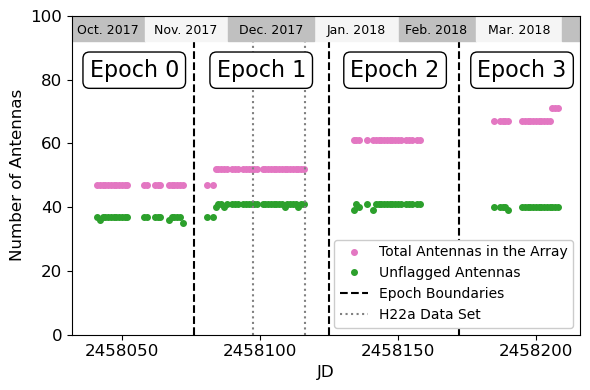

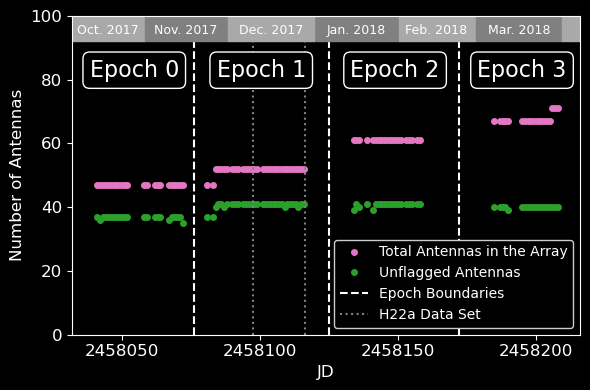

In [6]:
for n,style in enumerate(['default','dark_background']):
    with plt.style.context(style):

        fig, ax = plt.subplots(figsize=(6,4), dpi=100)
        JDs = sorted(list(total_ants_per_night.keys()))
        nAnts = [total_ants_per_night[JD] for JD in JDs]
        nUnflagged = [total_ants_per_night[JD] - flagged_ants_per_night[JD] for JD in JDs]

        ax.plot(JDs, nAnts,'.', ms=8, color='C6', label='Total Antennas in the Array')
        ax.plot(JDs, nUnflagged,'.', ms=8, color='C2', label='Unflagged Antennas')
        ax.set_ylim([0, 100])
        ax.set_xlim([2458032, 2458216])
        ax.set_ylabel('Number of Antennas', fontsize=12)
        ax.set_xlabel('JD', fontsize=12)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        ax.set_xticks([2458050, 2458100, 2458150, 2458200], [2458050, 2458100, 2458150, 2458200])

        for i, epoch_boundary in enumerate([2458076, 2458125, 2458172]):
            ax.axvline(epoch_boundary, c=['k','w'][n], ls='--', label=('Epoch Boundaries' if i == 0 else None))

        ax.axvline(2458097.5, c='grey', ls=':', label='H22a Data Set')    
        ax.axvline(2458116.5, c='grey', ls=':')    

        for i, epoch_center in enumerate([2458054.5, 2458100.5, 2458149, 2458195]):
            ax.text(epoch_center, 83, f'Epoch {i}', ha='center', va='center', fontsize=16, bbox={'ec': ['k','w'][n], 'fc': ['w','k'][n], 'boxstyle': 'round'})


        jd_span = np.arange(2458032, 2458216+1)
        months = np.array([t.month for t in astropy.time.Time(jd_span, format='jd').to_datetime()])
        for i in range(1, 13):
            try:
                ax.axvspan(jd_span[np.min(np.argwhere(months == i))]-.5, jd_span[np.max(np.argwhere(months == i))]+.5, .92, 1, 
                           color=[['silver','darkgrey'][n], ['whitesmoke','grey'][n]][i%2], zorder=2)
                month_names = ["Jan. 2018", 'Feb. 2018', 'Mar. 2018', '', '', '', '', '', '', 'Oct. 2017', 'Nov. 2017', 'Dec. 2017']
                ax.text(jd_span[int(np.median(np.argwhere(months == i)))], 95.5, month_names[i - 1], ha='center', va='center', zorder=3, fontsize=9)
            except:
                pass

        ax.legend(framealpha=1, loc='lower right')
        plt.tight_layout()
        plt.savefig(f'Antennas_And_Epochs{"_dark" if n==1 else ""}.pdf', bbox_inches='tight')

In [7]:
print(np.min(nAnts), np.max(nAnts))
print(np.min(nUnflagged), np.max(nUnflagged))

47 71
35 41


# Flagging Waterfalls, Occupancy, and Bands

In [8]:
spw_ranges = [[176, 340], [535, 697]] # these can be found in the pspec histories
hand_flag_files = glob.glob('/lustre/aoc/projects/hera/H1C_IDR3/IDR3_2/LSTBIN/all_epochs/*hand_flags.h5')
hand_flag_files = sorted(hand_flag_files, key=lambda f: np.mean(UVFlag(f).time_array))
uvf = UVFlag(hand_flag_files)
lsts = np.unwrap(uvf.lst_array) * 12 / np.pi
while np.max(lsts) > 24:
    lsts -= 24
freqs = uvf.freq_array / 1e6

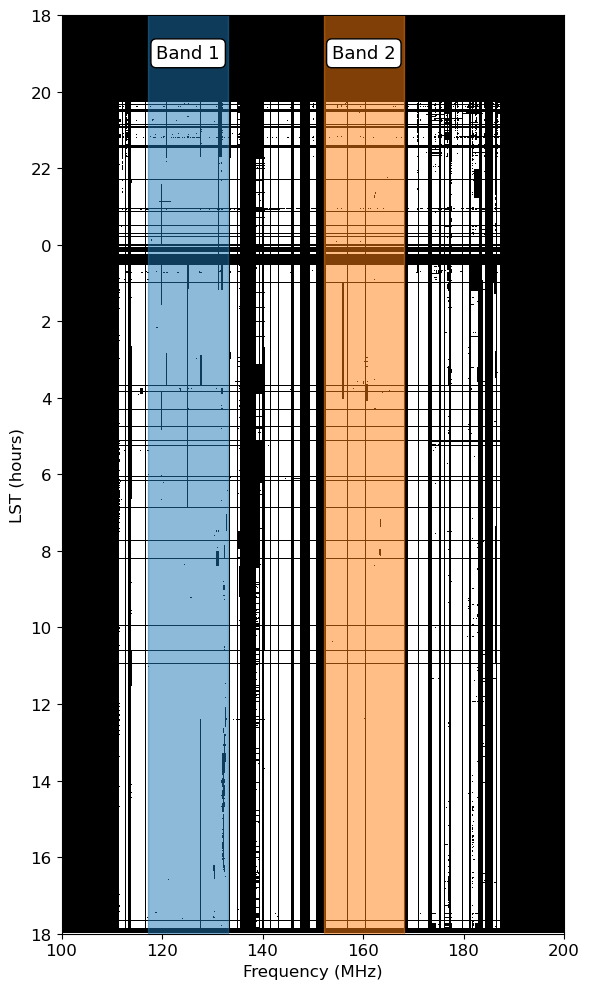

In [9]:
plt.figure(figsize=(6,10), dpi=100)
plt.imshow(uvf.flag_array.squeeze(), aspect='auto', interpolation='none', cmap='binary',
           extent=[freqs[0], freqs[-1], lsts[-1], lsts[0]])

for band, spwr, color in zip([1, 2], spw_ranges, ['C0', 'C1']):
    plt.axvspan(freqs[spwr[0]], freqs[spwr[1]], color=color, alpha=.5)
    plt.text(np.mean([freqs[spwr[0]], freqs[spwr[1]]]), -5, f'Band {band}', 
             bbox=dict(facecolor='w', alpha=1, boxstyle='round'), va='center', ha='center', fontsize=13)

plt.yticks(ticks=np.arange(-6, 20, 2), labels=(np.arange(-6, 20, 2) % 24));
plt.xticks(np.linspace(100, 200, 6))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Frequency (MHz)', fontsize=12)
plt.ylabel('LST (hours)', fontsize=12)
plt.tight_layout()
plt.savefig(f'flag_waterfall.pdf', bbox_inches='tight')

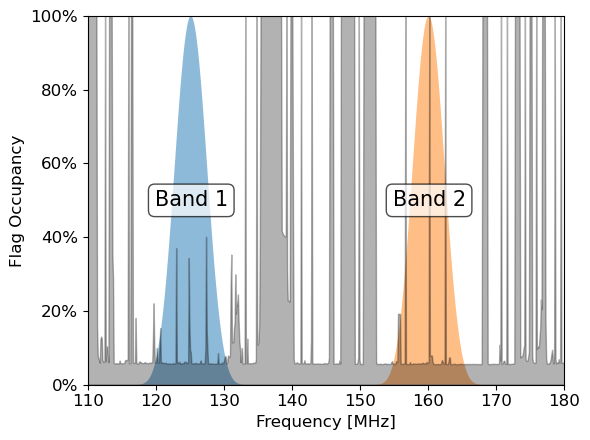

In [10]:
plt.figure(figsize=(6,4.5), dpi=100)
unflagged_time_inds = np.arange(uvf.flag_array.shape[0])[~np.all(uvf.flag_array.squeeze(), axis=1)]
flag_time_subset = uvf.flag_array[np.min(unflagged_time_inds):(np.max(unflagged_time_inds) + 1), :, 0]

for band, spwr, color in zip([1, 2], spw_ranges, ['C0', 'C1']):
    bh = 100 * scipy.signal.blackmanharris(spwr[1]-spwr[0])
    plt.fill_between(freqs[spwr[0]:spwr[1]], bh,  alpha=.5)
    plt.text(np.mean([freqs[spwr[0]], freqs[spwr[1]]]), 50, f'Band {band}', 
             bbox=dict(facecolor='w', alpha=.7, boxstyle='round'), va='center', ha='center', fontsize=15)
    

plt.fill_between(freqs, 100 * np.mean(flag_time_subset, axis=0), alpha=.3, color='k', edgecolor='k', linewidth=1)
plt.ylabel('Flag Occupancy', fontsize=12)
plt.xlabel('Frequency [MHz]', fontsize=12)
plt.xlim([110, 180])
plt.ylim([0, 100])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

import matplotlib.ticker as mtick

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.tight_layout()

plt.savefig(f'flag_occupancy_with_bands.pdf', bbox_inches='tight')

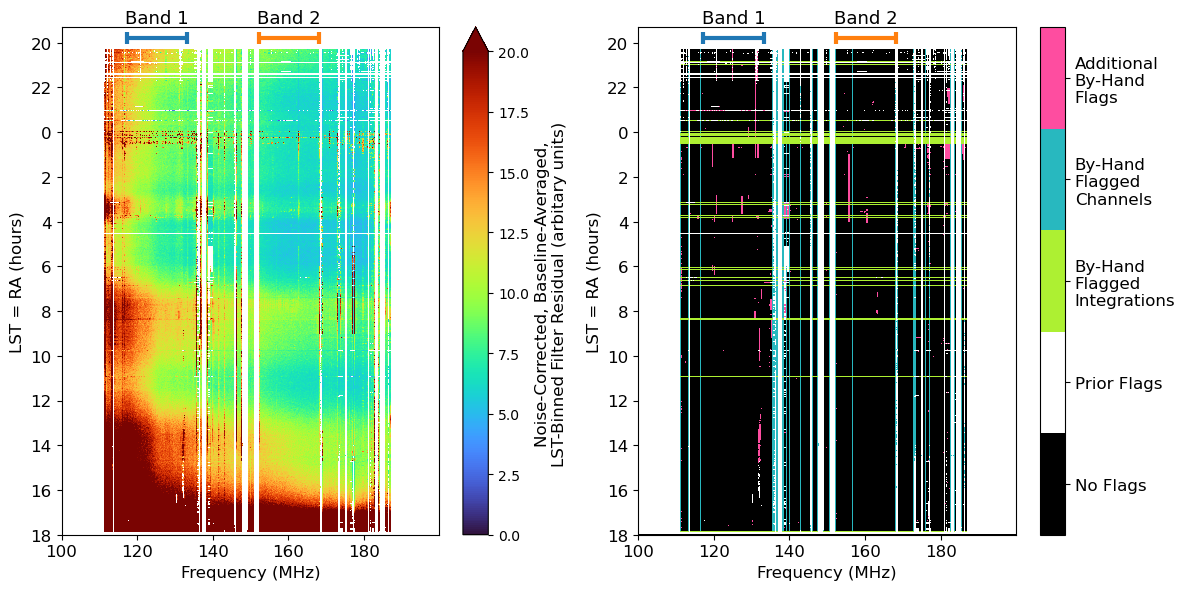

In [11]:
hand_flag_npz = np.load('hand_flag_summary.npz')
waterfall = hand_flag_npz['waterfall']
flag_origins = hand_flag_npz['flag_origins']
freqs = hand_flag_npz['freqs']
lsts = hand_flag_npz['lsts']

cmap = plt.cm.colors.ListedColormap(['k', 'w', '#adf032', '#28b8bf', '#fe4da0'])
norm = plt.cm.colors.Normalize(vmin=0, vmax=4)
smap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)


fig, axes = plt.subplots(1,2, figsize=(12,6), dpi=100)# sharey=False, gridspec_kw={'hspace': 0})
extent = [freqs[0]/1e6, freqs[-1]/1e6, lsts[-1], lsts[0]]

im = axes[0].imshow(np.where(waterfall==0, np.nan, waterfall), aspect='auto', cmap='turbo', interpolation='none', extent=extent, vmin=0, vmax=20)

cbar = plt.colorbar(im, ax=axes[0], extend='max',)
cbar.set_label('Noise-Corrected, Baseline-Averaged,\nLST-Binned Filter Residual (arbitary units)', fontsize=12)


im = axes[1].imshow(flag_origins,  aspect='auto', cmap=cmap, interpolation='none', extent=extent, vmin=0, vmax=4)
cbar = plt.colorbar(smap, ax=axes[1])
cbar.set_ticks(np.linspace(4/10, 36/10, 5))
cbar.set_ticklabels(['No Flags',
                     'Prior Flags',
                     'By-Hand\nFlagged\nIntegrations',
                     'By-Hand\nFlagged\nChannels',
                     'Additional\nBy-Hand\nFlags'])
cbar.ax.tick_params(labelsize=12)
axes[1].set_facecolor("k")

spw_ranges = [[176, 340], [535, 697]] # these can be found in the pspec histories

for band, spwr in enumerate(spw_ranges):
    for ax in axes:
        ax.text(np.mean([freqs[spwr[0]] / 1e6, freqs[spwr[1]] / 1e6]), -5.1, f'Band {band + 1}', 
                va='center', ha='center', fontsize=13)


for ax in axes:
    ax.set_xlabel('Frequency (MHz)', fontsize=12)    
    ax.set_yticks(np.arange(-6, 20, 2))
    ax.set_ylim([18, -4.7])        
    ax.set_yticklabels(np.arange(-6, 20, 2) % 24)
    ax.set_ylabel('LST = RA (hours)', fontsize=12)
    ax.set_xticks(np.linspace(100, 200, 6))
    ax.tick_params(labelsize=12)
    
    ax.errorbar((hd.freqs[spw_ranges[0][0]] + hd.freqs[spw_ranges[0][1]]) / 2e6, -4.2, c='C0', elinewidth=3,
                xerr=(hd.freqs[spw_ranges[0][0]] - hd.freqs[spw_ranges[0][1]]) / 2e6, capsize=4, markeredgewidth=3)
    ax.errorbar((hd.freqs[spw_ranges[1][0]] + hd.freqs[spw_ranges[1][1]]) / 2e6, -4.2, c='C1', elinewidth=3,
                xerr=(hd.freqs[spw_ranges[1][0]] - hd.freqs[spw_ranges[1][1]]) / 2e6, capsize=4, markeredgewidth=3)    

plt.tight_layout()
plt.savefig(f'hand_flag_origins.png', dpi=300, bbox_inches='tight')

# Cross-Talk Plots

In [12]:
# load data that's been LST-binned for all four epochs without any cross-talk removal
bl_to_plot = (11, 66, 'nn')
spw = 0
all_epochs_files = [hf.replace('.hand_flags.h5', '.uvh5') for hf in hand_flag_files]
warnings.filterwarnings("ignore", message="antenna_diameters is not set. Using known values for HERA.")
hd_all = io.HERAData(all_epochs_files)
hd_all.read(bls=[bl_to_plot], axis='blt');

# inpaint out to 4000 ns
F_all = delay_filter.DelayFilter(hd_all)
F_all.vis_clean(data=F_all.data, flags=F_all.flags, ax='freq', horizon=1.0, standoff=50.0, min_dly=4000.0, 
                window='tukey', alpha=.15, edgecut_low=100, edgecut_hi=150, tol=1.0e-05, skip_wgt=.2, maxiter=100,
                gain=.9, overwrite=True, verbose=False, output_prefix='clean', add_clean_residual=False, zeropad=256)
# FFT
F_all.fft_data(data=F_all.clean_data, assign='dfft0', ax='freq', window='bh', edgecut_low=100, edgecut_hi=624, overwrite=True)
F_all.fft_data(data=F_all.clean_data, assign='dfft1', ax='freq', window='bh', edgecut_low=400, edgecut_hi=150, overwrite=True)

# handle phase wraps in LST
lsts = np.unwrap(F_all.lsts)*12/np.pi
while np.max(lsts) > 24:
    lsts -= 24

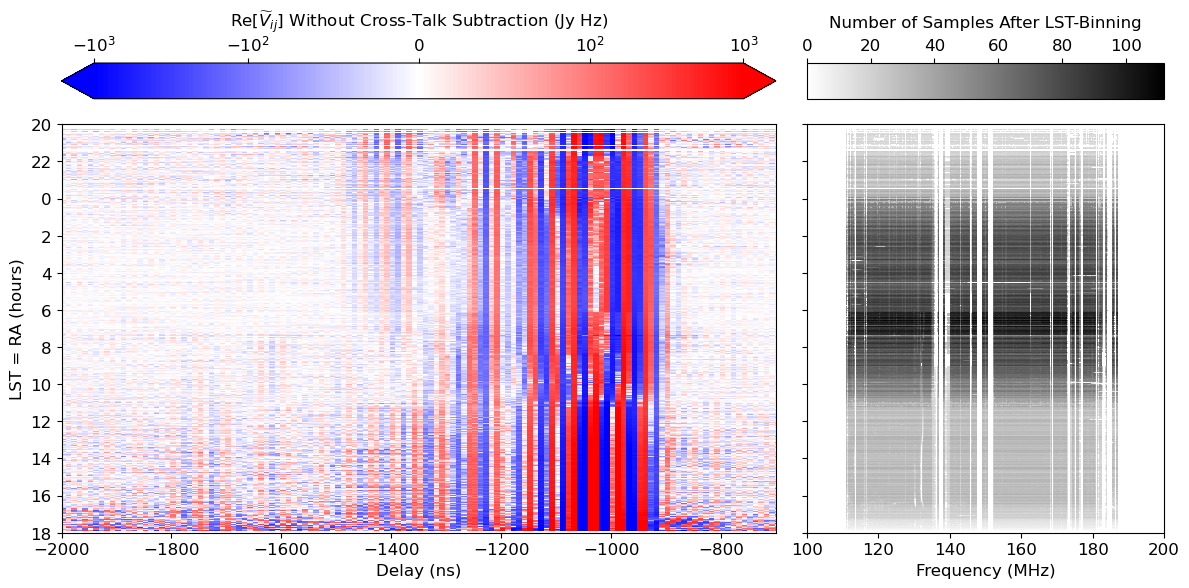

In [13]:
fig, axes = plt.subplots(1,2, figsize=(12,6), dpi=100, sharey=True, gridspec_kw={'hspace': 0, 'width_ratios': [2, 1]})
im = axes[0].imshow(np.where(np.all(F_all.flags[bl_to_plot], axis=1, keepdims=True), np.nan, 
                             np.real([F_all.dfft0[bl_to_plot], F_all.dfft1[bl_to_plot]][spw])), 
                    aspect='auto', cmap='bwr', norm=matplotlib.colors.SymLogNorm(100, vmax=1e3, vmin=-1e3),
                    interpolation='none', extent=[F_all.delays[0], F_all.delays[-1], lsts[-1], lsts[0]])
axes[0].set_xlabel('Delay (ns)', fontsize=12)
axes[0].set_xlim([-2000, -700])
cbar = plt.colorbar(im, ax=axes[0], location='top', extend='both')
cbar.set_label(r'Re[$\widetilde{V}_{ij}$] Without Cross-Talk Subtraction (Jy Hz)', fontsize=12)#, labelpad=12)
cbar.ax.tick_params(labelsize=12)

im = axes[1].imshow(F_all.nsamples[bl_to_plot] * ~F_all.flags[bl_to_plot], cmap='binary', aspect='auto', interpolation='none',
                    extent=[F_all.freqs[0] / 1e6, F_all.freqs[-1] / 1e6, lsts[-1], lsts[0]])
axes[1].set_xlim([100,200])
axes[1].set_xlabel('Frequency (MHz)', fontsize=12)
cbar = plt.colorbar(im, ax=axes[1], aspect=10, location='top')
cbar.set_label('Number of Samples After LST-Binning', fontsize=12, labelpad=8)
cbar.ax.tick_params(labelsize=12)#, direction='out', size=4)

for ax in axes:
    ax.set_yticks(np.arange(-6, 20, 2))
    ax.set_ylim([18, -4])            
    ax.tick_params(labelsize=12)
axes[0].set_yticklabels(np.arange(-6, 20, 2) % 24)
axes[0].set_ylabel('LST = RA (hours)', fontsize=12)


plt.tight_layout()
plt.savefig(f'crosstalk_discontinuities.png', dpi=300, bbox_inches='tight')

In [14]:
import pickle
with open('xtalk_model.p', 'rb') as f:
    xtalk_model = pickle.load(f)    
    
    
dlys = xtalk_model['dlys']
avg_spectra = xtalk_model['avg_spectra']
refant = xtalk_model['refant']
neg_dly_max = xtalk_model['neg_dly_max']
pos_dly_max = xtalk_model['pos_dly_max']
src_x, src_y, fit_tau = xtalk_model['dly_fit']
ants_with_unusual_cables = xtalk_model['ants_with_unusual_cables']
antpos = xtalk_model['antpos']
data_ants = xtalk_model['data_ants']
cable_delays = xtalk_model['cable_delays']
mean_dly_error = xtalk_model['mean_dly_error']
(amp_src_x, amp_src_y, power) = xtalk_model['amp_fit']
per_ant_amps = xtalk_model['per_ant_amps']
obs_amps = xtalk_model['obs_amps']
mean_amp_error = xtalk_model['mean_amp_error']

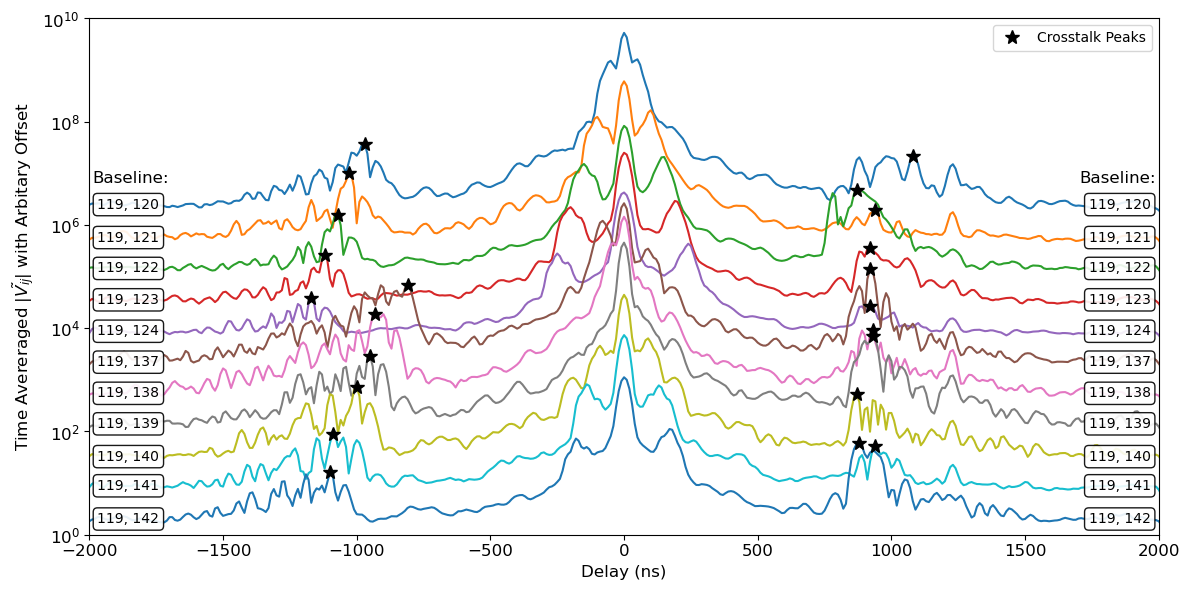

In [15]:
plt.figure(figsize=(12,6), dpi=100)
i = 1
for bl in avg_spectra:
    if (refant in bl) and (bl[0] != bl[1]) and np.all(np.isfinite(avg_spectra[bl])) and bl[2] == 'nn' and bl[1] >= refant and bl[0] >= refant:
        i /= 4
        avg_spectrum = i * avg_spectra[bl] * 8e5
        
        if bl == (119,120,'nn'):
            plt.text(-1990, np.min(avg_spectrum)*5, 'Baseline:', fontsize=12)
            plt.text(1990, np.min(avg_spectrum)*5, 'Baseline:', fontsize=12, ha='right')
        
        if bl[0] == refant:
            plt.semilogy(dlys, avg_spectrum)
            if np.isfinite(neg_dly_max[bl]):
                plt.plot(neg_dly_max[bl], avg_spectrum[dlys == neg_dly_max[bl]], 'k*', ms=10, zorder=10, label=('Crosstalk Peaks' if bl == (119,120,'nn') else None))
            if np.isfinite(pos_dly_max[bl]):
                plt.plot(pos_dly_max[bl], avg_spectrum[dlys == pos_dly_max[bl]], 'k*', ms=10, zorder=10)            

        plt.text(-1970, np.min(avg_spectrum)*1.6, f'{bl[0]}, {bl[1]}', bbox=dict(facecolor='w', alpha=.9, boxstyle='round'))
        plt.text(1970, np.min(avg_spectrum)*1.6, f'{bl[0]}, {bl[1]}', ha='right', bbox=dict(facecolor='w', alpha=.9, boxstyle='round'))

plt.gca().tick_params(labelsize=12)
plt.legend()
plt.xlim([-2000, 2000])
plt.ylim([1e0, 1e10])
plt.xlabel('Delay (ns)', fontsize=12)
plt.ylabel('Time Avereraged $|\\tilde{V_{ij}}|$ with Arbitary Offset', fontsize=12)
# plt.title(f'Average Delay Spectra of All nn-Polarized Baselines Including Antenna {refant}')

plt.tight_layout()
plt.savefig('xtalk_offset_delay_spec.pdf', bbox_inches='tight')

mean error: 46.902658107937235
tau offset: 99.37529147871905


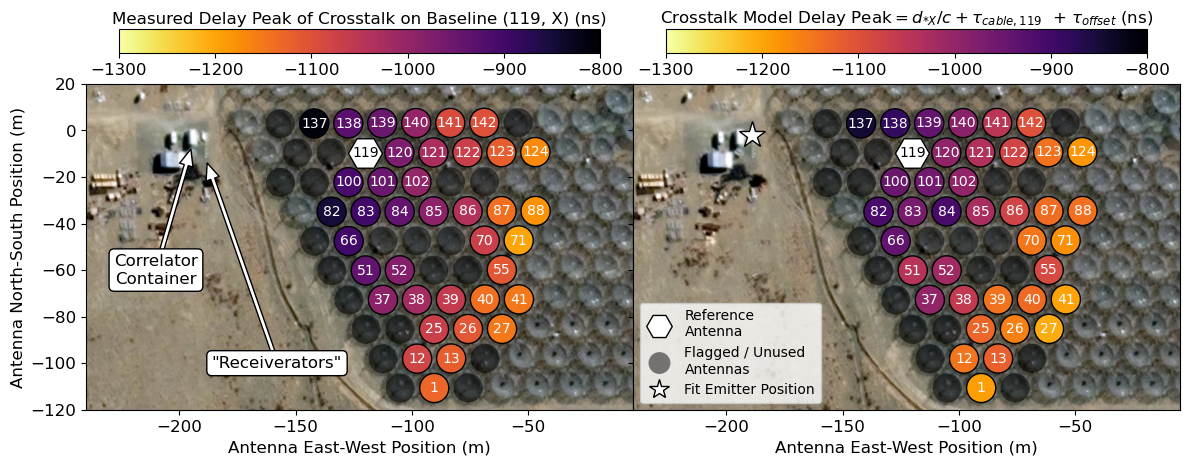

In [16]:
refpol = 'nn'
im = plt.imread('hera_google_maps.png')

fig, axes = plt.subplots(1,2, figsize=(12,5), dpi=100, sharey=True, gridspec_kw={'wspace': 0})

bottom_left = [-401.5, -177]
scale = .308 # m / pix


for i, ax in enumerate(axes):
    ax.imshow(np.flipud(im), extent=[bottom_left[0],  bottom_left[0]+2073*scale, bottom_left[1]+1214*scale, bottom_left[1]])

    bls = [bl for bl in neg_dly_max if (bl[2]==refpol) and refant in bl]
    bls = [bl for bl in bls if not np.any([ant in ants_with_unusual_cables for ant in utils.split_bl(bl)])]
    antnums = [ant for bl in bls for ant in bl[0:2] if ant != refant]
    other_ants = set([ant for ant in data_ants if ant not in antnums and ant != refant])
    xs = np.array([antpos[ant][0] for bl in bls for ant in bl[0:2] if ant != refant])
    ys = np.array([antpos[ant][1] for bl in bls for ant in bl[0:2] if ant != refant])

    obs_dlys = np.array([-neg_dly_max[bl] if bl[0] == refant else pos_dly_max[bl] for bl in bls])    
    model_times = np.sqrt((xs - src_x)**2 + (ys - src_y)**2) / scipy.constants.c * 1e9
    model_times += np.array([cable_delays[ant, ant, refpol] / 2 for ant in antnums]) + fit_tau

    if i == 0:
        scatter = ax.scatter(xs, ys, c=-obs_dlys, s=440, cmap='inferno_r',  edgecolors='k', vmax=-800, vmin=-1300)
        cbar = plt.colorbar(scatter, ax=ax, location='top', shrink=.88, pad=.07)
        cbar.set_label(f'Measured Delay Peak of Crosstalk on Baseline ({refant}, X) (ns)', fontsize=12)
#         ax.set_title(f"Negative Delay Crosstalk Peak in Baseline ({refant}, X)")
        ax.set_ylabel('Antenna North-South Position (m)', fontsize=12)        
    if i == 1:
        scatter = ax.scatter(xs, ys, c=-model_times, s=440, cmap='inferno_r',  edgecolors='k', vmax=-800, vmin=-1300)
        cbar = plt.colorbar(scatter, ax=ax, location='top', shrink=.88, pad=.07)
        cbar.set_label('Crosstalk Model Delay Peak' + '$ = d_{*X} / c + $' + '$\\tau_{{{}}}$  + '.format(f'cable,{refant}') + '$\\tau_{offset}$ (ns)', fontsize=12)

    cbar.ax.xaxis.set_ticks_position("bottom")
    cbar.ax.tick_params(labelsize=12) 
    
    for x, y, antnum in zip(xs, ys, antnums):
        ax.text(x, y, antnum,  c='w', va='center', ha='center', fontsize=10)
    ax.scatter([antpos[refant][0]], [antpos[refant][1]], marker='H', s=600, c='w', edgecolors='k', label='Reference\nAntenna')
    ax.text(antpos[refant][0], antpos[refant][1], refant, va='center', ha='center', fontsize=10)

    ax.scatter([antpos[ant][0] for ant in other_ants], [antpos[ant][1] for ant in other_ants], s=440, c='k', alpha=.5, ec='None', label='Flagged / Unused\nAntennas')


    ax.set_xlabel('Antenna East-West Position (m)', fontsize=12)
    
    ax.set_aspect('equal')
    ax.set_xlim([-240, -5])
    ax.set_ylim(-120, 20)    
    ax.tick_params(labelsize=12)

axes[1].plot([src_x], [src_y], '*', ms=20, c='w', mec='k', label='Fit Emitter Position')    
    
axes[0].annotate('', (-188, -14), (-158, -100), ha='center', va='center', fontsize=12, color='k', 
             arrowprops={'width': 3, 'headwidth': 10, 'ec': None, 'color': 'w'})   
axes[0].annotate('"Receiverators"', (-188, -14), (-158, -100), ha='center', va='center', fontsize=12, color='k', 
                 bbox=dict(facecolor='w', alpha=1, boxstyle='round'))

axes[0].annotate('', (-195, -8), (-210, -60), ha='center', va='center', fontsize=12, color='k', 
             arrowprops={'width': 3, 'headwidth': 10, 'ec': None, 'color': 'w'})   
axes[0].annotate('Correlator\nContainer', (-195, -8), (-210, -60), ha='center', va='center', fontsize=12, color='k', 
                 bbox=dict(facecolor='w', alpha=1, boxstyle='round'))


leg = axes[1].legend(loc='lower left', markerscale=.75)    
print('mean error:', mean_dly_error)
print('tau offset:', fit_tau)
plt.tight_layout()
plt.savefig('xtalk_dly_fit.pdf', bbox_inches='tight')

mean error: 1.177751707325305e-05


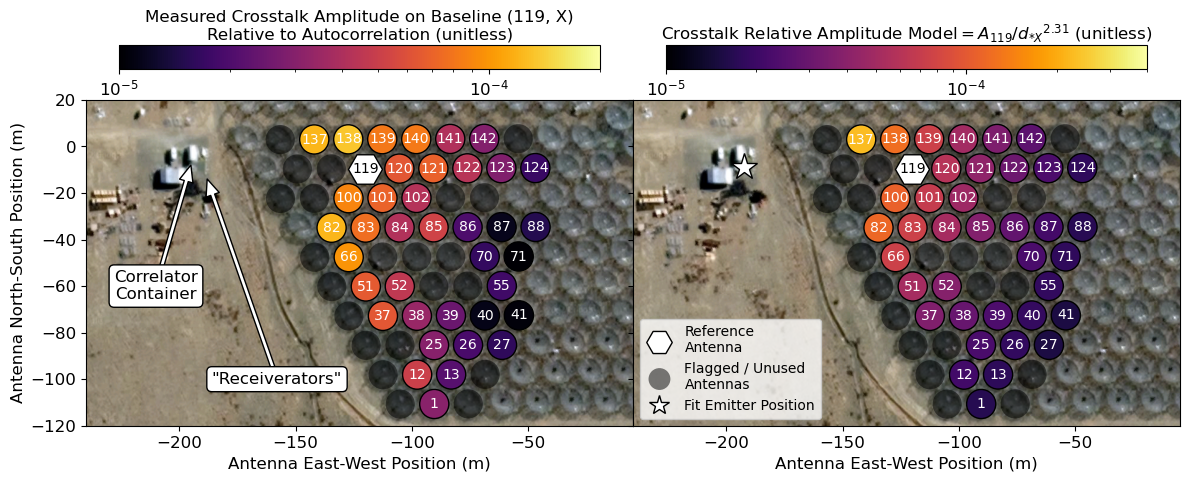

In [17]:
refpol = 'nn'
im = plt.imread('hera_google_maps.png')

fig, axes = plt.subplots(1,2, figsize=(12,5), dpi=100, sharey=True, gridspec_kw={'wspace': 0})

bottom_left = [-401.5, -177]
scale = .308 # m / pix

for i, ax in enumerate(axes):
    ax.imshow(np.flipud(im), extent=[bottom_left[0],  bottom_left[0]+2073*scale, bottom_left[1]+1214*scale, bottom_left[1]])

    bls = [bl for bl in neg_dly_max if (bl[2]==refpol) and refant in bl]
    bls = [bl for bl in bls if not np.any([ant in ants_with_unusual_cables for ant in utils.split_bl(bl)])]
    antnums = [ant for bl in bls for ant in bl[0:2] if ant != refant]
    other_ants = set([ant for ant in data_ants if ant not in antnums and ant != refant])
    xs = np.array([antpos[ant][0] for bl in bls for ant in bl[0:2] if ant != refant])
    ys = np.array([antpos[ant][1] for bl in bls for ant in bl[0:2] if ant != refant])

    model_amps = np.array([per_ant_amps[refant, utils.split_pol(refpol)[0]] for bl in bls])
    model_amps /= ((xs - src_x)**2 + (ys - src_y)**2)**(.5 * power)

    
    if i == 0:
        scatter = ax.scatter(xs, ys, c=obs_amps, s=440, cmap='inferno',  edgecolors='k',norm=matplotlib.colors.LogNorm(vmin=1e-5, vmax=2e-4, ))
        cbar = plt.colorbar(scatter, ax=ax, location='top', shrink=.88, pad=.07)
        cbar.set_label(f'Measured Crosstalk Amplitude on Baseline ({refant}, X)\nRelative to Autocorrelation (unitless)', fontsize=12)
        ax.set_ylabel('Antenna North-South Position (m)', fontsize=12)        
    if i == 1:
        scatter = ax.scatter(xs, ys, c=model_amps, s=440, cmap='inferno',  edgecolors='k',norm=matplotlib.colors.LogNorm(vmin=1e-5, vmax=4e-4, ))
        cbar = plt.colorbar(scatter, ax=ax, location='top', shrink=.88, pad=.07)
        
        cbar.set_label(f'Crosstalk Relative Amplitude Model' + f'$ = A_{{{refant}}}$' + '$/ d_{*X}$' + f'$^{{{power:.2f}}}$ (unitless)', fontsize=12)

    cbar.ax.xaxis.set_ticks_position("bottom")
    cbar.ax.tick_params(labelsize=12) 
    
    for x, y, antnum in zip(xs, ys, antnums):
        ax.text(x, y, antnum,  c='w', va='center', ha='center', fontsize=10)
    ax.scatter([antpos[refant][0]], [antpos[refant][1]], marker='H', s=600, c='w', edgecolors='k', label='Reference\nAntenna')
    ax.text(antpos[refant][0], antpos[refant][1], refant, va='center', ha='center', fontsize=10)

    ax.scatter([antpos[ant][0] for ant in other_ants], [antpos[ant][1] for ant in other_ants], s=440, c='k', alpha=.5, ec='None', label='Flagged / Unused\nAntennas')

    ax.set_xlabel('Antenna East-West Position (m)', fontsize=12)
    
    ax.set_aspect('equal')
    ax.set_xlim([-240, -5])
    ax.set_ylim(-120, 20)    
    ax.tick_params(labelsize=12)
    
    
axes[1].plot([amp_src_x], [amp_src_y], '*', ms=20, c='w', mec='k', label='Fit Emitter Position')    
    
axes[0].annotate('', (-188, -14), (-158, -100), ha='center', va='center', fontsize=12, color='k', 
             arrowprops={'width': 3, 'headwidth': 10, 'ec': None, 'color': 'w'})   
axes[0].annotate('"Receiverators"', (-188, -14), (-158, -100), ha='center', va='center', fontsize=12, color='k', 
                 bbox=dict(facecolor='w', alpha=1, boxstyle='round'))

axes[0].annotate('', (-195, -8), (-210, -60), ha='center', va='center', fontsize=12, color='k', 
             arrowprops={'width': 3, 'headwidth': 10, 'ec': None, 'color': 'w'})   
axes[0].annotate('Correlator\nContainer', (-195, -8), (-210, -60), ha='center', va='center', fontsize=12, color='k', 
                 bbox=dict(facecolor='w', alpha=1, boxstyle='round'))

    
    
leg = axes[1].legend(loc='lower left', markerscale=.75)
print('mean error:', mean_amp_error)
plt.tight_layout()
plt.savefig('xtalk_amp_fit.pdf', bbox_inches='tight')

# LST Coverage and Definition of Fields

In [18]:
# figure out the correct order of files, based on a split at 4.71 radians
def file_lst_for_sort(fn):
    lst = float(fn.split('.LST.')[-1].split('.sum.')[0]) - 4.71
    if lst < 0:
        lst += 2 * np.pi
    return lst
# figure out the correct order of files, based on a split at 4.71 radians
def file_lst_for_sort2(fn):
    lst = float(fn.split('.LST.')[-1].split('.HH.')[0]) - 4.71
    if lst < 0:
        lst += 2 * np.pi
    return lst


all_epochs_files = sorted(glob.glob('/lustre/aoc/projects/hera/H1C_IDR3/IDR3_2/LSTBIN/all_epochs_preprocessed/zen.grp1.of1.LST.*.sum.LPL.uvh5'), key=file_lst_for_sort)
idr2_files = sorted(glob.glob(f'/lustre/aoc/projects/hera/H1C_IDR2/IDR2_2/LSTBIN/one_group/grp1/zen.grp1.of1.LST.*.uvh5'), key=file_lst_for_sort2)

# load single baseline for all 
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    hd_idr2 = io.HERADataFastReader(idr2_files)
    data_idr2, flags_idr2, nsamples_idr2 = hd_idr2.read(bls=[(25,26,'ee')])#, axis='blt')    
    
    hd_idr3 = io.HERADataFastReader(all_epochs_files)
    data_idr3, flags_idr3, nsamples_idr3 = hd_idr3.read(bls=[(25,26,'ee')])#, axis='blt')

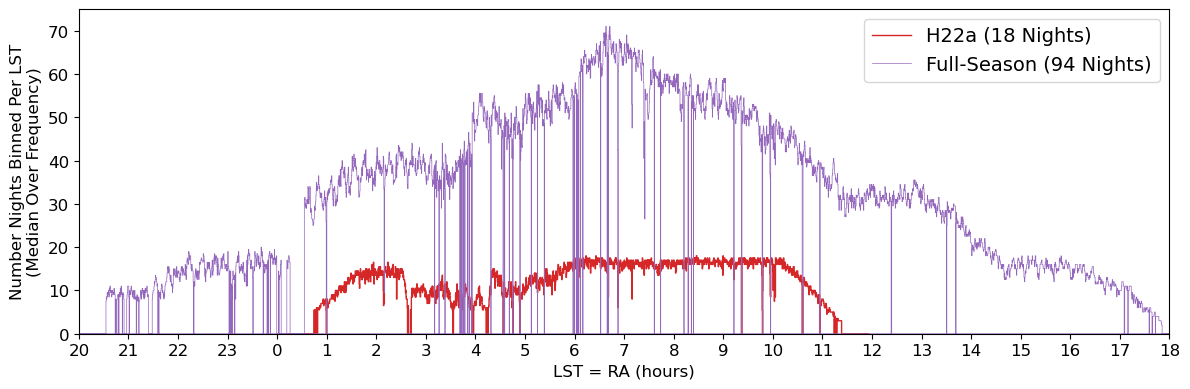

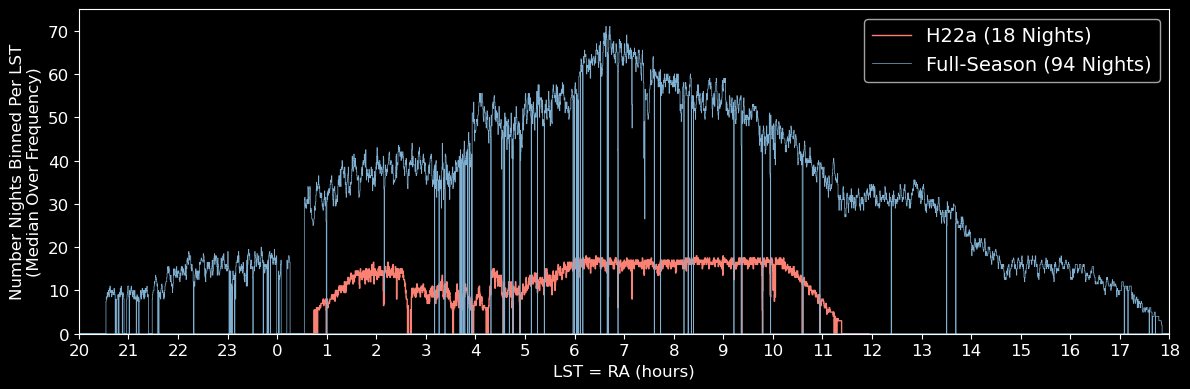

In [19]:
for n,style in enumerate(['default','dark_background']):
    with plt.style.context(style):
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        plt.figure(figsize=(12,4), dpi=100)
        bl = (25,26,'ee')
        nights_per_lst2 = np.nanmedian(np.where(np.all(nsamples_idr2[bl] == 0, axis=0)[np.newaxis, :], np.nan, nsamples_idr2[bl]) / 2, axis=1)
        nights_per_lst3 = np.nanmedian(np.where(np.all(nsamples_idr3[bl] == 0, axis=0)[np.newaxis, :], np.nan, nsamples_idr3[bl]) / 2, axis=1)

        plt.step(nsamples_idr2.lsts * 12 / np.pi, nights_per_lst2, lw=1, c=colors[3], label='H22a (18 Nights)')

        lsts_wrapped = nsamples_idr3.lsts * 12 / np.pi
        lsts_wrapped[lsts_wrapped > 18] = lsts_wrapped[lsts_wrapped > 18] - 24

        plt.step(lsts_wrapped, nights_per_lst3, lw=.5, c=colors[4], label='Full-Season (94 Nights)')

        plt.ylabel('Number Nights Binned Per LST\n(Median Over Frequency)', fontsize=12)
        plt.xlim([-4, 18])
        plt.ylim([0, 75])
        plt.xticks(np.arange(-4, 18.1, 1), labels=(np.arange(-4, 18.1, 1) % 24).astype(int), fontsize=12)
        plt.yticks(np.arange(0, np.max(nights_per_lst3), 10), fontsize=12)
        plt.xlabel('LST = RA (hours)', fontsize=12)
        plt.legend(fontsize=14)

        plt.tight_layout()
        plt.savefig(f'lst_coverage_comparison{("_dark" if n==1 else "")}.pdf', bbox_inches='tight')

In [20]:
fields_plot_npz = np.load('../All_Epochs_Power_Spectra/figures/fields_vs_noise_and_power_data.npz')
fields_plot_data = {k: np.where(fields_plot_npz[k] == 0, np.nan, fields_plot_npz[k]) for k in fields_plot_npz}

# LST ranges of fields
lstcuts = [(-2.5, 0), # Field A
           (0.75, 2.75), # Field B
           (4, 6.25), # Field C
           (6.25, 9.25), # Field D
           (9.25, 14.75),  # Field E
          ]
lst_colors = ['limegreen', 'gold', 'cyan', 'deeppink', 'mediumorchid', 'aquamarine']

Casting complex values to real discards the imaginary part


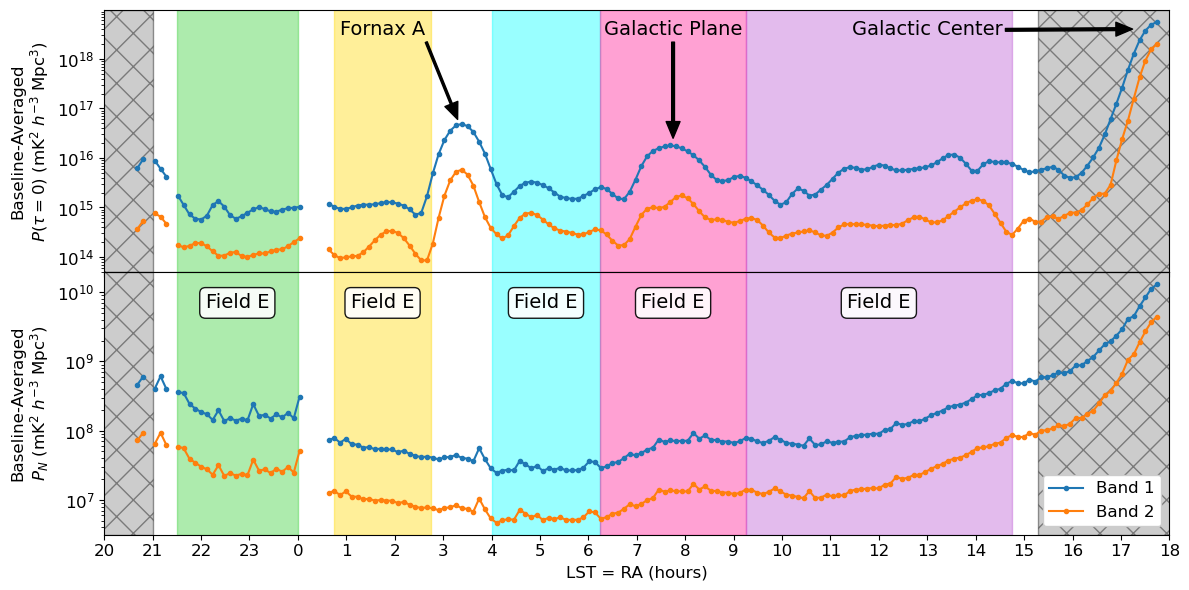

In [21]:
fig, axes = plt.subplots(2, 1, figsize=(12,6), sharex=True, gridspec_kw={'hspace': 0}, dpi=100)

axes[0].semilogy(fields_plot_data['lsts_wrapped'], fields_plot_data['bl_avg_pspec_tau0_b1'], '.-', label=f'Band 1')
axes[0].semilogy(fields_plot_data['lsts_wrapped'], fields_plot_data['bl_avg_pspec_tau0_b2'], '.-', label=f'Band 2')
axes[0].set_ylabel('Baseline-Averaged\n'+r'$P(\tau = 0)\ ({\rm mK}^2\ h^{-3}\ {\rm Mpc}^3)$', fontsize=12)

for field, (lc, c) in enumerate(zip(lstcuts, lst_colors)):
    axes[0].axvspan(lc[0], lc[1], color=c, alpha=.4)
    
axes[0].annotate('Fornax A', (3.3, 6e16), (1.75, 6e18), ha='center', va='top', fontsize=14,
                 arrowprops={'width': 1.5, 'headwidth': 10, 'ec': None, 'color': 'k'})
axes[0].annotate('Galactic Plane', (7.75, 2.5e16), (7.75, 6e18), ha='center', va='top', fontsize=14,
                 arrowprops={'width': 2, 'headwidth': 10, 'ec': None, 'color': 'k'})
axes[0].annotate('Galactic Center', (17.24, 4e18), (13, 6e18), ha='center', va='top', fontsize=14,
                 arrowprops={'width': 2, 'headwidth': 10, 'ec': None, 'color': 'k'})

axes[1].semilogy(fields_plot_data['lsts_wrapped'], fields_plot_data['bl_avg_noise_b1'], '.-', label=f'Band 1')
axes[1].semilogy(fields_plot_data['lsts_wrapped'], fields_plot_data['bl_avg_noise_b2'], '.-', label=f'Band 2')    
axes[1].set_ylabel('Baseline-Averaged\n'+r'$P_N\ ({\rm mK}^2\ h^{-3}\ {\rm Mpc}^3)$', fontsize=12)

for lc, c in zip(lstcuts, lst_colors):
    axes[1].axvspan(lc[0], lc[1], color=c, alpha=.4)    
    axes[1].text(np.mean(lc), 7e9, f'Field {"ABCDEFGHIJ"[field]}', ha='center', va='center', fontsize=14, bbox=dict(facecolor='w', alpha=0.9, boxstyle='round'))
axes[1].set_xlabel('LST = RA (hours)', fontsize=12)  

for ax in axes:
    ax.tick_params(axis='y', labelsize=12)
    ax.set_xticks(np.arange(-6, 20, 1), fontsize=12)
    ax.set_xlim([-4,18])
    poly = ax.axvspan(-6, 24 * 5.5/2/np.pi - 24, color='grey', alpha=.4)
    poly.set_hatch('X')
    poly.set_edgecolor('k')
    poly = ax.axvspan(24 * 4/2/np.pi, 19, color='grey',alpha=.4)    
    poly.set_hatch('X')    
    poly.set_edgecolor('k')
axes[1].set_xticklabels(np.arange(-6, 20, 1) % 24, fontsize=12)

axes[1].legend(loc='lower right', framealpha=1, fontsize=12)


plt.tight_layout()
plt.savefig('fields_vs_noise_and_power.pdf', bbox_inches='tight')

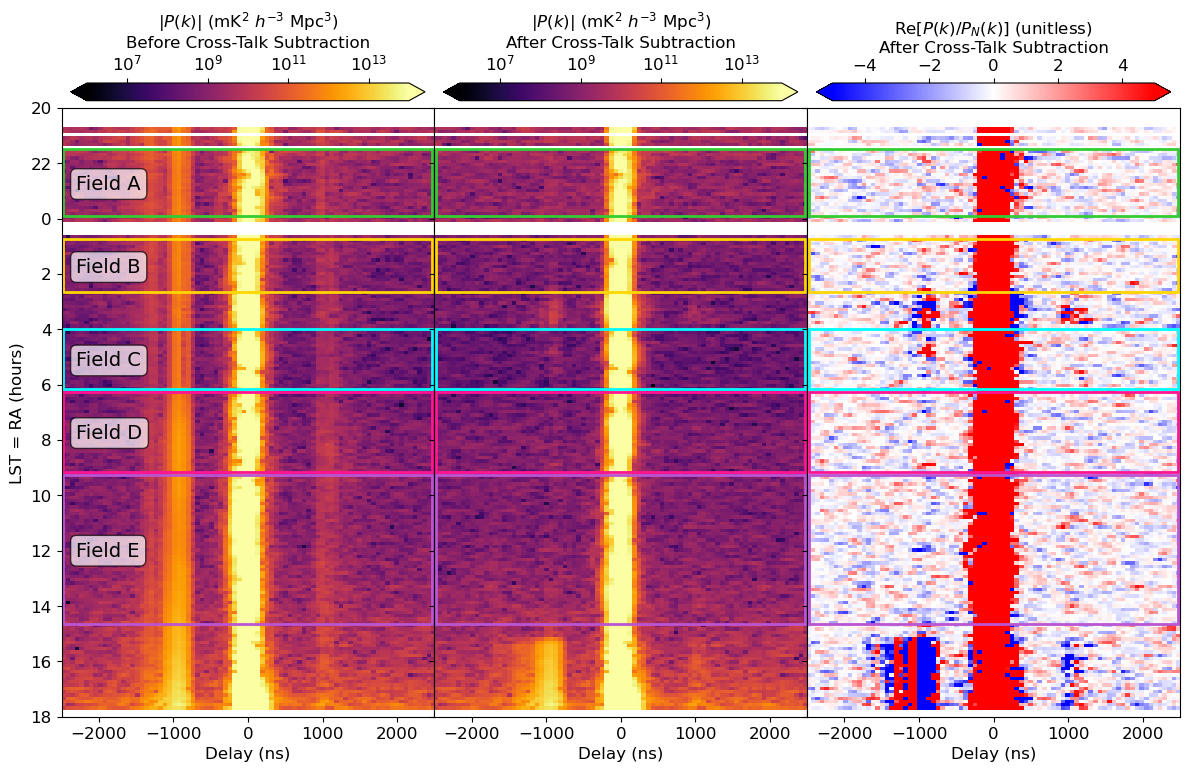

In [22]:
blp = ((38, 66), (52, 82))

spw = 0

uvp_xtk = hera_pspec.UVPSpec()
uvp_xtk.read_hdf5(f'../All_Epochs_Power_Spectra/figures/pspec_waterfall_{"_".join([str(ant) for bl in blp for ant in bl])}_xtk.hdf5')
uvp_tk = hera_pspec.UVPSpec()
uvp_tk.read_hdf5(f'../All_Epochs_Power_Spectra/figures/pspec_waterfall_{"_".join([str(ant) for bl in blp for ant in bl])}_tk.hdf5')


lst_indexes = np.unique(uvp_xtk.lst_1_array, return_index=True)[1]
lsts_wrapped = np.unwrap([uvp_xtk.lst_avg_array[i] for i in sorted(lst_indexes)]) * 12 / np.pi - 24
dlys = np.unique(uvp_xtk.dly_array)
extent = [dlys[0]*1e9, dlys[-1]*1e9, lsts_wrapped[-1], lsts_wrapped[0]]
key = (spw, blp, ('pI', 'pI'))

shrink=.95

fig, axes = plt.subplots(1,3, figsize=(12,8), dpi=100, sharey=True, gridspec_kw={'wspace': .0})

im = axes[0].imshow(np.where(~np.isfinite(uvp_tk.get_stats('P_N', key)), np.nan, np.abs(uvp_tk.get_data(key))), 
                               norm=matplotlib.colors.LogNorm(vmin=1e6, vmax=1e14), 
                               aspect='auto', interpolation='none', cmap='inferno', extent=extent)
cbar = plt.colorbar(im, ax=axes[0], location='top', extend='both', shrink=shrink, pad=.01)
cbar.set_label(r'$|P(k)|$ (${\rm mK}^2\ h^{-3}\ {\rm Mpc}^3$)' + '\nBefore Cross-Talk Subtraction', fontsize=12)#, labelpad=12)
cbar.ax.tick_params(labelsize=12)
axes[0].set_ylabel('LST = RA (hours)', fontsize=12)


im = axes[1].imshow(np.where(~np.isfinite(uvp_xtk.get_stats('P_N', key)), np.nan, np.abs(uvp_xtk.get_data(key))), 
                               norm=matplotlib.colors.LogNorm(vmin=1e6, vmax=1e14), 
                               aspect='auto', interpolation='none', cmap='inferno', extent=extent)
cbar = plt.colorbar(im, ax=axes[1], location='top', extend='both', shrink=shrink, pad=.01)
cbar.set_label(r'$|P(k)|$ (${\rm mK}^2\ h^{-3}\ {\rm Mpc}^3$)' + '\nAfter Cross-Talk Subtraction', fontsize=12)#, labelpad=12)
cbar.ax.tick_params(labelsize=12)


im = axes[2].imshow(np.real(uvp_xtk.get_data(key) / uvp_xtk.get_stats('P_N', key)),
                    aspect='auto', interpolation='none', extent=extent, cmap='bwr', vmin=-5, vmax=5)
cbar = plt.colorbar(im, ax=axes[2], location='top', extend='both', shrink=shrink, pad=.01)
cbar.set_label(label='Re$[P(k) / P_N(k)]$ (unitless)'+ '\nAfter Cross-Talk Subtraction', fontsize=12)
cbar.ax.tick_params(labelsize=12)

for ax in axes:
    ax.set_yticks(np.arange(-6, 20, 2))
    axes[0].set_yticklabels(np.arange(-6, 20, 2) % 24)
    ax.set_ylim(18, -4)
    ax.tick_params(labelsize=12)
    ax.set_xlabel('Delay (ns)', fontsize=12)
    ax.set_xlim([-2500, 2500])
    for i, lc in enumerate(lstcuts):
        r = plt.Rectangle((-2475, lc[0]), 4950, lc[1]-lc[0]-.1, fc='None', ec=lst_colors[i], lw=2)
        ax.add_patch(r)
        if ax == axes[0]:
            ax.text(-2300, np.mean(lc), f"Field {'ABCDEFGHIJ'[i]}", fontsize=14, 
                    bbox=dict(facecolor='w', alpha=0.7, boxstyle='round'), c='k', ha='left', va='center')

plt.tight_layout()
plt.savefig('power_spectrum_waterfall_with_xtalk_subtraction.png', dpi=300, bbox_inches='tight')

In [23]:
import pickle
with open('../All_Epochs_Power_Spectra/figures/crosstalk_flagging_plot_variables.p', 'rb') as f:
    xtalk_vars = pickle.load(f)    
    
flag_neg_delays = xtalk_vars['flag_neg_delays']
flag_pos_delays = xtalk_vars['flag_pos_delays']
flag_all_delays = xtalk_vars['flag_all_delays']
xtalk_dly_min = xtalk_vars['xtalk_dly_min']
xtalk_dly_max = xtalk_vars['xtalk_dly_max']
high_dly_diff = xtalk_vars['high_dly_diff']
auto_xtalk_snrs = xtalk_vars['auto_xtalk_snrs']
auto_high_dly_snrs = xtalk_vars['auto_high_dly_snrs']
auto_xtalk_snr_cut = xtalk_vars['auto_xtalk_snr_cut']    

Band 1 Negative Delays:
3.5% of auto-baseline pairs flagged
(corresponding to 8.9% of 
cross-baseline pairs flagged)
Band 1 Positive Delays:
1.0% of auto-baseline pairs flagged
(corresponding to 3.9% of 
cross-baseline pairs flagged)
Band 2 Negative Delays:
3.8% of auto-baseline pairs flagged
(corresponding to 6.5% of 
cross-baseline pairs flagged)
Band 2 Positive Delays:
0.9% of auto-baseline pairs flagged
(corresponding to 3.0% of 
cross-baseline pairs flagged)


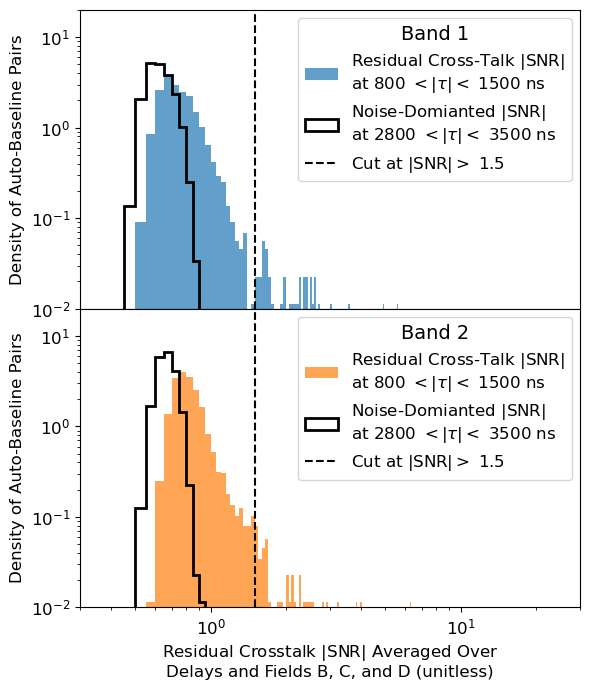

In [24]:
fig, axes = plt.subplots(2, 1, figsize=(6,7), dpi=100, gridspec_kw={'hspace': 0})

# for axis, fname in zip(axes, ['neg', 'pos']):

for spw, ax in enumerate(axes):
    
    for fname in ['neg', 'pos']:        
        flag_delays = [flag_neg_delays, flag_pos_delays][fname == 'pos']
        auto_flags_here = [flag_delays[k] for k in flag_delays if (k[0] == spw) and (k[1][0] == k[1][1])]
        cross_flags_here = [flag_delays[k] for k in flag_delays if (k[0] == spw) and (k[1][0] != k[1][1])]

        title = f'Band {spw + 1} {["Negative", "Positive"][fname == "pos"]} Delays:\n'
        title += f'{100 * np.sum(auto_flags_here) / len(auto_flags_here):.1f}% of auto-baseline pairs flagged\n'
        title += f'(corresponding to {100 * np.sum(cross_flags_here) / len(cross_flags_here):.1f}% of \ncross-baseline pairs flagged)'
        print(title)

        

    label = f'Band {spw+1} Flags:\n'

    label1 = f'Residual Cross-Talk $|$SNR$|$\nat {xtalk_dly_min} ' + '$<|\\tau| <$' + f' {xtalk_dly_max} ns'
    label2 = f'Noise-Domianted $|$SNR$|$\nat {xtalk_dly_min + high_dly_diff} ' + '$<|\\tau| <$' + f' {xtalk_dly_max + high_dly_diff} ns'


    ax.hist(np.append(auto_xtalk_snrs['neg'][spw], auto_xtalk_snrs['pos'][spw]),
            bins=np.arange(.4,10,.05), density=True, alpha=.7, color=['C0', 'C1'][spw], label=label1)        
    ax.hist(np.append(auto_high_dly_snrs['neg'][spw], auto_high_dly_snrs['pos'][spw]),
            bins=np.arange(.4,10,.05), density=True, histtype='step', lw=2, color='k', label=label2)

    ax.set_ylabel('Density of Auto-Baseline Pairs', fontsize=12)
    

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim([.3, 30])
    ax.set_ylim([1e-2, 20])
    ax.tick_params(labelsize=12)
    v2 = ax.axvline(auto_xtalk_snr_cut, linestyle='--', color='k', label='Cut at $|$SNR$|  >$ ' + f'{auto_xtalk_snr_cut:.1f}')

    title = f'Band {spw + 1}'

    ax.legend()
    handles, labels = ax.get_legend_handles_labels()
    order = [0, 1, 2]
    legend = ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title=title, fontsize=12)
    plt.setp(legend.get_title(),fontsize=14)

axes[1].set_xlabel(f'Residual Crosstalk $|$SNR$|$ Averaged Over\nDelays and Fields B, C, and D (unitless)', fontsize=12)    
    
plt.tight_layout()
plt.savefig(f'auto_xtalk_SNR_hist.pdf', bbox_inches='tight')

In [25]:
import pickle
with open('../All_Epochs_Power_Spectra/figures/residual_xtalk.p', 'rb') as f:
    res_xtalk_dict = pickle.load(f)    
    
SNRs = res_xtalk_dict['SNRs']
blvecs = res_xtalk_dict['blvecs']
blps = res_xtalk_dict['blps']

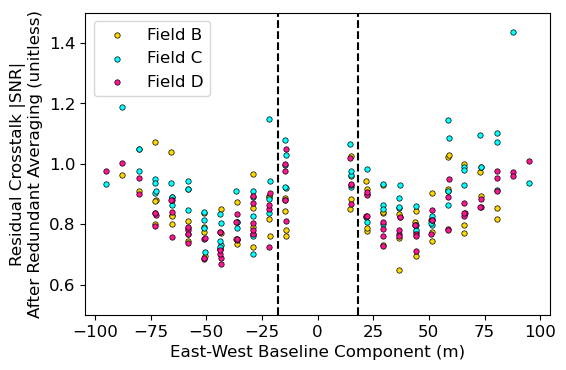

In [26]:
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=100)

for i, lstcut in enumerate(lstcuts):
    if i == 0 or i == 4:
        continue
    snr_array = []
    ew_comps = []
    for n, (blp, blvec) in enumerate(zip(blps, blvecs)):
        key=(spw, blp, ('pI', 'pI'))        
        snr_array.append(SNRs[key][lstcut])
        ew_comps.append(blvec[0])

    ax.scatter(ew_comps, snr_array, s=15, ec='k', linewidths=.5, c=lst_colors[i], label=f'Field {"ABCDE"[i]}')
    
ax.axvline(-18, ls='--', c='k')
ax.axvline(18, ls='--', c='k')
ax.tick_params(labelsize=12)
ax.set_ylim([.5, 1.5])
ax.set_xlabel('East-West Baseline Component (m)', fontsize=12)
ax.set_ylabel('Residual Crosstalk |SNR|\nAfter Redundant Averaging (unitless)', fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.savefig(f'residual_xtalk_vs_baseline.pdf', bbox_inches='tight')

In [27]:
# fig, axes = plt.subplots(len(lstcuts), 1, figsize=(7,14.5), sharex=True, gridspec_kw={'hspace': 0})

# for i, lstcut in enumerate(lstcuts):
#     ax = axes.flatten()[i]
#     avg_snrs = np.array([])
#     for n, (blp, blvec) in enumerate(zip(blps, blvecs)):

#         if SNRs[key][lstcut] == 0:
#             avg_snrs = np.append(avg_snrs, 0)
#         else:
#             avg_snrs = np.append(avg_snrs, SNRs[key][lstcut])
#     scatter = ax.scatter(blvecs[:,0], blvecs[:,1], c=avg_snrs, s=350, cmap='turbo', edgecolors='k', norm=matplotlib.colors.LogNorm())
#     scatter.set_clim([.63, 2])
#     ax.set_aspect('equal')
#     ax.set_ylim([-110, 10])
#     if i == (len(lstcuts) - 1):
#         ax.set_xlabel('EW-Baseline Component (m)', fontsize=16)
        
#     ax.set_ylabel('NS-Baseline (m)', fontsize=16)
#     ax.text(101, -103, f'Field {"ABCDEFGHIJ"[i]}', va='center', ha='right')#, bbox=dict(facecolor='w', alpha=0.8))

# plt.tight_layout()
    
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.8, axes[-1].get_position().extents[1], 0.05, 
#                         axes[0].get_position().extents[-1] - axes[-1].get_position().extents[1]])
# cbar = fig.colorbar(scatter, cax=cbar_ax,  extend='both')
# cbar.set_label(label='Average $|$SNR$|$ at ' + f'{xtalk_dly_min}' + ' $<|\\tau |<$ ' + f'{xtalk_dly_max} ns After Averaging', labelpad=-30)
    
# # plt.savefig(f'{figures_folder}/{prefix}redundant_avg_xtalk_SNR_band_{spw+1}.pdf', dpi=200, bbox_inches='tight')

# 2D Power Spectra

In [28]:
with open('../All_Epochs_Power_Spectra/figures/uvp_xtk_tavg.p', 'rb') as f:
    uvp_xtk_tavg = pickle.load(f)
    
fields_used = [0, 1, 2, 3, 4]
wedge_buff_ns = 300

In [29]:
def wedge_plot(uvp, ax, spw, loglog=True, log10=True, fold=True, xlim=(5.0e-3, 6.1e-2), cmap='Spectral_r',
               ylim=(1.5e-2, 2.8e0), polpair=('pI', 'pI'), cbax=None, twiny=True, bl_label=True, twinx=True, dly_label=True, red_tol=0.1,
               component='real', fontsize=20, **kwargs):
    """
    Augmented wedge plotter, based off of hera_pspec.plot.delay_wedge

    Args:
        uvp : UVPSpec object
        **

    Returns:
       ax2, ax3 : axis objects of twin axes

    Note:
        To access colorbar, use ax.collections[0].colorbar 
    """
    freqs = uvp.get_spw_ranges(spw)[0][:2]
    z = uvp.cosmo.f2z(np.mean(uvp.get_spw_ranges(spw)[0][:2]))
    t2k = uvp.cosmo.tau_to_kpara(z, little_h=True) / 1e9

    hera_pspec.plot.delay_wedge(uvp, spw, polpair, log10=log10, ax=ax, fold=fold, rotate=True,
                                horizon_lines=False, red_tol=red_tol, colorbar=cbax is not None,
                                cbax=cbax, cmap=cmap, delay=False,
                                loglog=loglog, component=component, **kwargs)
    ax.tick_params(labelsize=16, size=8, direction='in', width=1, pad=10)
    ax.tick_params(which='minor', size=4, direction='in', width=1)
    if cbax is not None:
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=16)

#     x = np.linspace(5, 140, 100)
#     k = x * uvp.cosmo.bl_to_kperp(z)
#     y = x / 2.99e8 * t2k * 1e9
#     ax.plot(k, y + .0, color='grey', ls='--', lw=2.5)
    #ax.plot(k, y + np.diff(uvp.dly_array)[0] * 1e9 * t2k * 2, color='w', ls='--', lw=3)
    #ax.text(5.2e-3, 0.9e-1, "horizon", fontsize=18, rotation=0, c='w')

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(r'$k_{\perp}\ (h\ {\rm Mpc}^{-1}$)', fontsize=fontsize)
    ax.set_ylabel(r'$k_{\parallel}\ (h\ {\rm Mpc}^{-1}$)', fontsize=fontsize)

    ax2 = None
    if twiny:
        ax2 = ax.twiny()
        if loglog:
            ax2.set_xscale('log')
        ax2.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
        ax2.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:.1f}"))
        ax2.set_xlim(*np.array(ax.get_xlim()) / uvp.cosmo.bl_to_kperp(z))
        ax2.tick_params(which='major', length=8, direction='in', width=1, labelsize=12)
        ax2.tick_params(which='minor', length=4, direction='in', width=1, labelsize=12)
        if bl_label:
            ax2.set_xlabel(r"$|b|$ (m)", fontsize=fontsize, labelpad=10)
        else:
            ax2.set_xticklabels([])

    ax3 = None
    if twinx:
        ax3 = ax.twinx()
        if loglog:
            ax3.set_yscale('log')
        ax3.set_ylim(*np.array(ax.get_ylim()) / t2k)
        ax3.tick_params(which='major', length=8, direction='in', width=1, labelsize=12)
        ax3.tick_params(which='minor', length=4, direction='in', width=1)
        if dly_label:
            ax3.set_ylabel(r"$\tau$ (ns)", fontsize=fontsize, labelpad=10)
        else:
            ax3.set_yticklabels([])
        
    return ax2, ax3

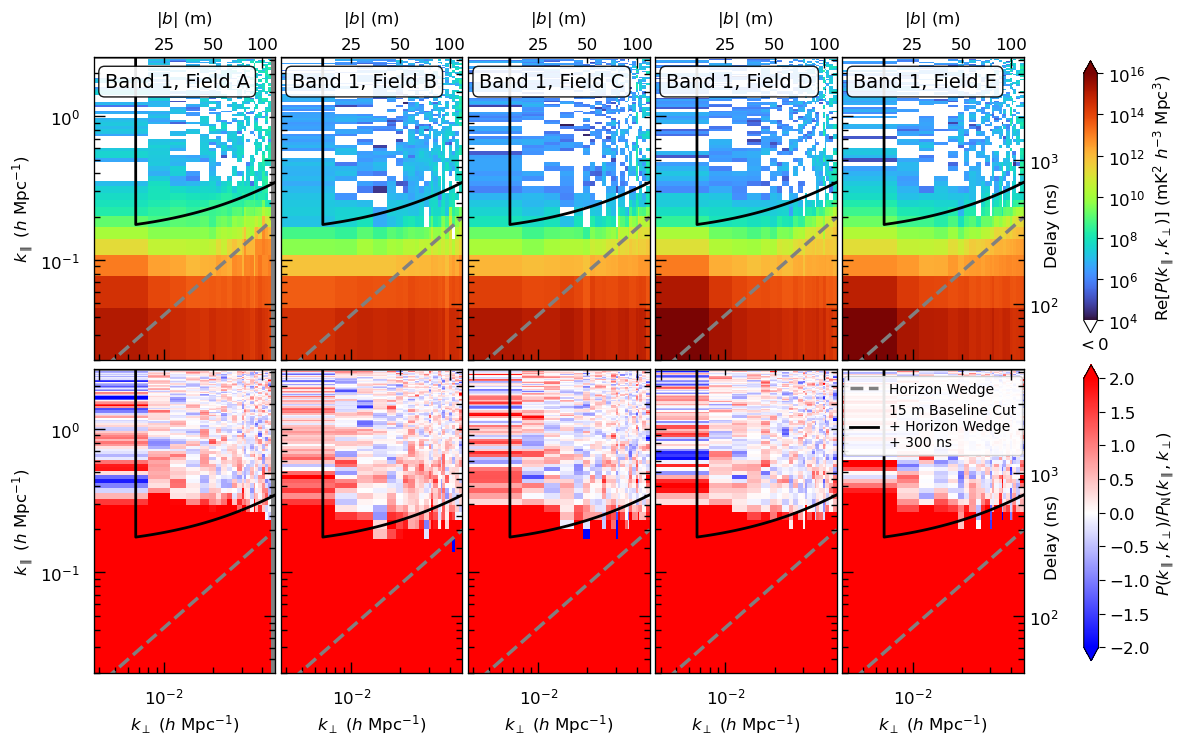

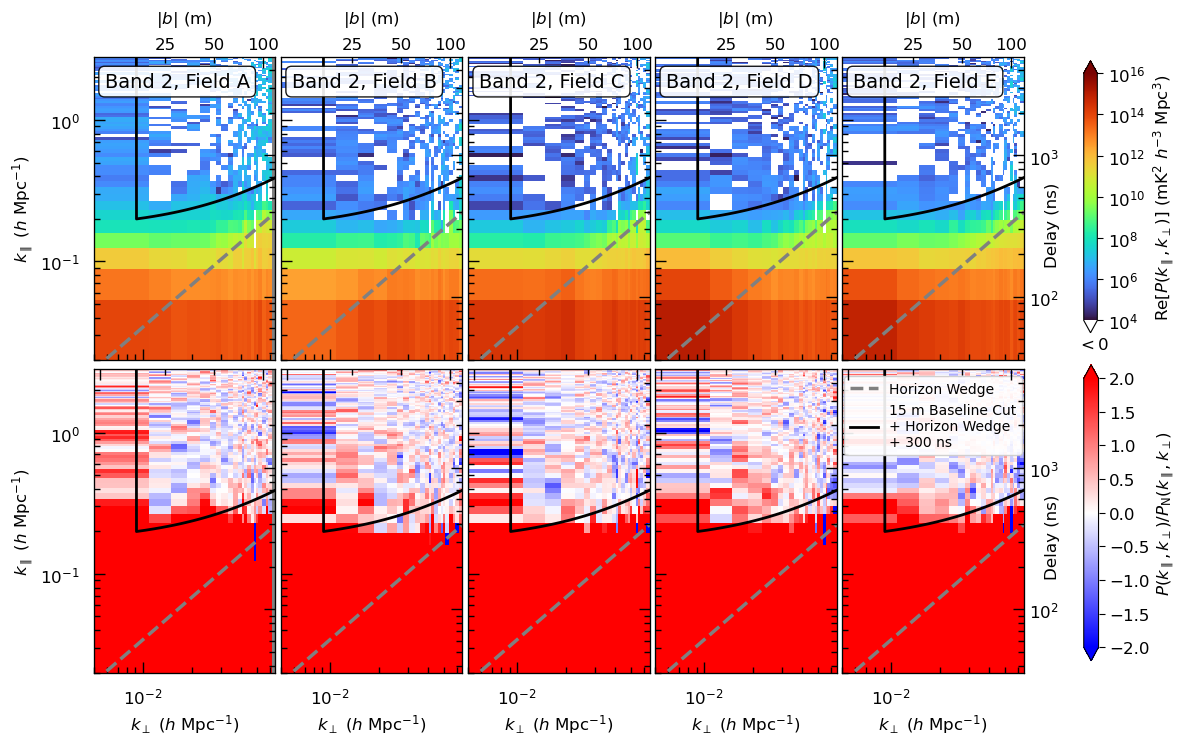

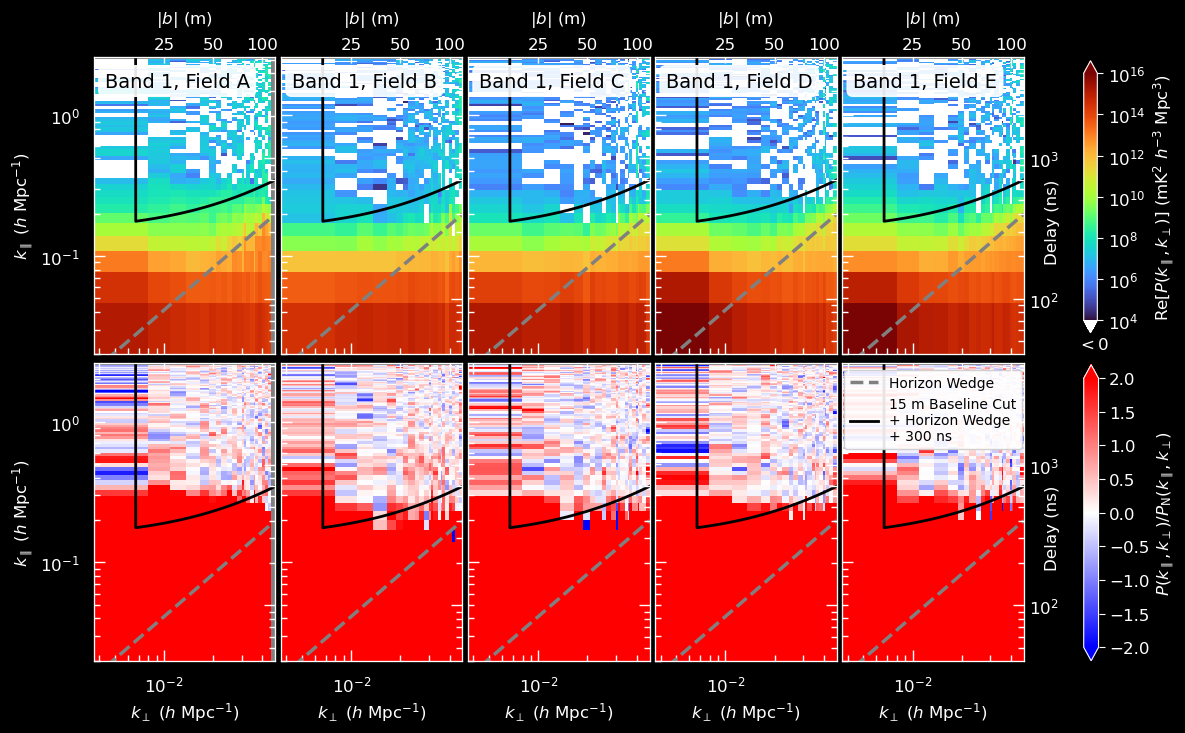

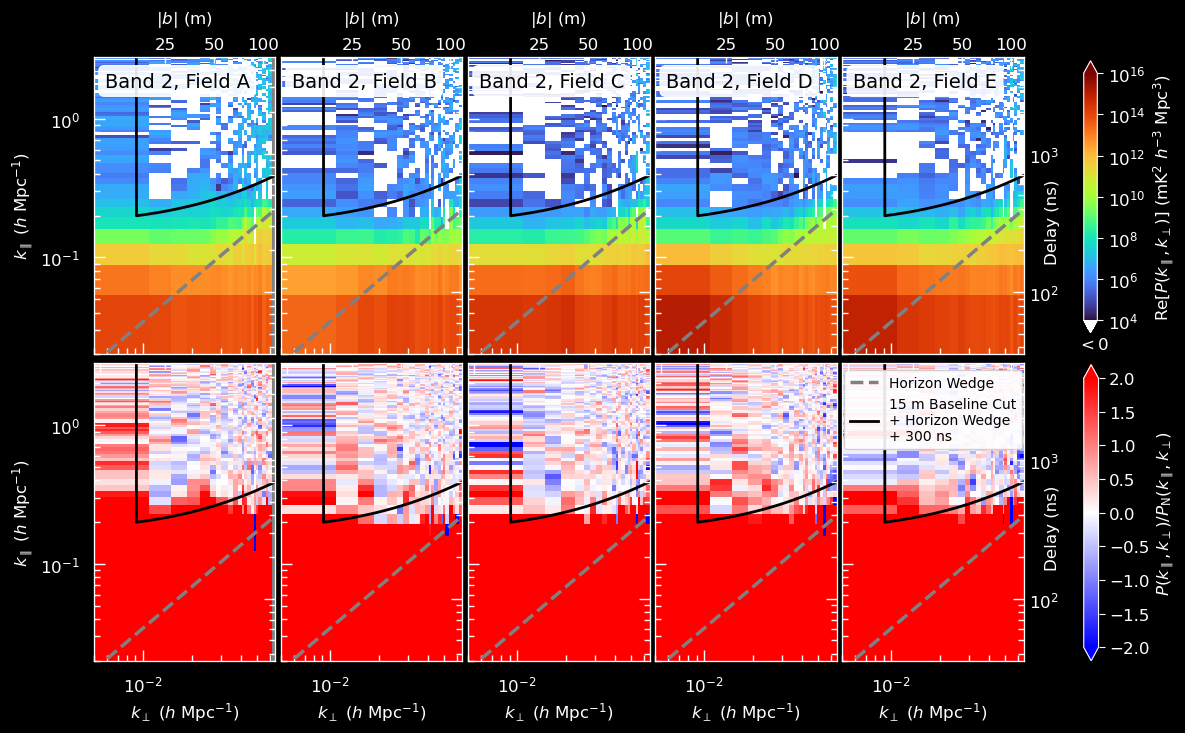

In [30]:
for n,style in enumerate(['default', 'dark_background']):
    with plt.style.context(style):
        # basic settings
        component = 'real'
        cmap1 = copy.copy(plt.get_cmap("turbo"))
        cmap1.set_bad('w')
        if 'abs' in component:
            cmap1.set_under(plt.cm.turbo([0])[0])
        else:
            cmap1.set_under('w')
        cmap2 = plt.get_cmap("bwr")



        for spw in [0, 1]:
            if spw == 0:
                xlim = 0.0037, 0.048
                ylim = 0.02, 2.6
            elif spw == 1:
                xlim = 0.005, 0.065
                ylim = 0.02, 2.8               

            fig, axes = plt.subplots(2, len(uvp_xtk_tavg), figsize=(12, 8), dpi=100)
            fig.subplots_adjust(wspace=0.03, hspace=0.03)


            for i in range(2):
                for j in range(len(uvp_xtk_tavg)):
                    ax = axes[i, j]
                    ax.axvspan(0, 1, 0, 1, color='grey', zorder=0)

                    # select only baseline pairs with finite noise
                    u = copy.deepcopy(uvp_xtk_tavg[j])
                    good_blps = set([])
                    for key in u.get_all_keys():
                        if key[0] == spw:
                            if np.all(np.isfinite(u.get_stats('P_N', key))):
                                good_blps.add(key[1])
                    if len(good_blps) == 0:
                        continue
                    u.select(blpairs=sorted(good_blps))

                    if i == 0:
                        ax2, ax3 = wedge_plot(u, ax, spw, dly_label=(j==4), cmap=cmap1, component=component, error_weights='P_N',
                                              xlim=xlim, ylim=ylim, twinx=True, twiny=True, fontsize=12, log10=False,
                                              norm=matplotlib.colors.LogNorm(vmin=1e4, vmax=1e16))
                        ax2.set_xticks([100], minor=False); ax2.set_xticklabels([100], minor=False, fontsize=12)
                        ax2.set_xticks([25, 50, 100], minor=True); ax2.set_xticklabels([25, 50, 100], minor=True, fontsize=12)
                    else:
                        u.data_array[spw] /= u.stats_array['P_N'][spw].real
                        ax2, ax3 = wedge_plot(u, ax, spw,  dly_label=(j==4), bl_label=False, cmap=cmap2, component=component, log10=False,
                                              xlim=xlim, ylim=ylim, fontsize=12, twinx=True, twiny=True, vmin=-2, vmax=2)
                        ax2.set_xticks([25, 50, 100], minor=True); ax2.set_xticklabels(['', '', ''], minor=True); 

                    ax.tick_params(labelsize=12)
                    if j > 0:
                        ax.set_yticklabels([])
                        ax.set_ylabel('')
                    if i == 0:
                        ax.set_xticklabels([])
                        ax.set_xlabel('')
                    if i == 0:
                        ax.text(0.06, 0.9, "Band {}, Field {}".format(spw+1, "ABCDEFGHIJ"[fields_used[j]]), fontsize=14, transform=ax.transAxes, 
                                color='k', bbox=dict(facecolor='w', alpha=0.9, boxstyle='round'))

                    # plot buffer
                    x = np.linspace(5, 120)  # meters
                    z = u.cosmo.f2z(np.mean(u.get_spw_ranges(spw)[0][:2]))

                    y = 1e9 / scipy.constants.c * x  # ns
                    kperp, kpara = x * u.cosmo.bl_to_kperp(z, little_h=True), y * u.cosmo.tau_to_kpara(z, little_h=True) / 1e9
                    ax.plot(kperp, kpara, c='grey', ls='--', lw=2.5, label='Horizon Wedge')

                    y = 1e9 / scipy.constants.c * x + wedge_buff_ns  # ns
                    kperp, kpara = x * u.cosmo.bl_to_kperp(z, little_h=True), y * u.cosmo.tau_to_kpara(z, little_h=True) / 1e9
                    kpara[x < 15] = 1e100
                    ax.plot(kperp, kpara, c='k', lw=2, label=f'15 m Baseline Cut\n+ Horizon Wedge\n+ {wedge_buff_ns} ns')

                    if i == 1 and j == 4:
                        leg = ax.legend(framealpha=.9, fontsize=10, loc='upper center', facecolor="w", labelcolor='k')

                    if j == 4:
                        ax3.set_ylabel('Delay (ns)      ', fontsize=12, labelpad=-10)    

                if i == 0:
                    cbax = fig.add_axes([0.865, 0.535, 0.1, 0.34])
                else:
                    cbax = fig.add_axes([0.865, 0.125, 0.1, 0.37])
                cbax.axis('off')
                cax = ax.collections[0]
                extend = 'both' if i == 0 else 'both'
                cbar = fig.colorbar(cax, ax=cbax, extend=extend)
                cbar.ax.tick_params(labelsize=12, direction='out', size=4)
                if i== 0:
                    cbar.set_label(r"Re$[P(k_\parallel, k_\perp)]\ ({\rm mK}^2\ h^{-3}\ {\rm Mpc}^3)$", fontsize=12)#, labelpad=8)
                    cbax.text(.99, -.06, "$< 0$", fontsize=12)
                else:
                    cbar.set_label(r"$P(k_\parallel, k_\perp) / P_{\rm N}(k_\parallel,k_\perp)$", fontsize=12)#, labelpad=15)

            plt.savefig(f'Cylindrical_Pk_Band_{spw+1}{"_dark" if n==1 else ""}.png', dpi=300, bbox_inches='tight')

# 1D Power Spectra

In [31]:
uvp_xtk_dsq_1 = []
uvp_xtk_dsq_2 = []
for field in 'ABCDE':
    uvp = hera_pspec.UVPSpec()
    uvp.read_hdf5(f'../All_Epochs_Power_Spectra/results_files/Deltasq_Band_1_Field_{field}.h5')
    uvp_xtk_dsq_1.append(uvp)
    
    uvp = hera_pspec.UVPSpec()
    uvp.read_hdf5(f'../All_Epochs_Power_Spectra/results_files/Deltasq_Band_2_Field_{field}.h5')
    uvp_xtk_dsq_2.append(uvp)
    

divide by zero encountered in true_divide
invalid value encountered in subtract
invalid value encountered in subtract
divide by zero encountered in true_divide
invalid value encountered in subtract
invalid value encountered in subtract


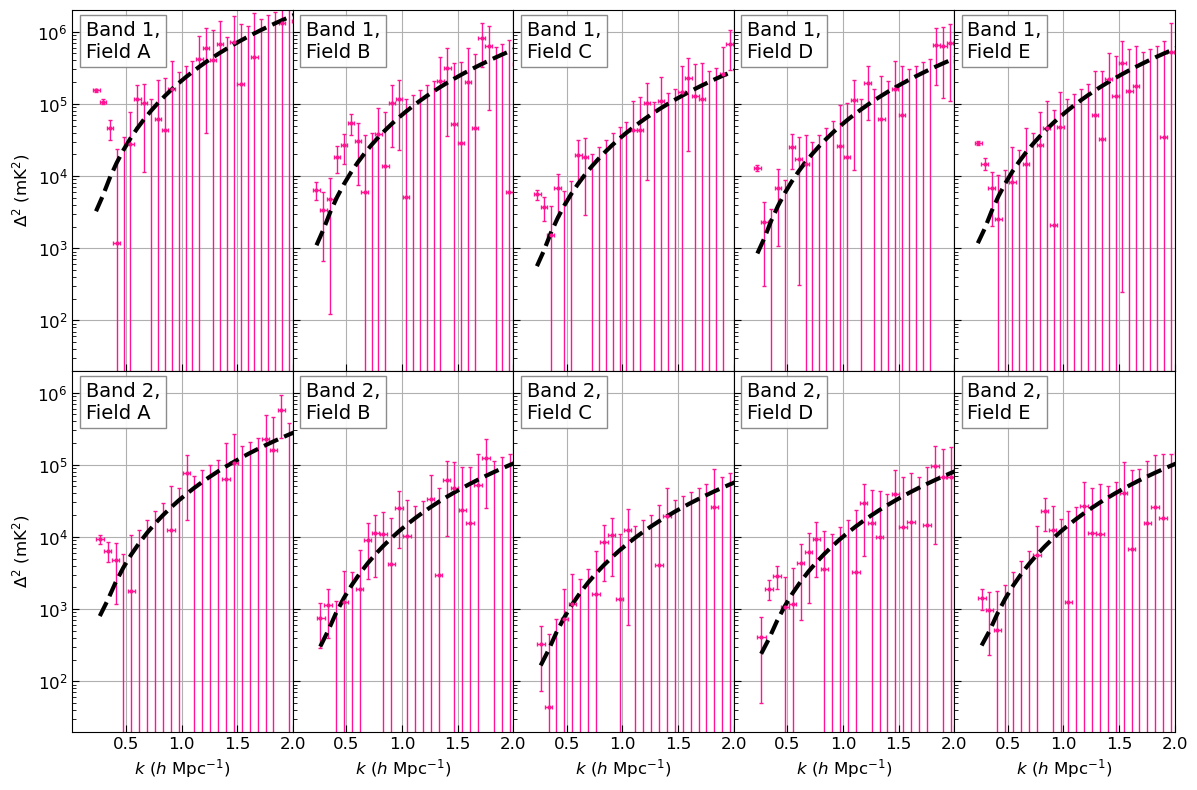

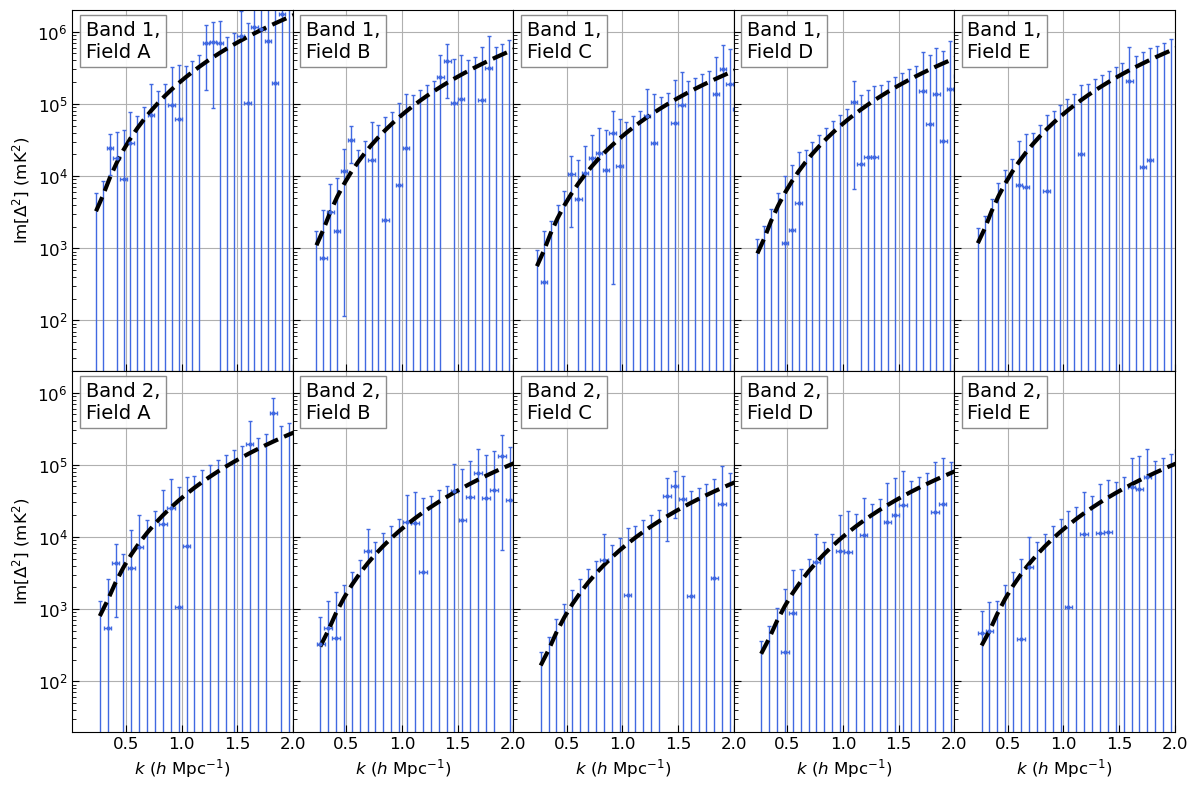

In [32]:
xlim = .02, 2
ylim = 2e1, 2e6

# loop over real and imaginary power spectra
for func, c in [(np.real, 'deeppink'), (np.imag, 'royalblue')]:
    fig, axes = plt.subplots(2, len(uvp_xtk_dsq_1),figsize=(12, 8), dpi=100, gridspec_kw={'hspace': 0, 'wspace': 0})
    fig.subplots_adjust(wspace=0.05, hspace=0.05)

    for i in range(2):
        uvp_xtk_dsq = [uvp_xtk_dsq_1, uvp_xtk_dsq_2][i]
        for j in range(len(uvp_xtk_dsq)):
            # get data
            ax = axes[i, j]
            u = uvp_xtk_dsq[j]
            spw = 0#i because we're loading only one band into each object
            
            kp = uvp_xtk_dsq[j].get_kparas(spw)
            ks = slice(np.argmin(np.abs(kp - 0.128)), None, 1)
            
            # get power spectra and vertical error bars
            y = func(u.data_array[spw].squeeze().copy()[ks].copy())
            y[y < 0] *= 0
            yerr = np.sqrt(np.diagonal(u.cov_array_real[spw].squeeze()))[ks]
            pn = u.stats_array['P_N'][spw].real.squeeze()[ks]
            pn[pn <= 0] = np.nan
            kbins = u.get_kparas(spw)
            k = kbins[ks]
            z = u.cosmo.f2z(np.mean(u.get_spw_ranges()[spw][:2]))       

            # get x errorbars from window func
            x, xerr_low, xerr_hi = sqe.utils.interp_Wcdf(u.window_function_array[spw].squeeze(), kbins)
            xerr = np.array([xerr_low, xerr_hi]).T[ks]
            # plot data
            p1 = ax.errorbar(k, y, marker='o', ms=2, ls='', capsize=1.5,
                             yerr=yerr * 2, c=c, xerr=xerr.T, lw=1)
            p2, = ax.plot(k, pn, c='k', ls='--', lw=3)

            # handle subplot
            ax.tick_params(labelsize=12, direction='in', size=5)
            ax.tick_params(direction='in', size=3, which='minor')
            ax.set_yscale('log')
            ax.grid()
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.text(0.06, 0.97, "Band {},\nField {}".format(i+1, "ABCDEFGHIJ"[fields_used[j]]), fontsize=14,
                    transform=ax.transAxes, bbox=dict(fc='w', ec='grey', alpha=0.9), va='top', ha='left')
            if i == 0:
                ax.set_xticklabels([])
            else:
                ax.set_xlabel(r"$k\ (h\ {\rm Mpc}^{-1})$", fontsize=12)
            if j == 0:
                if func == np.real:
                    ax.set_ylabel(r"$\Delta^2\ ({\rm mK}^2)$", fontsize=12)
                else:
                    ax.set_ylabel(r"Im$[\Delta^2]\ ({\rm mK}^2)$", fontsize=12)
            else:    
                ax.set_yticklabels([])
    
    plt.tight_layout()
    if func == np.imag:
        plt.savefig(f'all_imaginary_limits.pdf', dpi=200, bbox_inches='tight')
    else:
        plt.savefig(f'all_limits.pdf', dpi=200, bbox_inches='tight')

True


divide by zero encountered in true_divide
invalid value encountered in subtract
invalid value encountered in subtract


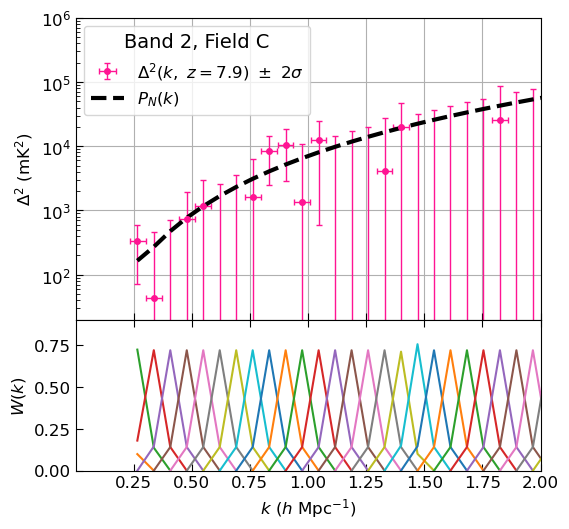

In [33]:
fig = plt.figure(figsize=(6, 6), dpi=100)
fig.subplots_adjust(hspace=0.0)

# set params
plot_window = True
component = 'real'
field = 2 # C
spw = 1


uvp_xtk_dsq = [uvp_xtk_dsq_1, uvp_xtk_dsq_2][spw]
i = 0#spw # because these objects were already split and thus have only one spw
u = uvp_xtk_dsq[fields_used.index(field)]
print(u.exact_windows)
kp = u.get_kparas(i)
ks = slice(np.argmin(np.abs(kp - 0.128)), None, 1)
c = 'deeppink'

# get data
y = u.data_array[i].real.squeeze().copy()[ks].copy()
y[y < 0] *= 0
yerr = np.sqrt(u.cov_array_real[i].squeeze().diagonal())[ks]
pn = u.stats_array['P_N'][i].real.squeeze()[ks]
pn[pn <= 0] = np.nan
kbins = u.get_kparas(i)
k = kbins[ks]
z = u.cosmo.f2z(np.mean(u.get_spw_ranges()[i][:2]))
xlim = 1e-4, 2

# get x errorbars from window func
x, xerr_low, xerr_hi = sqe.utils.interp_Wcdf(u.window_function_array[i].squeeze(), kbins)
xerr = np.array([xerr_low, xerr_hi]).T[ks]

grid = gridspec.GridSpec(3, 3)
if plot_window:
    ax = fig.add_subplot(grid[:2, :])
else:
    ax = fig.add_subplot(grid[:, :])

if component == 'abs-real':
    p1 = ax.errorbar(k, np.abs(y), marker='o', ms=4, ls='', yerr=yerr * 2, c=c, capsize=2)
else:
    p1 = ax.errorbar(k, np.real(y), marker='o', ms=4, ls='', capsize=2,
                     yerr=yerr * 2, c=c, xerr=xerr.T, lw=1)

p2, = ax.plot(k, pn, c='k', ls='--', lw=3)

ax.tick_params(labelsize=12, direction='in', size=5)
ax.tick_params(direction='in', size=3, which='minor')
ax.set_yscale('log')
ax.grid()
ax.set_xlim(xlim)
ax.set_ylim(2e1, 1e6)
ax.legend([p1, p2], [r'$\Delta^2(k,\ z={:.1f})\ \pm\ 2\sigma$'.format(z), r'$P_N(k)$'],
          fontsize=12, loc=2, ncol=1, title=f'Band {spw+1}, Field {"ABCDEFGHIJ"[field]}', title_fontsize=14)
if not plot_window:
    ax.set_xlabel(r'$k\ (h\ {\rm Mpc}^{-1}$)', fontsize=12)
else:
    ax.set_xticklabels([])
ax.set_ylabel(r'$\Delta^2\ ({\rm mK}^2)$', fontsize=12)

if plot_window:
    ax = fig.add_subplot(grid[2:, :])
    ax.tick_params(labelsize=12, direction='in', size=5, top=True, bottom=True)
    for win in u.window_function_array[i].squeeze()[:, ks].T:
        ax.plot(kbins, np.where(win < 1e-4, np.nan, win), lw=1.5)
    ax.set_xlim(xlim)
    ax.set_ylim(0, 0.9)
    ax.set_yticks([0, .25, .5, .75])
    ax.set_xlabel(r'$k\ (h\ {\rm Mpc}^{-1}$)', fontsize=12)
    ax.set_ylabel(r"$W(k)$", fontsize=12)
    #ax.set_yscale('log')
    
plt.savefig(f'limits_band_{spw+1}_field_{"ABCDEFGHIJ"[field]}.pdf', dpi=200, bbox_inches='tight')

In [34]:
max_k = 1

for spw in [0, 1]:

    uvp_xtk_dsq = [uvp_xtk_dsq_1, uvp_xtk_dsq_2][spw]
    i = 0#spw
    table_created = False
    for field in range(len(uvp_xtk_dsq)):
        ks = uvp_xtk_dsq[field].get_kparas(i)
        deltasq = uvp_xtk_dsq[field].data_array[i].squeeze().copy().real
        deltasq_err = np.sqrt(uvp_xtk_dsq[field].cov_array_real[i].squeeze().diagonal())
        deltasq_ul = np.array([dsq if dsq > 0 else 0 for dsq in deltasq]) + 2 * deltasq_err

        to_use = (ks <= max_k) & (deltasq_err > 0)
        if len(deltasq_ul[to_use]) == 0:
            continue
        
        if not table_created:
            table = np.vstack([deltasq[to_use], deltasq_err[to_use], deltasq_ul[to_use]])
            table_created = True
        else:
            table = np.vstack([table, deltasq[to_use], deltasq_err[to_use], deltasq_ul[to_use]])

    df = pd.DataFrame(table.T)

    col_ix = pd.MultiIndex.from_product([[f'Field {"ABCDEFGHIJ"[field]}' for field in fields_used], 
                                         ['$\Delta^{2}(k)$', '$1\sigma$', '$\Delta^{2}_{UL}$']]) 
    df.columns = col_ix
    df.insert(0, r"$k\ [h\ {\rm Mpc}^{-1}]$", ks[to_use])

    def css_border(x):
        return ["border-left: 1px solid black" if (i%3==1) else "border: 0px" for i, col in enumerate(x)]
    display(HTML(f'<h2>Band {spw+1}:</h2>'))
    
    to_display = df.style.hide_index() \
                   .format("{:,.2f}") \
                   .apply(css_border, axis=1) \
                   .set_properties(width='80px')
    
    display(HTML(to_display.render()))

In [35]:
# Print LaTeX to copy-paste into document


for spw in [0, 1]:
    kmax = [.65, .7][spw]
    uvp_xtk_dsq = [uvp_xtk_dsq_1, uvp_xtk_dsq_2][spw]
    i = 0#spw
    table_created = False
    for field in range(len(uvp_xtk_dsq)):
        ks = uvp_xtk_dsq[field].get_kparas(0)
        deltasq = uvp_xtk_dsq[field].data_array[0].squeeze().copy().real
        deltasq_err = np.sqrt(uvp_xtk_dsq[field].cov_array_real[0].squeeze().diagonal())
        deltasq_ul = np.array([dsq if dsq > 0 else 0 for dsq in deltasq]) + 2 * deltasq_err
        
        to_use = (ks < kmax) & (deltasq_err > 0)
        if len(deltasq_ul[to_use]) == 0:
            continue
        
        print(f'% Band {spw+1}, Field {"ABCDEFGHIJ"[field]}')
        print('\n'.join([r'\multicolumn{1}{c}{} &',
                 r'\multicolumn{3}{c}{\textbf{Field ' + "ABCDEFGHIJ"[field] +r'}} \\',
                 r'\cmidrule(lr){2-4}',
                 r'\multicolumn{1}{c}{$k$ $(h\ {\rm Mpc}^{-1})$} &',
                 r'\multicolumn{1}{c}{$\Delta^2$ $({\rm mK})^2$} &',
                 r'\multicolumn{1}{c}{$1\sigma$ $({\rm mK})^2$} &',
                 r'\multicolumn{1}{c}{$\Delta^2_{\rm UL}$ $({\rm mK})^2$} \\',
                 r'\midrule']))
        for k, dsq, dsqerr, dsqul in zip(ks[to_use], deltasq[to_use], deltasq_err[to_use], deltasq_ul[to_use]):
            print(f'{k:.2f} & {dsq:,.0f} & {dsqerr:,.0f} & {dsqul:,.0f} \\\\')
        
        if field + 1 < len(uvp_xtk_dsq):
            print('')
            print(r'\cmidrule(lr){1-4}')
            print('')
        
    print('\n\n\n')

% Band 1, Field A
\multicolumn{1}{c}{} &
\multicolumn{3}{c}{\textbf{Field A}} \\
\cmidrule(lr){2-4}
\multicolumn{1}{c}{$k$ $(h\ {\rm Mpc}^{-1})$} &
\multicolumn{1}{c}{$\Delta^2$ $({\rm mK})^2$} &
\multicolumn{1}{c}{$1\sigma$ $({\rm mK})^2$} &
\multicolumn{1}{c}{$\Delta^2_{\rm UL}$ $({\rm mK})^2$} \\
\midrule
0.23 & 153,691 & 2,933 & 159,556 \\
0.29 & 107,667 & 4,271 & 116,208 \\
0.36 & 45,688 & 7,105 & 59,898 \\
0.42 & 1,182 & 11,336 & 23,854 \\
0.48 & -6,756 & 17,231 & 34,462 \\
0.54 & 28,245 & 24,666 & 77,577 \\
0.60 & 115,543 & 33,997 & 183,537 \\

\cmidrule(lr){1-4}

% Band 1, Field B
\multicolumn{1}{c}{} &
\multicolumn{3}{c}{\textbf{Field B}} \\
\cmidrule(lr){2-4}
\multicolumn{1}{c}{$k$ $(h\ {\rm Mpc}^{-1})$} &
\multicolumn{1}{c}{$\Delta^2$ $({\rm mK})^2$} &
\multicolumn{1}{c}{$1\sigma$ $({\rm mK})^2$} &
\multicolumn{1}{c}{$\Delta^2_{\rm UL}$ $({\rm mK})^2$} \\
\midrule
0.23 & 6,414 & 878 & 8,169 \\
0.29 & 3,352 & 1,343 & 6,038 \\
0.36 & 4,815 & 2,346 & 9,506 \\
0.42 & 18,593 & 3,

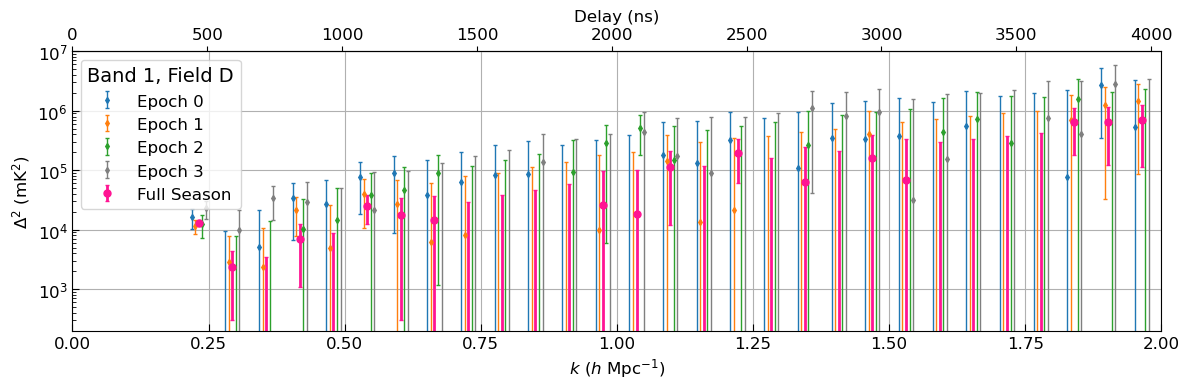

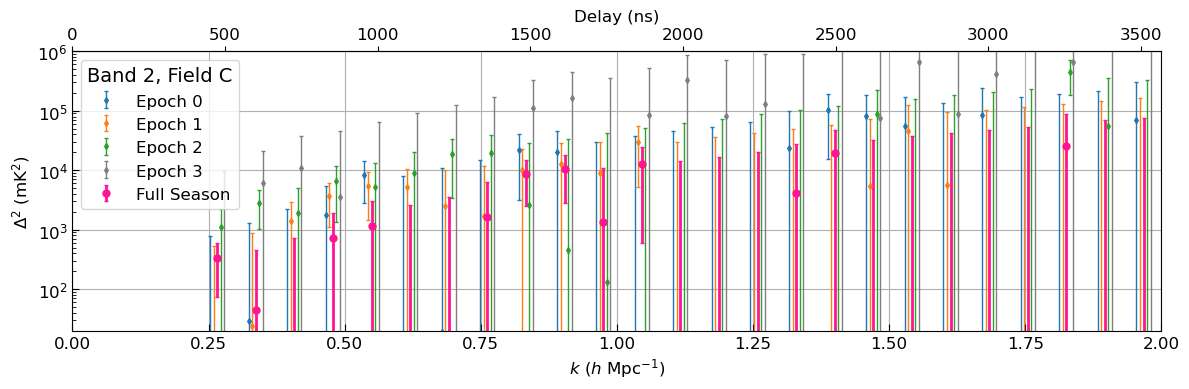

In [36]:
for spw, field, ylim in zip([0, 1], [3, 2], [(2e2, 1e7), (2e1, 1e6)]):

    fig = plt.figure(figsize=(12, 4), dpi=100)
    fig.subplots_adjust(hspace=0.0)

    # set params
    plot_window = True
    component = 'real'


    epoch_folders = ['../../Epoch_0_Power_Spectra/', '../Epoch_1_Power_Spectra/', '../Epoch_2_Power_Spectra/', '../Epoch_3_Power_Spectra/']
    for i, folder in enumerate(epoch_folders):
        u = hera_pspec.UVPSpec()
        u.read_hdf5(folder + f'results_files/Deltasq_Band_{spw+1}_Field_{"ABCDE"[field]}.h5')

        kp = u.get_kparas(0)
        ks = slice(np.argmin(np.abs(kp - 0.128)), None, 1)
        c = 'deeppink'

        # get data
        y = u.data_array[0].real.squeeze().copy()[ks].copy()
        y[y < 0] *= 0
        yerr = np.sqrt(u.cov_array_real[0].squeeze().diagonal())[ks]
        pn = u.stats_array['P_N'][0].real.squeeze()[ks]
        pn[pn <= 0] = np.nan
        kbins = u.get_kparas(0)
        k = kbins[ks]
        z = u.cosmo.f2z(np.mean(u.get_spw_ranges()[0][:2]))

        offset_k = k + [-2, -1, 1, 2][i]*.0065

        p1 = plt.errorbar(offset_k, np.real(y), marker='d', ms=3, ls='', c=['C0', 'C1', 'C2', 'C7'][i], yerr=yerr * 2, lw=1, label=f'Epoch {i}', capsize=1.5)


    # get data
    uvp_xtk_dsq = [uvp_xtk_dsq_1, uvp_xtk_dsq_2][spw]
    u = uvp_xtk_dsq[fields_used.index(field)]
    y = u.data_array[0].real.squeeze().copy()[ks].copy()
    y[y < 0] *= 0
    yerr = np.sqrt(u.cov_array_real[0].squeeze().diagonal())[ks]
    pn = u.stats_array['P_N'][0].real.squeeze()[ks]
    pn[pn <= 0] = np.nan
    kbins = u.get_kparas(0)
    k = kbins[ks]
    z = u.cosmo.f2z(np.mean(u.get_spw_ranges()[0][:2]))
    p1 = plt.errorbar(k, np.real(y), marker='o', ms=5, ls='', c = 'deeppink', yerr=yerr * 2, lw=2, label=f'Full Season', capsize=1.5)

    plt.gca().tick_params(labelsize=12, direction='in', size=5)
    plt.gca().tick_params(direction='in', size=3, which='minor')
    plt.gca().set_yscale('log')
    plt.gca().grid()
    plt.gca().set_xlim([.00, 2])
    plt.gca().set_ylim(ylim)
    plt.gca().legend(loc='upper left', fontsize=12, ncol=1, title=f'Band {spw+1}, Field {"ABCDE"[field]}', title_fontsize=14)

    plt.gca().set_ylabel(r'$\Delta^2\ ({\rm mK}^2)$', fontsize=12)
    plt.gca().set_xlabel(r'$k\ (h\ {\rm Mpc}^{-1}$)', fontsize=12)

    from scipy.interpolate import interp1d

    kpara2dly = interp1d(u.get_kparas(0), u.get_dlys(0) * 1e9, fill_value='extrapolate')
    dly2kpara = interp1d(u.get_dlys(0) * 1e9, u.get_kparas(0), fill_value='extrapolate')
    secax = plt.gca().secondary_xaxis('top', functions=(kpara2dly, dly2kpara))    
    secax.set_xlabel('Delay (ns)', fontsize=12)
    secax.tick_params(labelsize=12)
    
    plt.tight_layout()
    plt.savefig(f'multi_epoch_limits_band_{spw+1}_field_{"ABCDEFGHIJ"[field]}.pdf', bbox_inches='tight')

# Likelihood Demonstration

divide by zero encountered in log


Uniform log-prior between 1e+00 and 1e7:
1$\sigma$ (68.3%): Delta^2 = 2.869e+01 mK^2
2$\sigma$ (95.4%): Delta^2 = 1.674e+02 mK^2
3$\sigma$ (99.7%): Delta^2 = 3.559e+02 mK^2


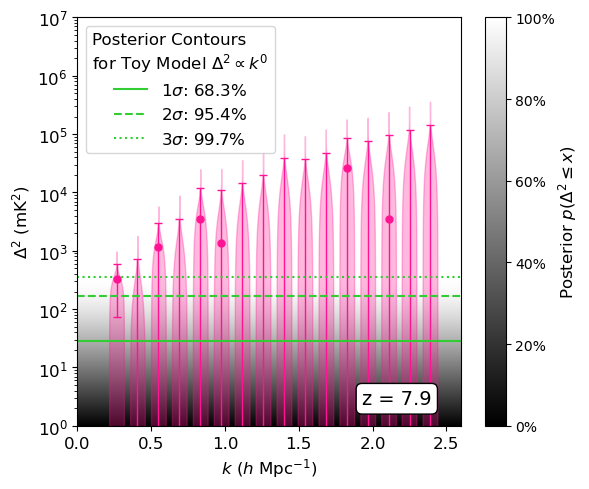

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(6,5), dpi=100)
spw = 1
prior_low = 1e0

# figure out measurements with best ULs
best_measurements = {}
best_sigmas = {}
best_uls = {}
all_ks = {}
for spw in [0, 1]:
    uvp_xtk_dsq = [uvp_xtk_dsq_1, uvp_xtk_dsq_2][spw]
    i = 0#spw
    table_created = False
    for field in range(len(uvp_xtk_dsq)):
        ks = uvp_xtk_dsq[field].get_kparas(0)
        deltasq = uvp_xtk_dsq[field].data_array[0].squeeze().copy().real
        deltasq_err = np.sqrt(uvp_xtk_dsq[field].cov_array_real[0].squeeze().diagonal())
        deltasq_ul = np.array([dsq if dsq > 0 else 0 for dsq in deltasq]) + 2 * deltasq_err
        
        all_ks[spw] = ks
        if field == 0:
            best_measurements[spw] = deltasq
            best_sigmas[spw] = deltasq_err
            best_uls[spw] = deltasq_ul
        else:
            to_update = (deltasq_ul < best_uls[spw])
            best_measurements[spw][to_update] = deltasq[to_update]
            best_measurements[spw][best_measurements[spw] < 0] = 0
            best_sigmas[spw][to_update] = deltasq_err[to_update]
            best_uls[spw][to_update] = deltasq_ul[to_update]
        
        
        to_use = (ks < kmax) & (deltasq_err > 0)
        if len(deltasq_ul[to_use]) == 0:
            continue


# take every other measurement
ks = all_ks[spw][best_sigmas[spw] > 0][::2]
measurements = best_measurements[spw][best_sigmas[spw] > 0][::2]
sigmas = best_sigmas[spw][best_sigmas[spw] > 0][::2]

# compute posterior as background 
ys = np.geomspace(prior_low, 1e7, 5000)
xs = np.linspace(0, 2.6, len(ks))
X, Y = np.meshgrid(xs, ys)
l = (0.5 * (1 + special.erf((measurements[np.newaxis, :] - Y) / np.sqrt(2) / sigmas[np.newaxis, :])))
logL = np.ones_like(Y) * np.sum(np.log(l), axis=1)[:, np.newaxis]
posterior = np.exp(logL) / np.sum(np.exp(logL), axis=0)
pc = ax.pcolor(xs, ys, np.cumsum(posterior, axis=0), cmap='gray', vmin=0, vmax=1)
fmt = lambda x, pos: '{:.0%}'.format(x)
cbar = plt.colorbar(pc, ax=ax, format=FuncFormatter(fmt))
cbar.set_label(r'Posterior $p(\Delta^2 \leq x)$', fontsize=12, labelpad=1)

# plot violins and and data with error bars
for k, dsq, std in zip(ks, measurements, sigmas):
    y = np.geomspace(1e-3,dsq + 5*std,1000)
    kde = 0.5 * (1 + special.erf((dsq-y) / np.sqrt(2) / std))
    v = ax.violin([{"coords": y, "vals": kde, "mean": 100, "median": -1, "min": -1, "max": -1}],
        positions=[k], widths=0.1)
    v['bodies'][0].set_color('deeppink')
p1 = plt.errorbar(ks, measurements, marker='o', ms=5, ls='', c = 'deeppink', yerr=sigmas * 2, lw=1, capsize=3)
    
# plot posterior contours
print(f'Uniform log-prior between {prior_low:.0e} and 1e7:')
for nsig, ls in zip([1, 2, 3], ['-', '--', ':']):
    prob = (1 - (1 - special.erf(nsig/np.sqrt(2))))
    contour = ys[np.argmin(np.abs(np.cumsum(posterior[:,0]) - prob))]
    print(f'{nsig}$\sigma$ ({prob:.1%}): Delta^2 = {contour:.3e} mK^2')
    ax.axhline(contour, color='limegreen', ls=ls, label=f'{nsig}$\sigma$: {prob:.1%}')

ax.set_ylim([prior_low,1e7])
ax.set_xlim([0,2.6])
legend = ax.legend(title='Posterior Contours\nfor Toy Model $\Delta^2 \propto k^0$', fontsize=12, loc='upper left')
plt.setp(legend.get_title(),fontsize=12)
    

ax.set_ylabel(r'$\Delta^2\ ({\rm mK}^2)$', fontsize=12)
ax.set_xlabel(r'$k\ (h\ {\rm Mpc}^{-1}$)', fontsize=12)
ax.set_yscale('log')
ax.tick_params(labelsize=12)#, direction='in', size=5, top=True, bottom=True)
ax.text(2.4, 2, f'z = {[10.4, 7.9][spw]}', 
         bbox=dict(facecolor='w', alpha=1, boxstyle='round'), va='bottom', ha='right', fontsize=14)

plt.tight_layout()
plt.savefig(f'band_{spw+1}_toy_model_posterior.png', bbox_inches='tight', dpi=300)

In [38]:
uvp_xtk_dsq_1 = []
uvp_xtk_dsq_2 = []
for field in 'ABCDE':
    uvp = hera_pspec.UVPSpec()
    uvp.read_hdf5(f'../All_Epochs_Power_Spectra/results_files/Deltasq_Band_1_Field_{field}.h5')
    uvp_xtk_dsq_1.append(uvp)
    
    uvp = hera_pspec.UVPSpec()
    uvp.read_hdf5(f'../All_Epochs_Power_Spectra/results_files/Deltasq_Band_2_Field_{field}.h5')
    uvp_xtk_dsq_2.append(uvp)

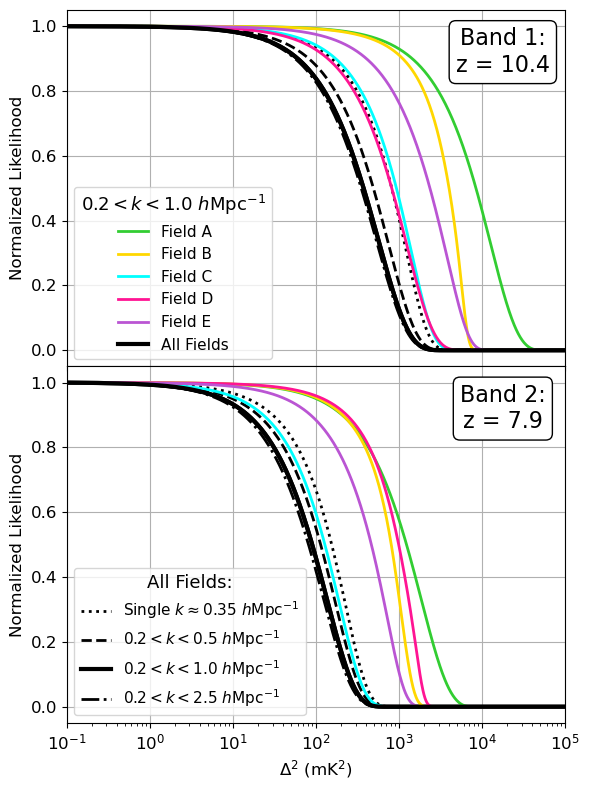

In [39]:
xlim = (-1, 5)
xs = np.logspace(xlim[0], xlim[1], 1000)
field_groups = [[0], [1], [2], [3], [4], [0, 1, 2, 3, 4]]
k_ranges = [(.3, .4), (.2, .5), (.2, 1.0), (.2, 2.5)]

fig, axes = plt.subplots(2, 1, figsize=(6, 8), sharex=True, sharey=True, gridspec_kw={'hspace': 0.0, 'wspace': 0}, dpi=100)

for spw, ax in enumerate(axes):

    def normalized_likelihood(kmin, kmax, fields):
        uvp_xtk_dsq = [uvp_xtk_dsq_1, uvp_xtk_dsq_2][spw]
        likelihood = np.ones_like(xs)
        i = 0 # assumed that these files are already spw selected
        for field in fields:
            ks = uvp_xtk_dsq[field].get_kparas(i)
            deltasq = uvp_xtk_dsq[field].data_array[i].squeeze().copy().real
            deltasq_err = np.sqrt(uvp_xtk_dsq[field].cov_array_real[i].squeeze().diagonal())

            for ik, (k, dsq, dsqerr) in enumerate(zip(ks, deltasq, deltasq_err)):
                if spw==1:
                    if ik % 2 == 1:
                        continue
                if spw == 0:
                    if ik % 2 == 0:
                        continue                  
                if dsqerr > 0 and k > kmin and k < kmax:
                    likelihood *= (0.5 * (1 + special.erf(((dsq if dsq > 0 else 0) - xs) / np.sqrt(2) / dsqerr)))

        return likelihood / np.max(likelihood)

    for ik, (kmin, kmax) in enumerate(k_ranges):
        if (kmin, kmax) == k_ranges[2]:
            props = dict(c='k', lw=3, ls='-')
        else:
            props = dict(c='k', lw=2, ls=[':', '--','-', '-.'][ik])
        if spw == 1:
            if (kmin, kmax) == k_ranges[0]:
                props['label'] = f'Single $k \\approx 0.35$ $h{{\\rm Mpc}}^{{-1}}$'
            else:
                props['label'] = f'${kmin} < k < {kmax}$ $h{{\\rm Mpc}}^{{-1}}$'
        ax.semilogx(xs, normalized_likelihood(kmin, kmax, field_groups[-1]), **props)    
    for fg in field_groups:
        if len(fg) == 1:
            props = dict(c=lst_colors[fg[0]], lw=2, ls='-')
        else:
            props = dict(c='k', lw=3, ls='-')
        if spw == 0:
            props['label'] = (f'Field {"ABCDE"[fg[0]]}' if len(fg) == 1 else 'All Fields')
            
        ax.semilogx(xs, normalized_likelihood(k_ranges[2][0], k_ranges[2][1], fg), **props)

    ax.grid()
    ax.set_xlim(10.**np.array(xlim))
    ax.set_ylim([-.05, 1.05])
    ax.set_ylabel('Normalized Likelihood', fontsize=12)
    ax.text(10.**4.25, .92, f'Band {spw+1}:\nz = {[10.4, 7.9][spw]}', ha='center', va='center', fontsize=16, 
            bbox={'ec': 'k', 'fc': 'w', 'boxstyle': 'round'})
    ax.tick_params(labelsize=12)
    
    
leg1 = axes[0].legend(fontsize=11, title=f'${k_ranges[2][0]} < k < {k_ranges[2][1]}$ $h{{\\rm Mpc}}^{{-1}}$', loc='lower left', title_fontsize=13)    
leg2 = axes[1].legend(fontsize=11, title='All Fields:', loc='lower left', title_fontsize=13)
axes[-1].set_xlabel('$\\Delta^2$ (mK$^2$)', fontsize=12)

plt.tight_layout()
plt.savefig('likelihoods.pdf', bbox_inches='tight')


# Validation Plots

In [40]:
uvp_eor_K_sph_1 = hera_pspec.UVPSpec()
uvp_eor_K_sph_2 = hera_pspec.UVPSpec()
uvp_eor_TK_sph_1 = hera_pspec.UVPSpec()
uvp_eor_TK_sph_2 = hera_pspec.UVPSpec()
# TODO: find a permanent home for these
uvp_eor_K_sph_1.read_hdf5('/lustre/aoc/projects/hera/Validation/test-4.1.0/h1c_idr3_validation_notebooks/signal_loss/uvp_eor_K_sph_1.h5') 
uvp_eor_K_sph_2.read_hdf5('/lustre/aoc/projects/hera/Validation/test-4.1.0/h1c_idr3_validation_notebooks/signal_loss/uvp_eor_K_sph_2.h5') 
uvp_eor_TK_sph_1.read_hdf5('/lustre/aoc/projects/hera/Validation/test-4.1.0/h1c_idr3_validation_notebooks/signal_loss/uvp_eor_TK_sph_1.h5') 
uvp_eor_TK_sph_2.read_hdf5('/lustre/aoc/projects/hera/Validation/test-4.1.0/h1c_idr3_validation_notebooks/signal_loss/uvp_eor_TK_sph_2.h5') 

invalid value encountered in true_divide


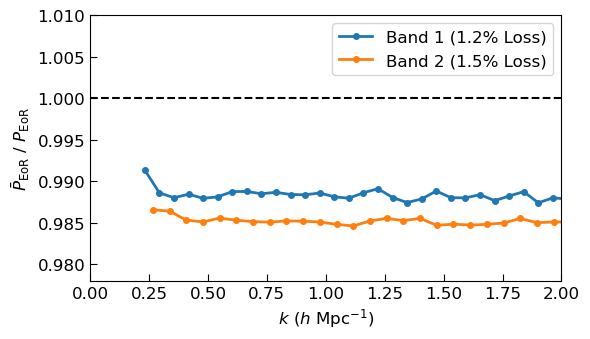

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(6,3.5), dpi=100)

ax.tick_params(labelsize=12, direction='in', size=5)
for band in range(2):
    uvp_eor_TK_sph = [uvp_eor_TK_sph_1, uvp_eor_TK_sph_2][band]
    uvp_eor_K_sph = [uvp_eor_K_sph_1, uvp_eor_K_sph_2][band]
    kbins = kbins = uvp_eor_K_sph.get_kparas(band)
    key = (band, uvp_eor_K_sph.get_blpairs()[0], 'pI')
    to_plot = uvp_eor_TK_sph.get_data(key).real[0] / uvp_eor_K_sph.get_data(key).real[0]
    p1, = ax.plot(kbins, to_plot, ls='-', marker='.', ms=8, lw=2, label=f'Band {band + 1} ({np.nanmean(1 - to_plot):.1%} Loss)')

ax.legend(fontsize=12)
ax.axhline(1, c='k', ls='--')
ax.set_xlim(.0, 2)
ax.set_ylim(0.978, 1.01)
# ax.grid()
ax.set_xlabel(r'$k\ (h\ {\rm Mpc}^{-1})$', fontsize=12)
ax.set_ylabel(r'$\bar{P}_{\rm EoR}\ /\ P_{\rm EoR}$', fontsize=12)
plt.tight_layout()

plt.savefig(f'time_averaging_signal_loss.pdf', dpi=200, bbox_inches='tight')

In [42]:
with open('/lustre/aoc/projects/hera/Validation/test-4.1.0/h1c_idr3_validation_notebooks/lst_bin_inspect/calibration_errors.p', 'rb') as f:
    combined_dict = pickle.load(f)

In [43]:
avg_relative_errors_true = combined_dict['avg_relative_errors_true']
avg_phase_error_true = combined_dict['avg_phase_error_true']
avg_relative_amp_error_true = combined_dict['avg_relative_amp_error_true']
avg_relative_errors_refl = combined_dict['avg_relative_errors_refl']
avg_phase_error_refl = combined_dict['avg_phase_error_refl']
avg_relative_amp_error_refl = combined_dict['avg_relative_amp_error_refl']
avg_amplitude_ratio_smooth_over_true = combined_dict['avg_amplitude_ratio_smooth_over_true']
avg_amplitude_ratio_smooth_over_refl = combined_dict['avg_amplitude_ratio_smooth_over_refl']
freqs = combined_dict['freqs']

Mean of empty slice
Mean of empty slice


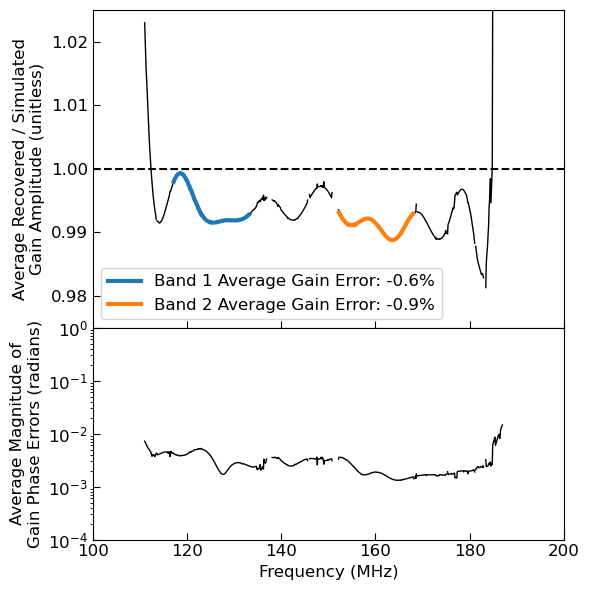

In [44]:
fig, ax = plt.subplots(2,1, figsize=(6,6), dpi=100, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios': [1.5,1]})

avg_amp_err = np.nanmean(list(avg_amplitude_ratio_smooth_over_true.values()), axis=0)
ax[0].plot(freqs/1e6, avg_amp_err, c='k', lw=1)
ax[0].plot(freqs[176:340]/1e6, avg_amp_err[176:340], c='C0', lw=3, label=f'Band 1 Average Gain Error: {(np.mean(avg_amp_err[176:340]) - 1):.1%}')
ax[0].plot(freqs[535:697]/1e6, avg_amp_err[535:697], c='C1', lw=3, label=f'Band 2 Average Gain Error: {(np.mean(avg_amp_err[535:697]) - 1):.1%}')

ax[0].set_ylabel('Average Recovered / Simulated\nGain Amplitude (unitless)', fontsize=12)
ax[0].axhline(1, c='k', ls='--')
ax[0].legend(fontsize=12)
ax[0].set_ylim([.975, 1.025])
ax[0].set_xlim([100, 200])
ax[0].tick_params(labelsize=12, direction='in', size=5)

ax[1].semilogy(freqs/1e6, np.nanmean(list(avg_phase_error_true.values()), axis=0), lw=1, c='k')


ax[1].set_ylabel('Average Magnitude of\nGain Phase Errors (radians)', fontsize=12)
ax[1].set_xlabel('Frequency (MHz)', fontsize=12)
ax[1].set_ylim([1e-4, 1])
ax[1].tick_params(labelsize=12, direction='in', size=5)

plt.tight_layout()
plt.savefig(f'validation_gain_errors.pdf', dpi=200, bbox_inches='tight')

In [45]:
with open('/lustre/aoc/projects/hera/Validation/test-4.1.0/h1c_idr3_validation_notebooks/lst_bin_inspect/calibration_bias_waterfalls.p', 'rb') as f:
    combined_dict = pickle.load(f)
JD = combined_dict['JD']
abs_ratio = combined_dict['abs_ratio']
smooth_ratio = combined_dict['smooth_ratio']
freqs = combined_dict['freqs']
time_grid = combined_dict['time_grid']

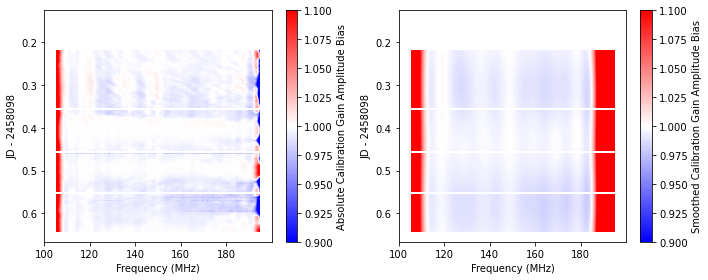

In [46]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(abs_ratio, aspect='auto', cmap='bwr',
           extent=[freqs[0]/1e6, freqs[-1]/1e6, time_grid[-1]-JD, time_grid[0]-JD])
plt.clim([.9,1.1])
plt.colorbar(label='Absolute Calibration Gain Amplitude Bias')
plt.xlabel('Frequency (MHz)')
plt.ylabel('JD - 2458098')

plt.subplot(122)
plt.imshow(smooth_ratio, aspect='auto', cmap='bwr',
           extent=[freqs[0]/1e6, freqs[-1]/1e6, time_grid[-1]-JD, time_grid[0]-JD])
plt.clim([.9,1.1])
plt.colorbar(label='Smoothed Calibration Gain Amplitude Bias')
plt.xlabel('Frequency (MHz)')
plt.ylabel('JD - 2458098')

plt.tight_layout()

In [47]:
eor_band_1 = hera_pspec.UVPSpec()
eor_band_2 = hera_pspec.UVPSpec()
true_sum_band_1 = hera_pspec.UVPSpec()
true_sum_band_2 = hera_pspec.UVPSpec()
# TODO: find a permanent home for these
eor_band_1.read_hdf5('/lustre/aoc/projects/hera/Validation/test-4.1.0/h1c_idr3_validation_notebooks/signal_loss/P_of_kt_eor_band_1.h5') 
eor_band_2.read_hdf5('/lustre/aoc/projects/hera/Validation/test-4.1.0/h1c_idr3_validation_notebooks/signal_loss/P_of_kt_eor_band_2.h5') 
true_sum_band_1.read_hdf5('/lustre/aoc/projects/hera/Validation/test-4.1.0/h1c_idr3_validation_notebooks/signal_loss/P_of_kt_true_sum_band_1.h5') 
true_sum_band_2.read_hdf5('/lustre/aoc/projects/hera/Validation/test-4.1.0/h1c_idr3_validation_notebooks/signal_loss/P_of_kt_true_sum_band_2.h5') 
lsts = np.load('/lustre/aoc/projects/hera/Validation/test-4.1.0/h1c_idr3_validation_notebooks/signal_loss/xtalk_test_lsts.npz')['lsts']

invalid value encountered in true_divide
All-NaN slice encountered


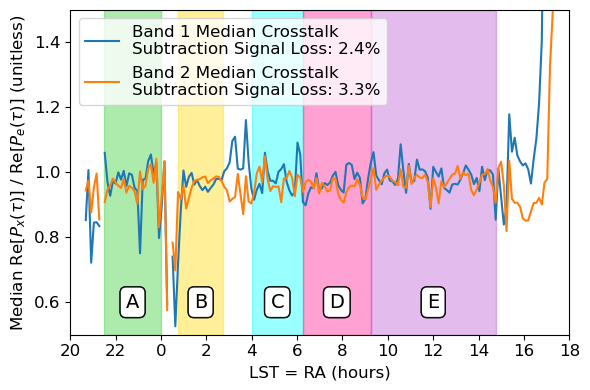

In [48]:
fig, ax = plt.subplots(1,1,figsize=(6,4), dpi=100, sharex=True, gridspec_kw={'hspace': 0})

for band, true_sum, eor, color in zip([1, 2], [true_sum_band_1, true_sum_band_2], [eor_band_1, eor_band_2], ['C0', 'C1']):
    ratio = np.real(np.squeeze(true_sum.data_array[0])) / np.real(np.squeeze(eor.data_array[0]))  
    subset = ratio[:, (eor.dly_array * 1e9 < 4000)]
    use_this_lst = np.zeros_like(lsts, dtype=bool)
    for field, (lc, c) in enumerate(zip(lstcuts, lst_colors)):
        use_this_lst[(lsts > lc[0]) & (lsts < lc[1])] = True
        ax.text(np.mean(lc), .6, f'{"ABCDEFGHIJ"[field]}', ha='center', va='center', fontsize=14, bbox=dict(facecolor='w', alpha=0.9, boxstyle='round'))
    ax.plot(lsts, np.nanmedian(subset, axis=1), c=color, 
            label=f'Band {band} Median Crosstalk\nSubtraction Signal Loss: {1 - np.nanmedian(subset[use_this_lst]):.1%}')
    
for lc, c in zip(lstcuts, lst_colors):
    ax.axvspan(lc[0], lc[1], color=c, alpha=.4)    
ax.set_ylim([.5, 1.5])
ax.set_xticks(np.arange(-6, 20, 2), fontsize=12)
ax.set_xlim([-4,18])
ax.set_xticklabels(np.arange(-6, 20, 2) % 24, fontsize=12)
plt.gca().tick_params(labelsize=12)
plt.xlabel('LST = RA (hours)', size=12)
plt.ylabel('Median Re$[P_{x}(\\tau)]$ / Re$[P_{e}(\\tau)]$ (unitless)', size=12)
plt.legend(fontsize=12, loc='upper left')
plt.tight_layout()
plt.savefig(f'validation_cross_talk_subtraction_signal_loss.pdf', dpi=200, bbox_inches='tight')

invalid value encountered in true_divide


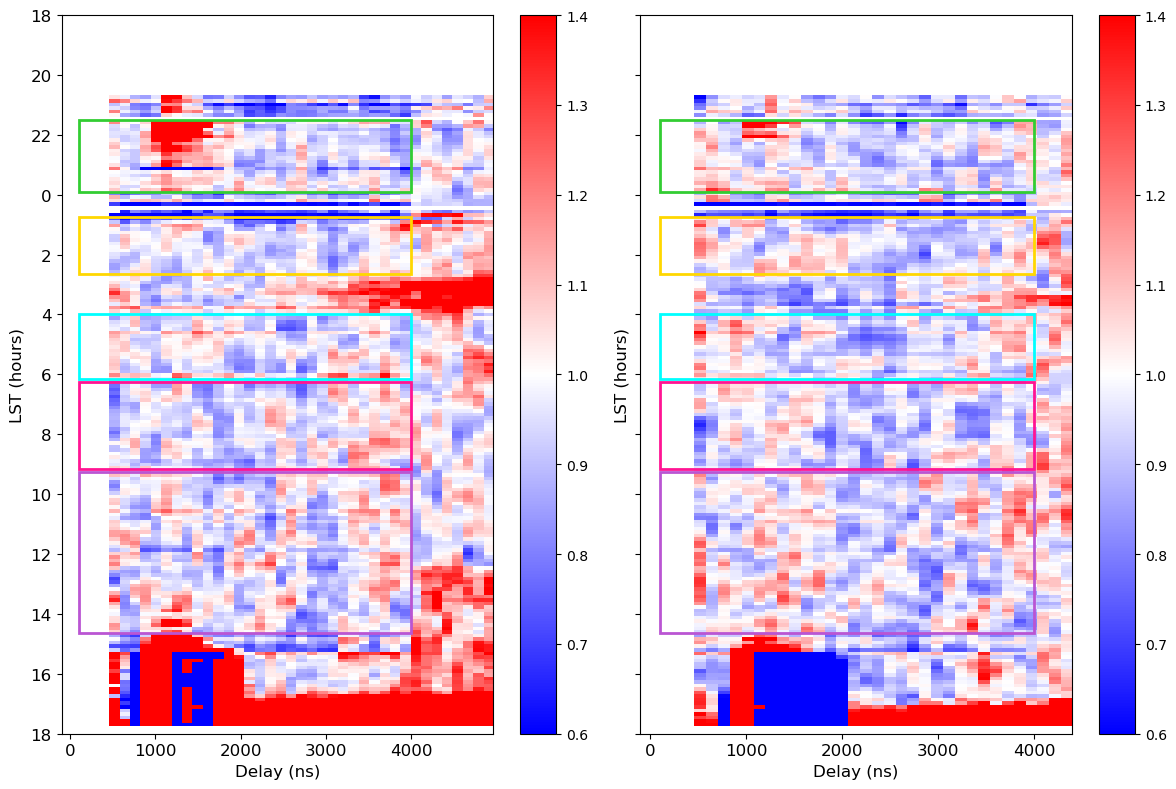

In [49]:
fix, axes = plt.subplots(1, 2,figsize=(12,8), dpi=100, sharey=True)
for ax, true_sum, eor in zip(axes, [true_sum_band_1, true_sum_band_2], [eor_band_1, eor_band_2]):

    extent = [eor.dly_array[0] * 1e9, eor.dly_array[-1] * 1e9, lsts[-1], lsts[0]]
    ratio = np.real(np.squeeze(true_sum.data_array[0])) / np.real(np.squeeze(eor.data_array[0]))
    im = ax.imshow(ratio, aspect='auto', interpolation='none', cmap='bwr', extent=extent, vmin=.6, vmax=1.4)
    plt.colorbar(im, ax=ax)
    for i, lc in enumerate(lstcuts):
        r = plt.Rectangle((110, lc[0]), 3890, lc[1]-lc[0]-.1, fc='None', ec=lst_colors[i], lw=2)
        ax.add_patch(r)
        
        subset = ratio[(lsts > lc[0]) & (lsts < lc[1])]
        subset = subset[:, (eor.dly_array * 1e9 < 4000)]
        ax.set_xlim(-100)
        ax.set_yticks(np.arange(-6, 20, 2))
        axes[0].set_yticklabels(np.arange(-6, 20, 2) % 24)
        ax.tick_params(labelsize=12)
        ax.set_xlabel('Delay (ns)', fontsize=12)
        ax.set_ylabel('LST (hours)', fontsize=12)        

plt.tight_layout()

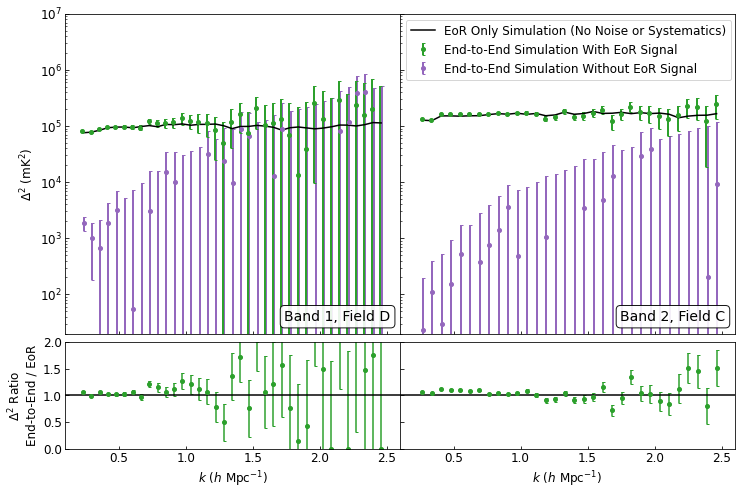

In [50]:
time_avg_bias = {1: 1.012, 2: 1.015}
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex='col', sharey='row', gridspec_kw={'hspace': .04, 'wspace': 0, 'height_ratios':[3,1]})
validation_notebooks_path = '/lustre/aoc/projects/hera/Validation/test-4.1.0/h1c_idr3_validation_notebooks/'

for ax, ax2, band, field in zip([axes[0][0], axes[0][1]], [axes[1][0], axes[1][1]], [1, 2], ['D', 'C']):
    
    uvp = hera_pspec.UVPSpec()
    uvp.read_hdf5(validation_notebooks_path + f'pspec_results/all_epochs/results_files/Deltasq_Band_{band}_Field_{field}.h5')
    
    uvp_fg_only = hera_pspec.UVPSpec()
    uvp_fg_only.read_hdf5(validation_notebooks_path + f'fg_only/pspec_results/all_epochs/results_files/Deltasq_Band_{band}_Field_{field}.h5')

    uvp_eor = hera_pspec.UVPSpec()
#     uvp_eor.read_hdf5(validation_notebooks_path + f'fg_only/pspec_results/all_epochs/results_files/Deltasq_Band_{band}_Field_{field}.h5')
    uvp_eor.read_hdf5(f'/lustre/aoc/projects/hera/Validation/test-4.1.0/h1c_idr3_validation_notebooks/signal_loss/EoR_TK_Deltasq_Band_{band}_Field_{field}.h5')
    
    for u, c, offset in zip([uvp_fg_only, uvp, uvp_eor], ['C4', 'C2', 'k'], [.005, -.005, 0]):
        kp = u.get_kparas(0)
        ks = slice(np.argmin(np.abs(kp - 0.128)), None, 1)
        y = u.data_array[0].real.squeeze().copy()[ks].copy()
        y[y < 0] *= 0
        kbins = u.get_kparas(0)
        k = kbins[ks]
        z = u.cosmo.f2z(np.mean(u.get_spw_ranges()[0][:2]))
        if u == uvp_eor:
            to_plot = np.real(y) > 0
            # EoR only hasn't had any bias correction applied
            ax.plot(k[to_plot] + offset, np.real(y)[to_plot] * time_avg_bias[band], '-', c=c, label='EoR Only Simulation (No Noise or Systematics)')
            eor_to_compare = copy.deepcopy(np.real(y)[to_plot])
        else:
            yerr = np.sqrt(u.cov_array_real[0].squeeze().diagonal())[ks]
            pn = u.stats_array['P_N'][0].real.squeeze()[ks]
            pn[pn <= 0] = np.nan
            if u == uvp:
                label = 'End-to-End Simulation With EoR Signal'
            else:
                label = 'End-to-End Simulation Without EoR Signal'
            p1 = ax.errorbar(k + offset, np.real(y), marker='o', ms=4, ls='', c=c, yerr=yerr * 2, lw=2, capsize=1.5, label=label)
            result_to_compare = copy.deepcopy(np.real(y))
            err_to_compare = copy.deepcopy(yerr)

#     A = {1: 4.803e7, 2: 7.79e7}
#     analytic_ks = np.arange(0, 3, .01)
#     Pk = A[band] * (analytic_ks / 0.295)**-2.7
#     ax.plot(analytic_ks, Pk * analytic_ks**3 / 2 / np.pi**2, 'k--', label='Input Analytic $\Delta^2(k) \propto k^{0.3}$')
    
    ax.text(2.53, 40, f'Band {band}, Field {field}', ha='right', va='center', fontsize=14, bbox=dict(facecolor='w', alpha=0.9, boxstyle='round'))
    
    ax.set_yscale('log')
    ax.set_xlim([.1, 2.6])
    ax.set_ylim(2e1, 1e7)
    
    ax2.set_xlabel(r'$k\ (h\ {\rm Mpc}^{-1}$)', fontsize=12)    
    ax2.errorbar(k[to_plot], result_to_compare[to_plot] / eor_to_compare, yerr=(err_to_compare[to_plot] / eor_to_compare),
                 marker='o', ms=4, ls='', capsize=1.5, c='C2')
    ax2.set_xlabel(r'$k\ (h\ {\rm Mpc}^{-1}$)', fontsize=12)
    ax2.set_ylim([0, 2])
    ax2.axhline(1, color='k')

for ax in axes.flatten():
    ax.tick_params(labelsize=12, direction='in', which='both')
    
axes[0][0].set_ylabel(r'$\Delta^2\ ({\rm mK}^2)$', fontsize=12) 
axes[1][0].set_ylabel('$\Delta^2$ Ratio\nEnd-to-End / EoR', fontsize=12) 

handles, labels = axes[0][1].get_legend_handles_labels()
order = [0,2,1]
# legend = axes[0][0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12, loc='upper left')
# handles, labels = axes[0][1].get_legend_handles_labels()
# order = [3, 2]
legend = axes[0][1].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12, loc='upper left')

plt.savefig(f'validation_end_to_end.pdf', bbox_inches='tight')

# Non-Redundancy Signal Loss

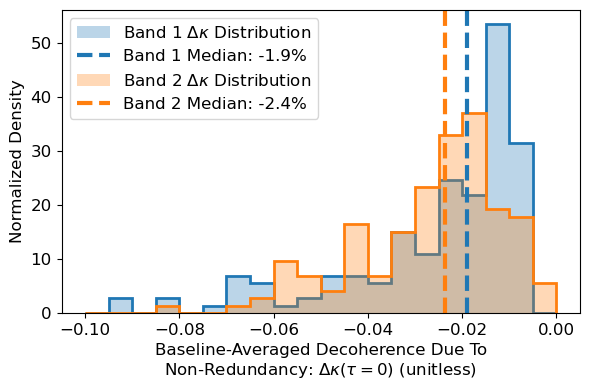

In [51]:
decorr_band_1, decorr_band_2 = np.load('decorrelation.npy')
decorr_band_1 = decorr_band_1[(decorr_band_1 != 0) & (np.isfinite(decorr_band_1))]
decorr_band_2 = decorr_band_2[(decorr_band_2 != 0) & (np.isfinite(decorr_band_2))]

plt.figure(figsize=(6,4), dpi=100)
bins = np.arange(-.1, 0.005, .005)
plt.hist(decorr_band_1, density=True, bins=bins, histtype='stepfilled', alpha=.3, color='C0', label='Band 1 $\Delta \kappa$ Distribution', zorder=1)
plt.hist(decorr_band_1, density=True, bins=bins, histtype='step', color='C0', lw=2, zorder=1)
plt.axvline(np.median(decorr_band_1), ls='--', lw=3, color='C0', label=f'Band 1 Median: {np.median(decorr_band_1):.1%}', zorder=2)

plt.hist(decorr_band_2, density=True, bins=bins, histtype='stepfilled', alpha=.3, color='C1', label='Band 2 $\Delta \kappa$ Distribution', zorder=1)
plt.hist(decorr_band_2, density=True, bins=bins, histtype='step', color='C1', lw=2, zorder=1)
plt.axvline(np.median(decorr_band_2), ls='--', lw=3, color='C1', label=f'Band 2 Median: {np.median(decorr_band_2):.1%}', zorder=2)

plt.legend(fontsize=12)

# plt.hist(decorr_band_2, density=True, bins=bins, histtype='stepfilled', alpha=.5, color='C1')
plt.xlabel('Baseline-Averaged Decoherence Due To\nNon-Redundancy: $\Delta \kappa (\\tau = 0)$ (unitless)', fontsize=12)
plt.ylabel('Normalized Density', fontsize=12)
plt.gca().tick_params(labelsize=12)#, direction='in', size=5)

plt.tight_layout()
plt.savefig(f'non_redundancy_decoherence.pdf', dpi=200, bbox_inches='tight')

# Power Spectrum Theory Constraints

## 21cmMC

invalid value encountered in reduce
invalid value encountered in reduce


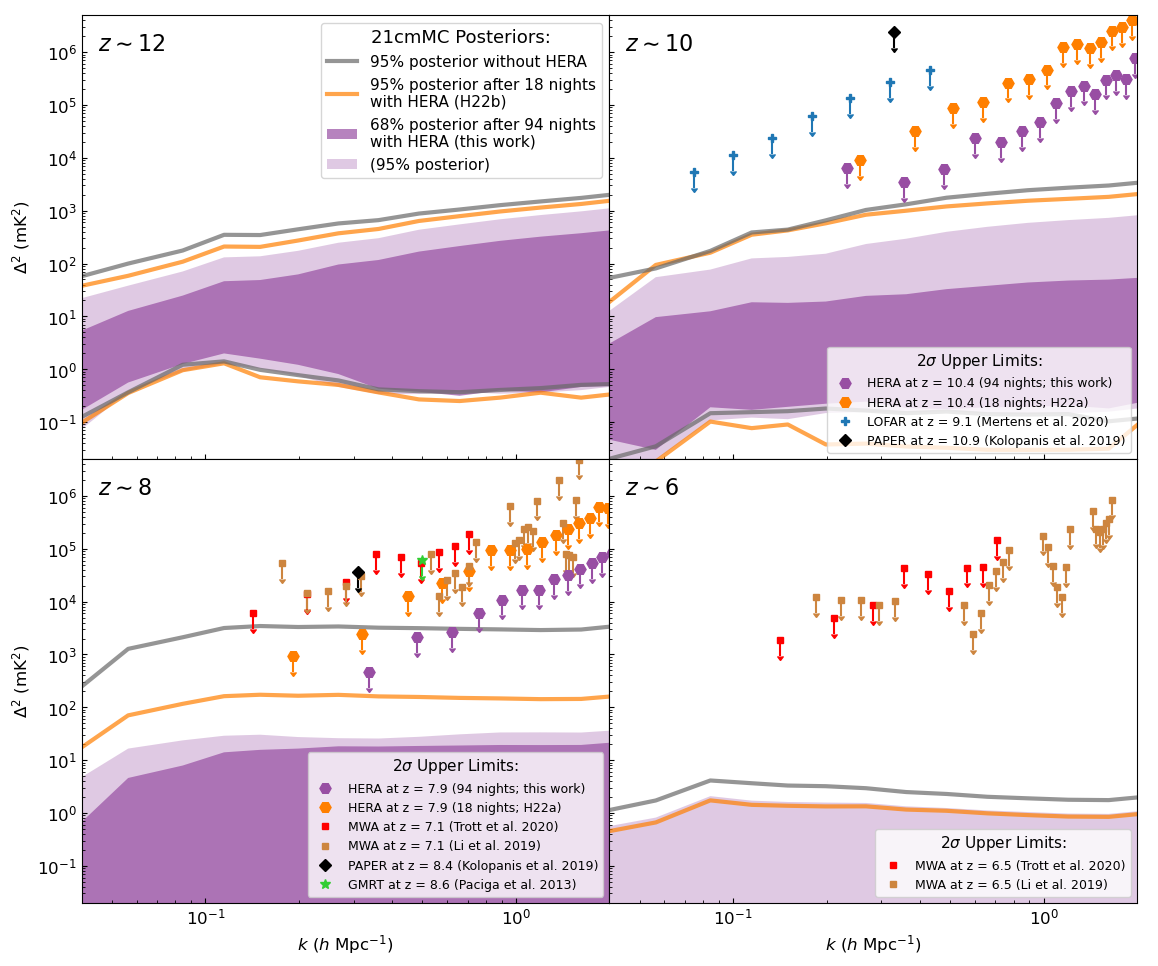

In [52]:
import eor_limits

cosmo = {'omega_M_0' : 0.307500,
'omega_lambda_0' : 0.6925,
'omega_b_0' : 0.0486,
'omega_n_0' : 0.0,
'N_nu' : 0,
'h' : 0.677400,
'n' : 0.97000,
'sigma_8' : 0.82
}

sim_names = ['normalL_HERA_update_H1C', 'normalL_HERA_update_morelivepts', 'normalL_noHERA', 'prior'] # need to change normalL_HERA_update_H1C (which uses 1e4 livepts) to sth like normalL_HERA_update_H1C_final_morelivepts (which uses 2e4 livepts as well and the finalized data from hera)
sim_labels = ['68% posterior after 94 nights\nwith HERA (this work)', 
              '95% posterior after 18 nights\nwith HERA (H22b)', 
              '95% posterior without HERA',
              '95% prior']
sim_labels_withdata = ['HERA (94 nights; this work)','HERA (18 nights; H22a)']
zs_PS = np.array([12.00443 , 10.32114 ,  7.926647,  5.90059 ])

# we have 84 snapshots in the model, we only use these snapshots, correpsonding to z=12, 10, 8 and 6
snapshots = [32,25,13,0] 

# these are the wavenumbers for our model
ks = np.array([0.02513274, 0.03820577, 0.05725007, 0.07778031, 0.101638  ,
       0.1347107 , 0.1815186 , 0.2444601 , 0.3299734 , 0.4460977 ,
       0.6021986 , 0.8131821 , 1.097917  , 1.480195  , 1.920623  ,
       2.388536  ]) / cosmo['h']

# This is what I got before from you before and used in the inference
# their structure is [#field, #k mode, {k, power(negative values have been set to 0), sigma, power+2sigma}]
hera_final_band1 = np.load('power_spectrum_posterior/joshdata_band1.npy') 
hera_final_band2 = np.load('power_spectrum_posterior/joshdata_band2.npy')

xlim = [4e-2,2]
ylim = [2e-2,5e6]

fig, axsPS = plt.subplots(2,2,figsize=(12, 10), dpi=100, sharex=True, sharey=True, gridspec_kw=dict(hspace=0, wspace=0))
axsPS = axsPS.flatten()

# first plot the two posteriors
for kk, sim_name in enumerate(sim_names[0:3]):
    
    color = ['#984ea3','#ff7f00', 'dimgrey', 'k'][kk]
    
    for ii in range(len(snapshots)):
        if ii==0:
            label=sim_labels[kk]
        else:
            label=None
         
        #low, high, low2, high2 are 1 sigma range and 2 sigma range calcualted using highest posterior density (HPD)
        low = np.load('power_spectrum_posterior/ps_%s_z%s_low.npy'%(sim_name, ("%.1f"%zs_PS[ii]).replace('.','pt')))
        low2 = np.load('power_spectrum_posterior/ps_%s_z%s_low2.npy'%(sim_name, ("%.1f"%zs_PS[ii]).replace('.','pt')))
        high = np.load('power_spectrum_posterior/ps_%s_z%s_high.npy'%(sim_name, ("%.1f"%zs_PS[ii]).replace('.','pt')))
        high2 = np.load('power_spectrum_posterior/ps_%s_z%s_high2.npy'%(sim_name, ("%.1f"%zs_PS[ii]).replace('.','pt')))        
        
        
        if kk>=1:
            axsPS[ii].plot(ks , low2,color=color,alpha=0.7,lw=3,label=label)
            axsPS[ii].plot(ks, high2,color=color,alpha=0.7, lw=3)
#             axsPS[ii].plot(ks , low,color=color,alpha=0.7,lw=3,label=label)
#             axsPS[ii].plot(ks, high,color=color,alpha=0.7, lw=3)
#             axsPS[ii].plot(ks, low2,color=color,alpha=0.7,lw=1, label=('(95% posterior)' if ii == 0 else None))
#             axsPS[ii].plot(ks, high2,color=color,alpha=0.7, lw=1)
        else:
            axsPS[ii].fill_between(ks, low, high,color=color,alpha=0.7,label=label, edgecolor=None)
            axsPS[ii].fill_between(ks, low2, high2,color=color,alpha=0.3,label=('(95% posterior)' if ii == 0 else None), edgecolor=None)
        
########## HERA #############

for hera_final, redshift, axP in zip([hera_final_band1, hera_final_band2], [10.4,7.9], [axsPS[1],axsPS[2]]):
    
    
    for ik in range(len(hera_final[0,:,0])):
        if redshift==7.9:
            if ik % 2 == 0:
                continue
        if redshift==10.4:
            if ik % 2 == 1:
                continue
        
        # for each k, I'm looking for the lowest limit (as in power+2sigma)
        ifield = np.argmin(hera_final[:,ik,-1])
        hera_k = hera_final[ifield,ik,0]
        hera_p = max(0, hera_final[ifield,ik,1])
        hera_ul = hera_final[ifield,ik,-1]
        
        eb = axP.errorbar(hera_k, hera_ul, yerr=[[0.5*hera_ul], [0]], uplims=True, alpha=1, c='#984ea3', ls='', ms=8, marker='H', 
                          label=(sim_labels_withdata[0].replace('HERA', f'HERA at z = {redshift}') if ik <= 1 else None))
        for cap in eb[1]:
            cap.set_markersize(4)

    # these are limits used in H22b
    k_limit_vals  = np.fromfile(f'power_spectrum_posterior/HERA_Phase1_Limits/PS_limit_ks_z{int(np.round(redshift))}.bin') / cosmo['h']
    PS_limit_vals = np.fromfile(f'power_spectrum_posterior/HERA_Phase1_Limits/PS_limit_vals_z{int(np.round(redshift))}.bin')
    PS_limit_vars = np.fromfile(f'power_spectrum_posterior/HERA_Phase1_Limits/PS_limit_vars_z{int(np.round(redshift))}.bin')
    PS_upper_limits = PS_limit_vals + 2 * PS_limit_vars**.5 

    eb = axP.errorbar(k_limit_vals, PS_upper_limits, yerr=np.array([PS_upper_limits * .5, np.zeros_like(PS_upper_limits)]), 
                      uplims=True, alpha=1, c='#ff7f00', ls='', ms=8, marker='H', label=sim_labels_withdata[1].replace('HERA', f'HERA at z = {redshift}'))    
    
    for cap in eb[1]:
        cap.set_markersize(4)

# ########## PLOT OTHER TELESCOPES #############

def plot_paper(yaml_name, c=None, marker=None, ms=None, ex_z=[], alpha=1):
    limit_data = eor_limits.plot_eor_limits.read_data_yaml(yaml_name)
    if len(limit_data['redshift']) == 1 and len(limit_data['redshift']) != len(limit_data['k']):
        uls = [limit_data['delta_squared']]
        ks = [limit_data['k']]
    else:
        uls = limit_data['delta_squared']
        ks = limit_data['k']
        
    for z, ul, k in zip(limit_data['redshift'], uls, ks):
        if isinstance(z, list):
            z = z[0]
        if z in ex_z:
            continue            
        ax = axsPS[int(np.round((12 - z) / 2))]
        label=f'{limit_data["telescope"]} at z = {z:.1f} ({limit_data["author"]} et al. {limit_data["year"]})'.replace(' phase II', '').replace(' phase I', '')
        if isinstance(ul, list) and len(ul) > 1:
            yerr=np.array([np.array(ul) * .5, np.zeros_like(ul)])
        else:
            yerr=np.array([[ul * .5], [0]])
        eb = ax.errorbar(k, ul, yerr=yerr, uplims=True, alpha=alpha, c=c, ls='', ms=ms, marker=marker, label=label)
        for cap in eb[1]:
            cap.set_markersize(4)
        

plot_paper('mertens_2020', c='C0', marker='P', ms=6)
# plot_paper('patil_2017', c='C0', marker='d', ms=6)
# plot_paper('rahimi_2021', c='#7f0000', marker='s', ms=5, ex_z=[6.8])
plot_paper('trott_2020', c='red', marker='s', ms=5, ex_z=[6.8, 7.8, 8.2, 8.7])
plot_paper('li_2019', c='peru', marker='s', ms=5, ex_z=[6.8])
plot_paper('kolopanis_2019', c='k', marker='D', ms=6, ex_z=[7.49, 8.13, 8.68, 9.93])
plot_paper('paciga_2013', c='limegreen', marker='*', ms=7)


########## Style #############

for ii, zcent in enumerate(zs_PS):
    axsPS[ii].text(0.03, 0.96, r'$z{\sim}%d$'%round(zs_PS[ii]),horizontalalignment='left',verticalalignment='top',
                    transform=axsPS[ii].transAxes,fontsize = 16)
    axsPS[ii].grid(False)       
    axsPS[ii].set_xscale('log')
    axsPS[ii].set_yscale('log')
    axsPS[ii].set_xlim(xlim)
    axsPS[ii].set_ylim(ylim)

handles, labels = axsPS[0].get_legend_handles_labels()
order = [3,2,0,1]
axsPS[0].legend([handles[idx] for idx in order], [labels[idx] for idx in order],
                loc='upper right',ncol=1, fontsize=11, title='21cmMC Posteriors:', title_fontsize=13)#, bbox_to_anchor=(1.0, 0.85))



for ax in axsPS[1:]:
    handles, labels = ax.get_legend_handles_labels()
    handles = [h[0] if isinstance(h, container.ErrorbarContainer) else h for h in handles]
    ax.legend(handles, labels,loc='lower right', fontsize=9, title='2$\sigma$ Upper Limits:',  title_fontsize=11)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)

axsPS[0].set_ylabel(r'$\Delta^2\ ({\rm mK}^2)$', fontsize=12)
axsPS[2].set_xlabel(r'$k\ (h\ {\rm Mpc}^{-1}$)', fontsize=12)
axsPS[2].set_ylabel(r'$\Delta^2\ ({\rm mK}^2)$', fontsize=12)
axsPS[3].set_xlabel(r'$k\ (h\ {\rm Mpc}^{-1}$)', fontsize=12)

for ax in axsPS:
    ax.tick_params(labelsize=12, direction='in', which='both')

plt.tight_layout()
plt.savefig('power_spectrum_posteriors.pdf', bbox_inches="tight")

In [53]:
lss        = ['-', '--']
lws        = [3, 3]
colors     = ['#984ea3','#ff7f00']
sim_names  = ['normalL_HERA_update_H1C','normalL_HERA_update_morelivepts'] # need to change normalL_HERA_update_H1C (which uses 1e4 livepts) to sth like normalL_HERA_update_H1C_final_morelivepts (which uses 2e4 livepts as well and the finalized data from hera)
sim_labels = ['21cmMC Posterior after 94 nights\nwith HERA (this work)','21cmMC Posterior after 18 nights\nwith HERA (H22b)']
sim_labels_withdata = ['94 nights with HERA (this work)','18 nights with HERA (H22b)']
sim_labels_lx = ['94 nights (this work)','18 nights (H22b)']

In [54]:
def _function(data, volume, bins, range=None, poisson_uncert=False,
                return_edges=False, weights=None, density=None):
    if weights is not None:
        weights = weights[(~np.isnan(data)) & (~np.isinf(data))]
    data = data[(~np.isnan(data)) & (~np.isinf(data))]
    if (range is not None and (bins in ['blocks',
                                        'knuth', 'knuths',
                                        'scott', 'scotts',
                                        'freedman', 'freedmans'])):
        if weights is not None:
            weights = weights[(data >=range[0]) & (data <= range[1])]
        data = data[(data >=range[0]) & (data <= range[1])]

    if isinstance(bins, str):
        log.info("Calculating bin widths using `%s' method..." % bins)
        if bins in ['blocks']:
            bins = bayesian_blocks(data)
        elif bins in ['knuth', 'knuths']:
            dm, bins = knuth_bin_width(data, True)
        elif bins in ['scott', 'scotts']:
            dm, bins = scotts_bin_width(data, True)
        elif bins in ['freedman', 'freedmans']:
            dm, bins = freedman_bin_width(data, True)
        else:
            raise ValueError("unrecognized bin code: '%s'" % bins)
        log.info("...done")

    vals, edges = np.histogram(data, bins, range,  weights=weights, density=density)
    width = edges[1]-edges[0]
    radius = width/2.0
    centers = edges[:-1]+radius
    if poisson_uncert:
        number, edges = np.histogram(data, bins, range,  weights=None, density=density)
        uncert = vals/np.sqrt(number.astype(float))

    vals = vals.astype(float) / (volume * width)

    if not poisson_uncert:
        results = np.dstack((centers, vals)).squeeze()
    else:
        uncert /= (volume * width)
        results = np.dstack((centers, vals, uncert)).squeeze()

    if not return_edges:
        return results
    else:
        return results, edges
    
def calc_min_interval(x, alpha):
    """Internal method to determine the minimum interval of a given width
    Assumes that x is sorted numpy array.
    """

    n = len(x)
    cred_mass = 1.0-alpha

    interval_idx_inc = int(np.floor(cred_mass*n))
    n_intervals = n - interval_idx_inc
    interval_width = x[interval_idx_inc:] - x[:n_intervals]

    if len(interval_width) == 0:
        raise ValueError('Too few elements for interval calculation')

    min_idx = np.argmin(interval_width)
    hdi_min = x[min_idx]
    hdi_max = x[min_idx+interval_idx_inc]
    return hdi_min, hdi_max


def hpd(x, alpha=0.05):
    """Calculate highest posterior density (HPD) of array for given alpha. 
    The HPD is the minimum width Bayesian credible interval (BCI).
    :Arguments:
        x : Numpy array
        An array containing MCMC samples
        alpha : float
        Desired probability of type I error (defaults to 0.05)
    """

    # Make a copy of trace
    x = x.copy()
    # For multivariate node
    if x.ndim > 1:
        # Transpose first, then sort
        tx = np.transpose(x, list(range(x.ndim))[1:]+[0])
        dims = np.shape(tx)
        # Container list for intervals
        intervals = np.resize(0.0, dims[:-1]+(2,))

        for index in make_indices(dims[:-1]):
            try:
                index = tuple(index)
            except TypeError:
                pass

            # Sort trace
            sx = np.sort(tx[index])
            # Append to list
            intervals[index] = calc_min_interval(sx, alpha)
        # Transpose back before returning
        return np.array(intervals)
    else:
        # Sort univariate node
        sx = np.sort(x)
        return np.array(calc_min_interval(sx, alpha))

Prior Tk [  2.24481589 656.37238273   2.34261606   8.84647766] 9710
Prior Ts [  2.48513679 490.93420191   3.10517677  24.18525972] 9710
normalL_noHERA Tk [  2.31442992 179.12343687   2.35713406  10.71345248] 106658
normalL_noHERA Ts [  2.90813955 122.99322288   2.93450152  14.39936958] 106658
normalL_HERA_update_morelivepts Tk [  2.37544117 242.53252948   2.44393938  26.18005157] 109004
normalL_HERA_update_morelivepts Ts [  3.14981683 142.82513268   3.24924131  32.68302727] 109004
normalL_HERA_update_H1C Tk [  3.1929947  313.21039275   3.99412561  59.93448608] 57367
normalL_HERA_update_H1C Ts [  4.72071187 171.19165964   7.85156912  84.73294397] 57367
Prior Tk [1.30700681e+00 4.01192900e+03 1.30700681e+00 4.37327568e+01] 9710
Prior Ts [1.56032610e+00 1.68996500e+03 1.70611155e+00 4.80601289e+01] 9710
normalL_noHERA Tk [1.31075035e+00 1.94333500e+03 1.35256079e+00 7.06507101e+01] 106658
normalL_noHERA Ts [  1.52560196 520.30817435   1.48312162  76.7430965 ] 106658
normalL_HERA_update_mo

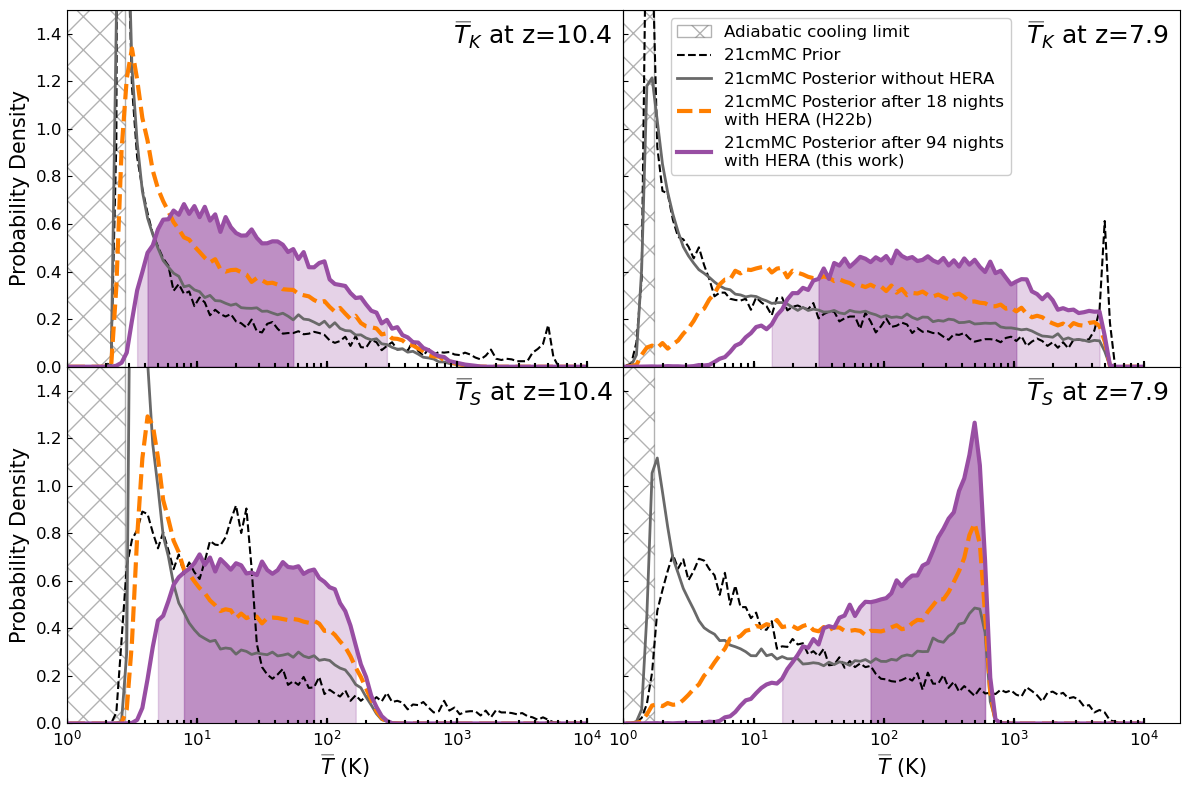

In [55]:
xmin=0
xmax=np.log10(1.9e4)
ymin=0
ymax=1.5

fig, axss= plt.subplots(2,2,figsize=(12,8), sharex=True, sharey=True, dpi=100, gridspec_kw={'hspace': 0, 'wspace': 0})
    
models2plot = ['Prior', 'normalL_noHERA']+sim_names[::-1]
colors2plot = [ 'k', 'dimgrey'] + colors[::-1]
lws2plot = [1.5, 2] + lws[::-1]
lss2plot = ['--', '-'] + lss[::-1]
sim_labels2plot = ['21cmMC Prior', '21cmMC Posterior without HERA'] + sim_labels[::-1]

z_HERAs = [10.37213048494136, 7.928762977434008]
Tadiabs = [2.79, 1.72]

for iz, z_HERA in enumerate(z_HERAs):
    axs= axss[:,iz]
    
    for ii, sim_name in enumerate(models2plot):
        for jj, temp in enumerate(['Tk', 'Ts']):
            Tz = np.log10(np.load('21cmMC_PDFs/%s_%s_z%d.npy'%(sim_name, temp, np.round(z_HERA))))

            f = _function(Tz, volume=len(Tz), range=(0,4), bins=100)
            axs[jj].plot(f[:,0], f[:,1], lw=lws2plot[ii], c=colors2plot[ii], label=sim_labels2plot[ii], ls=lss2plot[ii])

            low2, high2, = (hpd(Tz))
            low, high, =(hpd(Tz, alpha=0.32))

            print(sim_name, temp, 10**np.array([low2, high2, low, high]),len(Tz))

            if sim_name == 'normalL_HERA_update_H1C':
                range_flag = (f[:,0]>low)*(f[:,0]<high)
                axs[jj].fill_between(f[:,0][range_flag], np.zeros_like(f[:,0][range_flag]), f[:,1][range_flag], color=colors2plot[ii],alpha=0.5)
                range_flag = (f[:,0]>low2)*(f[:,0]<high2)
                axs[jj].fill_between(f[:,0][range_flag], np.zeros_like(f[:,0][range_flag]), f[:,1][range_flag], color=colors2plot[ii],alpha=0.25)


    for ax in axs:
        ax.axvspan(xmin,np.log10(Tadiabs[iz]),facecolor="none", hatch="\\/", edgecolor="k",alpha=0.3,label='Adiabatic cooling limit')
        ax.grid(False)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        for i in np.log10(np.linspace(0.1,1,10)):
            ax.plot([i,i],[ymin,0.01], 'k-')
        for i in np.log10(np.linspace(1,10,10)):
            ax.plot([i,i],[ymin,0.01], 'k-')
        for i in np.log10(np.linspace(10,100,10)):
            ax.plot([i,i],[ymin,0.01], 'k-')
        for i in np.log10(np.linspace(100,1000,10)):
            ax.plot([i,i],[ymin,0.01], 'k-')
        for i in np.log10(np.linspace(1000,10000,10)):
            ax.plot([i,i],[ymin,0.01], 'k-')
        for i in np.log10([1,10,100,1000,10000]):
            ax.plot([i,i],[ymin,0.02], 'k-')
            
        ax.tick_params(labelsize=12, direction='in')

    axs[-1].set_xlabel(r'$\widebar{T}$ (K)', fontsize=15)
    axs[-1].set_xticks([0,1,2,3,4])
    axs[-1].set_xticklabels([r'$10^0$',r'$10^1$',r'$10^2$',r'$10^3$',r'$10^4$'], fontsize=12)
    axs[-1].set_ylim(ymin,ymax)
    axs[-1].set_xlim(xmin,xmax)
    
    
   
    if iz==0:
        axs[1].set_ylabel('Probability Density', fontsize=15)
        axs[0].set_ylabel('Probability Density', fontsize=15)

    axs[1].text(0.98,0.97, r"$\widebar{T}_{S}$"+" at z=%.1f"%z_HERA,horizontalalignment='right',\
                          verticalalignment='top',transform=axs[1].transAxes,fontsize=18)
    axs[0].text(0.98,0.97, r"$\widebar{T}_{K}$"+" at z=%.1f"%z_HERA,horizontalalignment='right',\
                          verticalalignment='top',transform=axs[0].transAxes,fontsize=18)


handles, labels_t = plt.gca().get_legend_handles_labels()
order = list(range(-1,4))
axs[0].legend([handles[idx] for idx in order],[labels_t[idx] for idx in order],
              loc='upper left', fontsize=12,framealpha=1, bbox_to_anchor=(0.07, 1.0))

plt.tight_layout()
plt.savefig('igm_tkts.pdf', bbox_inches = "tight")

Prior 38.014106035232544 41.810526609420776 38.068788290023804 40.781920433044434
normalL_noHERA 38.11386259865383 41.84273927416925 38.32645756033751 40.88202903800805
normalL_HERA_update_morelivepts 39.16508028215717 41.99986485621911 39.864495517049846 41.662169289939165
normalL_HERA_update_H1C 39.8715383120018 41.99951821165027 40.44308148171481 41.76402584924033


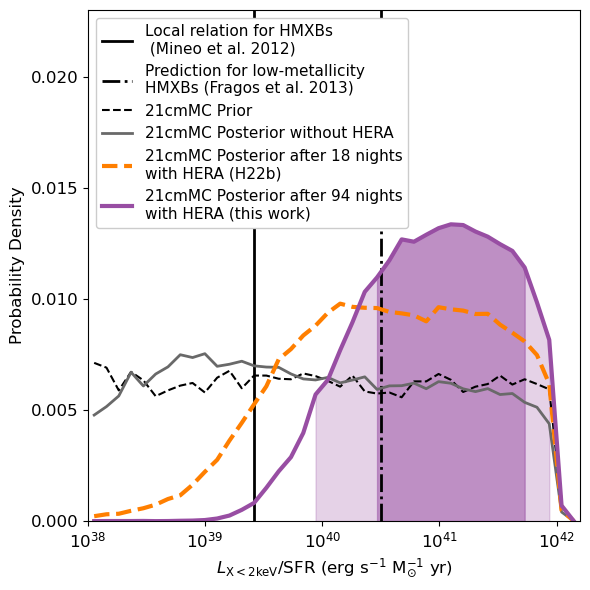

In [56]:
plot_limits = [38, 42.2]
fig, ax = plt.subplots(1,1,figsize=(6,6), dpi=100)
ax.grid(False)
ax.axvline(np.log10(2.61)+39, linestyle='-',color='black', lw=2, label='Local relation for HMXBs\n (Mineo et al. 2012)')
ax.axvline(40.5, linestyle='-.',color='black', lw=2, label='Prediction for low-metallicity\nHMXBs (Fragos et al. 2013)')

models2plot = ['Prior', 'normalL_noHERA']+sim_names[::-1]
colors2plot = [ 'k', 'dimgrey'] + colors[::-1]
lws2plot = [1.5, 2] + lws[::-1]
lss2plot = ['--', '-'] + lss[::-1]
sim_labels2plot = ['21cmMC Prior', '21cmMC Posterior without HERA'] + sim_labels[::-1]

for kk, sim_name in enumerate(models2plot):
    
    try:
        plot_data = np.load('21cmMC_PDFs/%s_LxSFR.npy'%(sim_name))
    except:
        print('missing 21cmMC_PDFs/%s_LxSFR.npy'%(sim_name))
        continue
    f = _function(plot_data, volume=sum(plot_data), range=plot_limits, bins=40)
    low2, high2, = hpd(plot_data)
    low, high, = hpd(plot_data, alpha=0.32)
    print(sim_name, low2, high2, low, high)
    
    ax.plot(f[:,0], f[:,1], color=colors2plot[kk],lw=lws2plot[kk], ls=lss2plot[kk], label=sim_labels2plot[kk])
    if sim_name == 'normalL_HERA_update_H1C':
        range_flag = (f[:,0]>low)*(f[:,0]<high)
        ax.fill_between(f[:,0][range_flag], np.zeros_like(f[:,0][range_flag]), f[:,1][range_flag], color=colors2plot[kk],alpha=0.5)
        range_flag = (f[:,0]>low2)*(f[:,0]<high2)
        ax.fill_between(f[:,0][range_flag], np.zeros_like(f[:,0][range_flag]), f[:,1][range_flag], color=colors2plot[kk],alpha=0.25)

ax.tick_params(labelsize=12)
ax.set_xlabel(r"$L_{\rm X<2keV}/{\rm SFR}}$ $({{\rm erg\ s^{-1}\ M_{\odot}^{-1}\ yr}})$", fontsize=12)
ax.set_ylabel('Probability Density', fontsize=12)
ax.legend(loc=2,framealpha=1.,fontsize=11)
#ax.text(0.98,0.98, "z=%.1f"%z_HERA,horizontalalignment='right',\
#                  verticalalignment='top',transform=ax.transAxes,fontsize=15)
ax.set_xlim(plot_limits[0], plot_limits[1])
ax.set_ylim(0,0.023)
ax.set_xticks([38, 39, 40, 41, 42], ['$10^{{38}}$', '$10^{{39}}$', '$10^{{40}}$', '$10^{{41}}$', '$10^{{42}}$'])
plt.tight_layout()
plt.savefig('Lx_SFR.pdf', bbox_inches = "tight")

In [57]:
lss        = ['-', '--']
lws        = [3, 3]
colors     = ['#984ea3','#ff7f00']
sim_names  = ['normalL_HERA_update_H1C','normalL_HERA_update_morelivepts'] # need to change normalL_HERA_update_H1C (which uses 1e4 livepts) to sth like normalL_HERA_update_H1C_final_morelivepts (which uses 2e4 livepts as well and the finalized data from hera)
sim_labels = ['Posterior after 94 nights\nwith HERA (this work)','Posterior after 18 nights\nwith HERA (H22b)']
sim_labels_withdata = ['94 nights with HERA (this work)','18 nights with HERA (H22b)']
sim_labels_lx = ['94 nights (this work)','18 nights (H22b)']

In [58]:
def _function(data, volume, bins, range=None, poisson_uncert=False,
                return_edges=False, weights=None, density=None):
    if weights is not None:
        weights = weights[(~np.isnan(data)) & (~np.isinf(data))]
    data = data[(~np.isnan(data)) & (~np.isinf(data))]
    if (range is not None and (bins in ['blocks',
                                        'knuth', 'knuths',
                                        'scott', 'scotts',
                                        'freedman', 'freedmans'])):
        if weights is not None:
            weights = weights[(data >=range[0]) & (data <= range[1])]
        data = data[(data >=range[0]) & (data <= range[1])]

    if isinstance(bins, str):
        log.info("Calculating bin widths using `%s' method..." % bins)
        if bins in ['blocks']:
            bins = bayesian_blocks(data)
        elif bins in ['knuth', 'knuths']:
            dm, bins = knuth_bin_width(data, True)
        elif bins in ['scott', 'scotts']:
            dm, bins = scotts_bin_width(data, True)
        elif bins in ['freedman', 'freedmans']:
            dm, bins = freedman_bin_width(data, True)
        else:
            raise ValueError("unrecognized bin code: '%s'" % bins)
        log.info("...done")

    vals, edges = np.histogram(data, bins, range,  weights=weights, density=density)
    width = edges[1]-edges[0]
    radius = width/2.0
    centers = edges[:-1]+radius
    if poisson_uncert:
        number, edges = np.histogram(data, bins, range,  weights=None, density=density)
        uncert = vals/np.sqrt(number.astype(float))

    vals = vals.astype(float) / (volume * width)

    if not poisson_uncert:
        results = np.dstack((centers, vals)).squeeze()
    else:
        uncert /= (volume * width)
        results = np.dstack((centers, vals, uncert)).squeeze()

    if not return_edges:
        return results
    else:
        return results, edges

In [59]:
uvp_xtk_dsq_1 = []
uvp_xtk_dsq_2 = []
for field in 'ABCDE':
    uvp = hera_pspec.UVPSpec()
    uvp.read_hdf5(f'../All_Epochs_Power_Spectra/results_files/Deltasq_Band_1_Field_{field}.h5')
    uvp_xtk_dsq_1.append(uvp)
    
    uvp = hera_pspec.UVPSpec()
    uvp.read_hdf5(f'../All_Epochs_Power_Spectra/results_files/Deltasq_Band_2_Field_{field}.h5')
    uvp_xtk_dsq_2.append(uvp)
    

divide by zero encountered in log10
invalid value encountered in subtract
divide by zero encountered in true_divide
invalid value encountered in true_divide
FixedFormatter should only be used together with FixedLocator


normalL_HERA_update_H1C -0.07687686056454479 2.832860850049808 0.6025042984147831 2.184963638503498
normalL_HERA_update_H1C -0.5277799860228022 1.5534449477743681 0.9439860017454977 1.4730303441649732


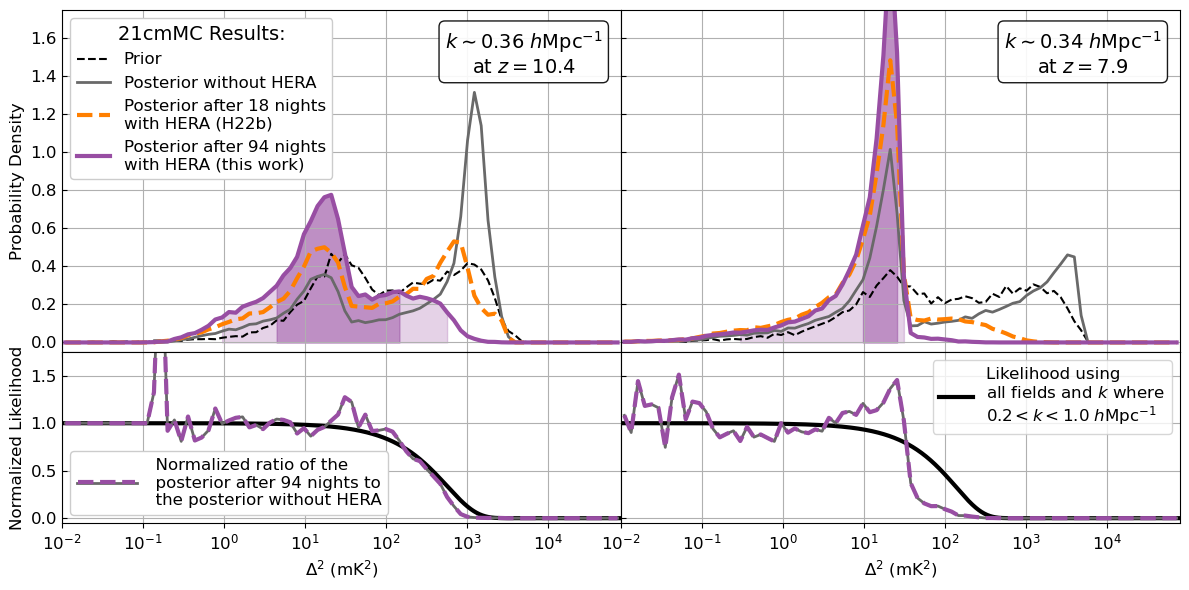

In [60]:

xlim = (-2, 4.9)

fig, axes = plt.subplots(2, 2, figsize=(12,6), sharex=True, sharey=False, gridspec_kw={'hspace': 0.0, 'wspace': 0, 'height_ratios': [2,1]}, dpi=100)

for spw in [0, 1]:

    xs = np.logspace(xlim[0], xlim[1], 1000)
    uvp_xtk_dsq = [uvp_xtk_dsq_1, uvp_xtk_dsq_2][spw]
    i = 0 #spw
    field_groups = [[0, 1, 2, 3, 4]]#[[0], [1], [2], [3], [4], [0, 1, 2, 3, 4]]
    for fg in field_groups:
        for kidx, krange in enumerate([[.2,1]]):#, [.3, .4]]):
            likelihood = np.ones_like(xs)
            for field in fg:

                ks = uvp_xtk_dsq[field].get_kparas(i)
                deltasq = uvp_xtk_dsq[field].data_array[i].squeeze().copy().real
                deltasq_err = np.sqrt(uvp_xtk_dsq[field].cov_array_real[i].squeeze().diagonal())

                xs = np.logspace(-2, 4.9, 1000)
                for ik, (k, dsq, dsqerr) in enumerate(zip(ks, deltasq, deltasq_err)):
                    if spw==1:
                        if ik % 2 == 1:
                            continue
                    if spw == 0:
                        if ik % 2 == 0:
                            continue            

                    if dsqerr > 0 and k > krange[0] and k < krange[1]:
                        likelihood *= (0.5 * (1 + special.erf(((dsq if dsq > 0 else 0) - xs) / np.sqrt(2) / dsqerr)))

            if len(fg) == 1:
                axes[-1][spw].plot(np.log10(xs), likelihood / np.max(likelihood), ['--', '--'][kidx], lw=1, c=lst_colors[fg[0]],
                                  label=(f'Field {"ABCDE"[fg[0]]}' if kidx==0 else None))  
            else:
                af = axes[-1][spw].plot(np.log10(xs), likelihood / np.max(likelihood), ['-', '--'][kidx], lw=3, c=['k','k'][spw],
                                        label=(f'All Fields' if kidx==0 else None))
    axes[-1][spw].set_ylim([-.05, 1.75])
    
    if spw == 1:
        axes[-1][spw].legend(af, ['Likelihood using\nall fields and $k$ where\n$0.2 < k < 1.0$ $h{{\\rm Mpc}}^{{-1}}$'], fontsize=12)
#     if spw == 1:
#         leg=axes[-1][spw].legend(fontsize=12, loc='upper right', framealpha=1, title=f'Likelihoods (All $k < 1$ $h{{\\rm Mpc}}^{{-1}}$)', ncol=2)
#         plt.setp(leg.get_title(),fontsize=14)
#         axes[-1][spw].add_artist(leg)

    
cosmo = {'omega_M_0' : 0.307500,
'omega_lambda_0' : 0.6925,
'omega_b_0' : 0.0486,
'omega_n_0' : 0.0,
'N_nu' : 0,
'h' : 0.677400,
'n' : 0.97000,
'sigma_8' : 0.82
}


indices_k = [1, 0]
fields = ['D', 'C']
models2plot = ['Prior', 'normalL_noHERA']+sim_names[::-1]
colors2plot = ['k', 'dimgrey'] + colors[::-1]
lws2plot = [1.5, 2] + lws[::-1]
lss2plot = ['--', '-'] + lss[::-1]
sim_labels2plot = ['Prior', 'Posterior without HERA'] + sim_labels[::-1]

z_HERAs = [10.37213048494136, 7.928762977434008]
ks = np.load('21cmMC_PDFs/ks.npy')    
    
for col, ax, redshift, index_k, field in zip([0, 1], axes[0], np.round(z_HERAs), indices_k, fields):
        
    # show the measurements
    k_start = np.fromfile('21cmMC_PDFs/HERA_H1C_Limits/%s/k_start_z%d.bin'%(field, redshift), dtype=int)[0]
    kwf_limit_vals = np.fromfile('21cmMC_PDFs/HERA_H1C_Limits/%s/PS_limit_kwfs_z%d.bin'%(field, redshift))[slice(k_start, None, 2)]
    PS_limit_vals = np.fromfile('21cmMC_PDFs/HERA_H1C_Limits/%s/PS_limit_vals_z%d.bin'%(field, redshift))
    PS_limit_vars = np.fromfile('21cmMC_PDFs/HERA_H1C_Limits/%s/PS_limit_vars_z%d.bin'%(field, redshift))

    #I'm showing the measurements with dotted line and its+1sigma and -i1sigma using green and blue colors 
    #ax.axvspan(max(np.log10(PS_limit_vals[index_k]), xlim[0]), np.log10(PS_limit_vals[index_k]+PS_limit_vars[index_k]**0.5), color='#a1d99b')
    #if np.log10(PS_limit_vals[index_k]) > xlim[0]:
    #    ax.axvline(np.log10(PS_limit_vals[index_k]), c='k',ls=':')
    #    ax.axvspan(np.nanmax([np.log10(PS_limit_vals[index_k]-PS_limit_vars[index_k]**0.5), xlim[0]]), np.log10(PS_limit_vals[index_k]), color='#9ecae1')
  
    idx = np.where(ks<kwf_limit_vals[index_k])[0][-1]
    for ii, sim_name in enumerate(models2plot):

        ps = np.load('21cmMC_PDFs/'+sim_name+'_z%d.npy'%redshift) # in shape of (#models, #kmodes, #redshifts)

        plot_data = (np.log10(ps[:,idx-1])-np.log10(ps[:,idx])) / (ks[idx-1] - ks[idx]) * (kwf_limit_vals[index_k] - ks[idx]) + np.log10(ps[:,idx])

        f = _function(plot_data, volume=len(plot_data), range=xlim, bins=82)
        ax.plot(f[:,0], f[:,1],lw=lws2plot[ii], ls=lss2plot[ii],label=sim_labels2plot[ii],c=colors2plot[ii])
        
        if sim_name == 'normalL_noHERA': 
            no_hera = f[:,1]     
        
        if sim_name == 'normalL_HERA_update_H1C':
            idr3 = f[:,1]
            posterior_ratio = idr3 / no_hera
            posterior_ratio /= np.nanmedian(posterior_ratio[(-.5 < f[:,0]) & (f[:,0] < 1.5)])
            l = axes[-1][col].plot(f[:,0], np.where(np.isfinite(posterior_ratio), posterior_ratio, np.where(f[:,0] < 1, 1, 0)), color='dimgrey', lw=2)
            axes[-1][col].plot(f[:,0], np.where(np.isfinite(posterior_ratio), posterior_ratio, np.where(f[:,0] < 1, 1, 0)), color='#984ea3', ls='--', lw=3)            
            if col == 0:
                leg2 = axes[-1][col].legend(l, ["      Normalized ratio of the \n      posterior after 94 nights to\n      the posterior without HERA"], loc='lower left', fontsize=12, framealpha=1)                
                grey_line = leg2.get_lines()[0]
                grey_line.set_xdata(grey_line.get_xdata()*1.8)
            low2, high2, = hpd(plot_data[np.isfinite(plot_data)])
            low, high, = hpd(plot_data[np.isfinite(plot_data)], alpha=0.32)
            print(sim_name, low2, high2, low, high)

            range_flag = (f[:,0]>low)*(f[:,0]<high)
            ax.fill_between(f[:,0][range_flag], np.zeros_like(f[:,0][range_flag]), f[:,1][range_flag], color=colors2plot[ii],alpha=0.5)
            range_flag = (f[:,0]>low2)*(f[:,0]<high2)
            ax.fill_between(f[:,0][range_flag], np.zeros_like(f[:,0][range_flag]), f[:,1][range_flag], color=colors2plot[ii],alpha=0.25)        
        
#         axes[2][col].plot(f[:,0], np.cumsum(f[:,1]) / np.sum(f[:,1]), ls=lss2plot[ii], label=sim_labels2plot[ii], c=colors2plot[ii], lw=lws2plot[ii])
        

#     ax.legend(loc='upper left', title=r"$z{\sim}%d$"%(round(redshift)) +', '+ r"$k{\sim}%.2f$ $h{\rm Mpc}^{-1}$"%(kwf_limit_vals[index_k]/cosmo['h']),
#               title_fontsize=14, framealpha=1)
    axes[0][col].text(3.70, 1.65, r"$k{\sim}%.2f$ $h{\rm Mpc}^{-1}$"%(kwf_limit_vals[index_k]/cosmo['h'])+'\nat ' + r"$z=%.1f$"%({8: 7.9, 10: 10.4}[redshift]),
                      ha='center',va='top', fontsize = 14, #transform=ax.transAxes,
                      bbox=dict(facecolor='w', alpha=0.9, boxstyle='round'))
    
    for row in axes:
        row[col].tick_params(axis='y', direction='in', labelsize=12)
        row[col].grid()
    ax.set_xlim(xlim)
    ax.set_ylim(-.05,1.75)
#     axes[-1][col].set_ylim([-.05, 1.5])
    axes[-1][col].set_xlabel('$\\Delta^2$ (mK$^2$)', fontsize=12)
    axes[-1][col].set_xticklabels([r'$10^{-2}$', r'$10^{-1}$', r'$10^0$', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$'], fontsize=12)
    axes[-1][col].axhline(1, color='k', ls='--', alpha=.5, lw=.5, zorder=0)
    axes[-1][col].axhline(0, color='k', ls='--', alpha=.5, lw=.5, zorder=0)    
    
for ax in axes:
    ax[1].set_yticklabels([])
leg = axes[0][0].legend(loc='upper left', fontsize=12, title='21cmMC Results:', framealpha=1)
plt.setp(leg.get_title(),fontsize=14)
axes[-1][0].set_ylabel('Normalized Likelihood', fontsize=12)   
axes[0][0].set_ylabel('Probability Density', fontsize=12)   
# axes[2][0].set_ylabel('CDF', fontsize=12)

axes[-1][0].plot([-1.8, -1.1], np.array([1,1])*.378,  color='#984ea3', ls='--', lw=3, zorder=100)


plt.tight_layout()
plt.savefig('deltasq_posterior.pdf', bbox_inches = "tight")

## Radio Background

In [61]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as mpc
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import seaborn as sns
ccb = sns.color_palette("colorblind")
# Matplotlib settings
params = {'legend.fontsize':  12,
          'figure.figsize': (6, 5),
         'axes.labelsize':  14,
         'axes.titlesize': 14,
         'xtick.labelsize': 12,
         'ytick.labelsize': 12}
plt.rcParams.update(params)

import pandas as pd
import anesthetic
import numpy as np
import scipy.interpolate as sip
import scipy.optimize as sop
import scipy.integrate as sin
from copy import deepcopy

def trapezoidal_bump(a,b,c,d, peak=1):
    return sip.interp1d([a,b,c,d], [0,peak,peak,0], fill_value=(0,0), bounds_error=False)

def sum_pdf_1d(alpha, xmin, xmax, ymin, ymax):
    # PDF for alpha which is the sum of two uniformly distributed
    # random variables x and y, alpha = x + y
    a = xmin+ymin
    b = ymin+xmax#np.minimum(xmin+ymax, ymin+xmax)
    c = xmin+ymax#np.maximum(xmin+ymax, ymin+xmax)
    d = xmax+ymax
    f = trapezoidal_bump(a,b,c,d)
    norm = sin.quad(f,a,d)[0]
    return f(alpha)/norm

def sum_pdf_2d(alpha, beta, xmin, xmax, ymin, ymax, zmin, zmax, debug=False):
    # 2D PDF in (alpha, beta) where the alpha = x + z and beta = y + z
    # where x, y and z are uniformly distributed random variables.
    # Approach to calculate this: Compute the beta-1d-pdf for every alpha:
    # There are (up to) 5 distinct regimes. Use empirical formulas. Proof: Todo.
    alphamin = xmin+zmin 
    betamin = ymin+zmin
    alphamax = xmax+zmax
    betamax = ymax+zmax
    alphalow = np.minimum(xmax+zmin, xmin+zmax)
    alphaup = np.maximum(xmax+zmin, xmin+zmax)
    betalow = np.minimum(ymax+zmin, ymin+zmax)
    betaup = np.maximum(ymax+zmin, ymin+zmax)
    p1_prelim = xmax+zmin
    p2_prelim = xmin+zmax
    if p1_prelim>p2_prelim:
        yellow = "rect"
    else:
        yellow = "diag"
    if debug:
        print("yellow =", yellow)
    p1 = np.minimum(p1_prelim, p2_prelim)
    p2 = np.maximum(p1_prelim, p2_prelim)
    if debug:
        print("p1", p1)
        print("p2", p2)
        print("alphamin", alphamin)
    overallnorm = trapezoidal_bump(alphamin, p1, p2, alphamax)(alpha)
    if yellow=="rect":
        a = sip.interp1d([alphamin, alphalow, alphaup,alphamax],[betamin, betamin, betamin, betalow], fill_value=0, bounds_error=False)(alpha)
        b = sip.interp1d([alphamin, alphalow, alphaup,alphamax],[betamin, betalow, betalow, betalow], fill_value=0, bounds_error=False)(alpha)
        c = sip.interp1d([alphamin, alphalow, alphaup,alphamax],[betaup, betaup, betaup, betamax], fill_value=0, bounds_error=False)(alpha)
        d = sip.interp1d([alphamin, alphalow, alphaup,alphamax],[betaup, betamax, betamax, betamax], fill_value=0, bounds_error=False)(alpha)
        if debug:
            print("a,b,c,d", a,b,c,d)
        overallnorm = trapezoidal_bump(alphamin, alphalow, alphaup, alphamax)(alpha)
        return trapezoidal_bump(a,b,c,d,peak=overallnorm)(beta)
    elif yellow=="diag":
        assert betalow+(alphaup-alphamin) == betamax
        a = sip.interp1d([alphamin, alphalow, alphaup,alphamax],[betamin, betamin, betamin+(alphaup-alphalow), betamin+(alphamax-alphalow)], fill_value=0, bounds_error=False)(alpha)
        b = sip.interp1d([alphamin, alphalow, alphaup,alphamax],[betamin, betamin+(alphalow-alphamin), betamin+(alphaup-alphamin), betamin+(alphaup-alphamin)], fill_value=0, bounds_error=False)(alpha)
        c = sip.interp1d([alphamin, alphalow, alphaup,alphamax],[betalow, betalow, betalow+(alphaup-alphalow), betalow+(alphamax-alphalow)], fill_value=0, bounds_error=False)(alpha)
        d = sip.interp1d([alphamin, alphalow, alphaup,alphamax],[betalow, betalow+(alphalow-alphamin), betalow+(alphaup-alphamin), betalow+(alphaup-alphamin)], fill_value=0, bounds_error=False)(alpha)
        overallnorm = trapezoidal_bump(alphamin, alphalow, alphaup, alphamax)(alpha)
        return trapezoidal_bump(a,b,c,d,peak=overallnorm)(beta)
    else:
        assert False, yellow

def powerInd_and_numin_from_index(index):
    powerInds = [1, 1.3, 1.5]
    numins = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 2.0, 3.0]
    powerInd = powerInds[int(index/len(numins))]
    numin = numins[index % len(numins)]
    return powerInd, numin

paramNames_Sims_poly = ["Rmfp", "log10fStar", "log10Vc", "log10fX", "tau", "log10Fr"]
paramNames_Sims_full = ["Rmfp", "log10fStar", "log10Vc", "log10fX", "powerInd", "numin", "tau", "log10Fr"]
priorDict_Sims = {
             "Rmfp": [10, 70],
             "log10fStar": [-4, np.log10(0.5)],
             "log10Vc": [np.log10(4.2), 2],
             "log10fX": [-5, 3],
             "powerInd": [1, 1.3, 1.5], #discrete
             "numin": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 2.0, 3.0], #discrete
             "tau": [0.02, 0.1],
             "log10Fr": [-1, 6]}

paramNames = paramNames_Sims_poly
nDerived = 2*5
nDims = len(paramNames)

print("=== Loading chains ===")
tmp = pd.read_feather("idr3.feather")
idr3 = anesthetic.samples.MCMCSamples(tmp, weights=tmp.weights)
tmp = pd.read_feather("prior.feather")
prior = anesthetic.samples.MCMCSamples(tmp, weights=tmp.weights)

#print("=== Save TS and TR data for Punchline plot ===")
#save_npy_dict = {}
#for key in ["log10TS_z8", "log10TR_z8", "log10TS_z10", "log10TR_z10", "weights"]:
#    save_npy_dict[key] = np.array(idr3.weights) if key=="weights" else np.array(idr3[key])
#np.save("punchline_TS_TR_idr3.npy", save_npy_dict)
#
#save_npy_dict = {}
#for key in ["log10TS_z8", "log10TR_z8", "log10TS_z10", "log10TR_z10", "weights"]:
#    save_npy_dict[key] = np.array(prior.weights) if key=="weights" else np.array(prior[key])
#np.save("punchline_TS_TR_prior.npy", save_npy_dict)

## Demo code for Jordan
#import numpy as np
#import matplotlib.pyplot as plt
#s = np.load("punchline_TS_TR_idr3.npy", allow_pickle=True).item()
#p = np.load("punchline_TS_TR_prior.npy", allow_pickle=True).item()
#plt.hist(p["log10TS_z10"]-p["log10TR_z10"], weights=p["weights"], bins=100, alpha=0.5, density=True)
#plt.hist(s["log10TS_z10"]-s["log10TR_z10"], weights=s["weights"], bins=100, alpha=0.5, density=True)
#plt.hist(p["log10TS_z8"]-p["log10TR_z8"], weights=p["weights"], bins=100, alpha=0.5, density=True)
#plt.hist(s["log10TS_z8"]-s["log10TR_z8"], weights=s["weights"], bins=100, alpha=0.5, density=True)
#plt.show()

=== Loading chains ===


In [62]:
print("=== 'Venn diagram style' figure ===")

prior["log10fsfX"]=prior["log10fStar"]+prior["log10fX"]
prior["log10fsfR"]=prior["log10fStar"]+prior["log10Fr"]
idr3["log10fsfX"]=idr3["log10fStar"]+idr3["log10fX"]
idr3["log10fsfR"]=idr3["log10fStar"]+idr3["log10Fr"]

print("Correcting weights to account for non-flat prior, might take a while (~ 10mins)")
venn_corrected_idr3 = anesthetic.samples.MCMCSamples(idr3.copy())
priorpdf = [sum_pdf_2d(venn_corrected_idr3.iloc[i]["log10fsfX"], venn_corrected_idr3.iloc[i]["log10fsfR"], -5,3, -1,6, -5,-0.3) for i in range(len(venn_corrected_idr3))]
print("Done.")
# Make sure to not divide by 0
assert not np.any(np.array(priorpdf)<1e-10)
venn_corrected_idr3.importance_sample(-np.log(priorpdf), inplace=True)
# Formatting
venn_corrected_idr3.limits = {}
prior.tex["log10fsfX"] = r"$\log_{10} f_{\rm star}\cdot f_X$"
prior.tex["log10fsfR"] = r"$\log_{10} f_{\rm star}\cdot f_r$"
venn_corrected_idr3.tex["log10fsfX"] = r"$\log_{10} f_{\rm *}\cdot f_X$"
venn_corrected_idr3.tex["log10fsfR"] = r"$\log_{10} f_{\rm *}\cdot f_r$"

# Code to make the info-plot
#idr3.label="Old Posterior"
#prior.label="Old prior"
#venn_corrected_idr3.label="New Posterior"
#fig, ax = prior.plot_2d(["log10fsfX", "log10fsfR"], alpha=0.2, types={"lower": "kde"})
#idr3.plot_2d(ax, alpha=1, color="red", facecolor=None)
#venn_corrected_idr3.plot_2d(ax, alpha=0.6)
#fig.legend(*ax.log10fsfX.log10fsfR.get_legend_handles_labels())
#plt.savefig("info_HERA_IDR3_LWA_Chandra.pdf")
#plt.close()

=== 'Venn diagram style' figure ===
Correcting weights to account for non-flat prior, might take a while (~ 10mins)
Done.


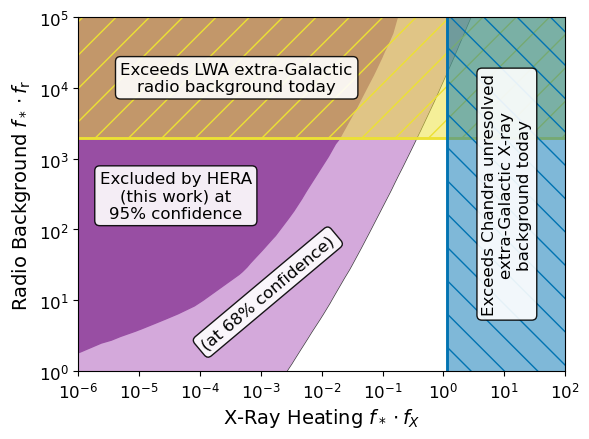

In [63]:
# Code to make paper-plot
venn_corrected_idr3.label=None
# Make 2d contour plot
fig, ax = venn_corrected_idr3.plot_2d(["log10fsfX", "log10fsfR"], alpha=1, types={"lower": "kde"}, facecolor=None, lw=2, color="k")
fig.set_size_inches(6,4.5)
fig.set_dpi(100)
# Extract contour lines
lineA = ((((fig.axes[0].collections[0].get_paths()[0]).vertices.T)))
lineB = ((((fig.axes[0].collections[1].get_paths()[0]).vertices.T)))
# Draw the exclusion plots correspondingly, here "region that lies outside of the HERA 1-sigma contour"
ax.log10fsfX.log10fsfR.fill_between(lineB[0], y1=lineB[1], y2=10*np.ones(len(lineB[0])), where=lineB[1]>-1, color='#D4A9DB', alpha=1, label="Excluded by HERA (this work)\nat >68% confidence")
# fill_between didn't do the left hand side automatically so do this manually:
ax.log10fsfX.log10fsfR.fill_betweenx(np.linspace(-5,10,100), x1=-10, x2=-3, alpha=1, color='#D4A9DB')
# And new the region that lies outside of HERA 2-sigma contour
ax.log10fsfX.log10fsfR.fill_between(lineA[0], y1=lineA[1], y2=10*np.ones(len(lineA[0])), where=lineA[1]>-1, color='#984ea3', alpha=1, label="(at >95% confidence)")
# Formatting and axis labels
ax.log10fsfX.log10fsfR.set_xlim(-6,2)
ax.log10fsfX.log10fsfR.set_ylim(0,5)
ax.log10fsfX.log10fsfR.set_xticks(np.linspace(-6,2,9), [r"$10^{-6}$", r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", r"$10^{0}$", r"$10^1$", r"$10^2$"])
ax.log10fsfX.log10fsfR.set_yticks(np.linspace(0,5,6), [r"$10^0$", r"$10^1$", r"$10^2$", r"$10^3$", r"$10^4$", r"$10^5$"])
ax.log10fsfX.log10fsfR.set_ylabel(r"Radio Background $f_{\rm *} \cdot f_{\rm r}}$")
ax.log10fsfX.log10fsfR.set_xlabel(r"X-Ray Heating $f_{\rm *} \cdot f_X$")
# LWA, with numbers read off from plot -- compare to old HERA paper but slightly more conservative taking the 2-sigma levels from LWA and Chandra
ax.log10fsfX.log10fsfR.fill_between(np.linspace(-10,10, 10), np.log10(2e3), 7, hatch="/", color=ccb[-2], fc=(1,1,1,0), lw=2)
ax.log10fsfX.log10fsfR.fill_between(np.linspace(-10,10, 10), np.log10(2e3), 7, alpha=0.5, color=ccb[-2], label="Exceeds LWA extra-Galactic\nradio background today", lw=2)
# Original limit (~1) computed with total 0.5–2 keV CXRB flux 8.15 erg cm−2 s−1, errorbar is 8.15 ± 0.58, scale up since fX proportional to X-Ray Background
ax.log10fsfX.log10fsfR.fill_betweenx(np.linspace(-10,10, 10), np.log10(1*1.142), 5, hatch="\\", color=ccb[0], fc=(1,1,1,0), lw=2)
ax.log10fsfX.log10fsfR.fill_betweenx(np.linspace(-10,10, 10), np.log10(1*1.142), 5, alpha=0.5, color=ccb[0], label="Exceeds Chandra unresolved\nextra-Galactic X-ray\nbackground today", lw=2)
# ax.log10fsfX.log10fsfR.legend(*ax.log10fsfX.log10fsfR.get_legend_handles_labels(), loc="lower right", fontsize=10)#, bbox_to_anchor=(.15,0.12,1,1))
plt.gca().tick_params(labelsize=12)

plt.tight_layout()

plt.gca().text(np.log10(4e-4), np.log10(1.4e4), 'Exceeds LWA extra-Galactic\nradio background today',  ha='center', va='center', 
               bbox=dict(facecolor='w', alpha=0.9, boxstyle='round'), fontsize=12)
plt.gca().text(np.log10(1.1e1), np.log10(10**2.5), 'Exceeds Chandra unresolved\nextra-Galactic X-ray\nbackground today',  ha='center', va='center', 
               rotation=90, bbox=dict(facecolor='w', alpha=0.9, boxstyle='round'), fontsize=12)
plt.gca().text(np.log10(4e-5), np.log10(3*10**2), 'Excluded by HERA\n(this work) at\n95% confidence',  ha='center', va='center', 
               rotation=0, bbox=dict(facecolor='w', alpha=0.9, boxstyle='round'), fontsize=12)
plt.gca().text(np.log10(1.3e-3), np.log10(1.3*10**1), '(at 68% confidence)',  ha='center', va='center', 
               rotation=40, bbox=dict(facecolor='w', alpha=0.9, boxstyle='round'), fontsize=12)


plt.savefig("./HERA_IDR3_LWA_Chandra.pdf", bbox_inches='tight')
plt.show()

In [64]:
print("=== Confidence levels ===")

## Test plot to look at impact of numin (as expected) or powerInd (no impact)
#fig, ax = idr3.plot_2d(paramNames, alpha=0, color=ccb[0])
#for i in range(51):
#    print("plot sample", i)
#    #c = ["red", "blue", "green"][int(i/17)] #for powerInd
#    c = plt.get_cmap("viridis")((i%17)/17.)
#    samples[i].plot_2d(ax, alpha=0.5, types={"diagonal": "kde"}, color=c)
#    # blue = low i = low numin = warmer = weaker constraints
#idr3.plot_2d(ax, alpha=1, color=ccb[0])
#plt.savefig("info_HERA_IDR3_triangle.pdf")
#plt.show()


# Formatting
idr3.label = None
prior.label = None

# Compute confidence level from samples (see anesthetic GitHub PR)
def fastCL(samples, weights=None, level=0.68, method="iso-probability"):
    weights = np.ones(len(samples)) if weights is None else weights
    # Sort and normalize
    order = np.argsort(samples)
    samples = np.array(samples[order])
    weights = np.array(weights[order]/np.sum(weights))
    # Compute inverse cumulative distribution function
    c = np.cumsum(weights)
    i = np.insert(c, 0, 0)
    CDF = np.append(i, 1)
    S = np.array([np.min(samples), *samples, np.max(samples)])
    invcdf = sip.interp1d(CDF, S)
    if method=="iso-probability":
        # Find smallest interval
        distance = lambda a, level=level: invcdf(a+level)-invcdf(a)
        a = sop.minimize_scalar(distance, bounds=(0,1-level), method="Bounded")#, method="SLSQP"
        #print(a, distance(0.16), distance(0.2))
        a =a.x
        interval = np.array([invcdf(a), invcdf(a+level)])
    elif method=="lower-limit":
        # Get value from which we reach the desired level
        interval = invcdf(1-level)
    elif method=="upper-limit":
        # Get value to which we reach the desired level
        interval = invcdf(level)
    else:
        assert False, method
    return interval

# Double checked, should be identical and they are.
yellow_line_Xray = fastCL(idr3.log10fX, weights=idr3.weights)[0]
yellow_line_Xray2 = fastCL(idr3.log10fX, weights=idr3.weights, method="lower-limit")
yellow_line_radio = fastCL(idr3["log10Fr"], weights=idr3.weights)[1]
yellow_line_radio2 = fastCL(idr3["log10Fr"], weights=idr3.weights, method="upper-limit")

print("Exclude at 68% CL:")
print("  F_r > {0:.0f}".format(10**yellow_line_radio))
#print("  F_r > {0:.0f}".format(10**yellow_line_radio2))
print("    Corresponds to L_R = {0:.3e}".format(1e22*(150/150)**-0.7*10**yellow_line_radio))
print("  f_X < {0:.2f}".format(10**yellow_line_Xray))
#print("  f_X < {0:.2f}".format(10**yellow_line_Xray2))
print("    Corresponds to L_X = {0:.3e}".format(3e40*10**yellow_line_Xray))

=== Confidence levels ===
Exclude at 68% CL:
  F_r > 575
    Corresponds to L_R = 5.750e+24
  f_X < 0.18
    Corresponds to L_X = 5.273e+39


=== Corner plots -- check if look different from before ===


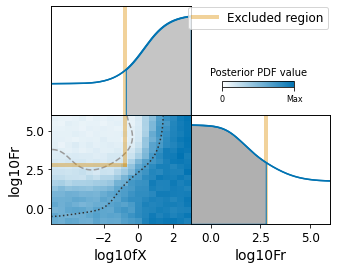

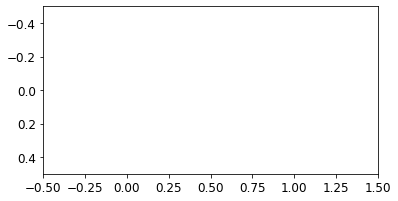

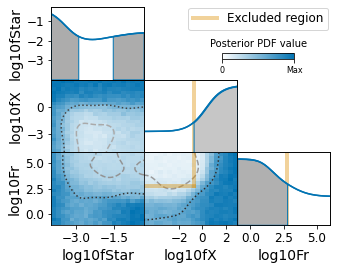

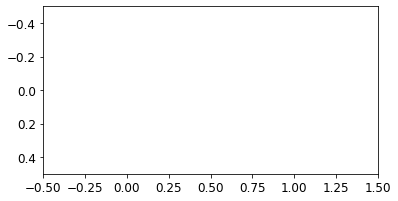

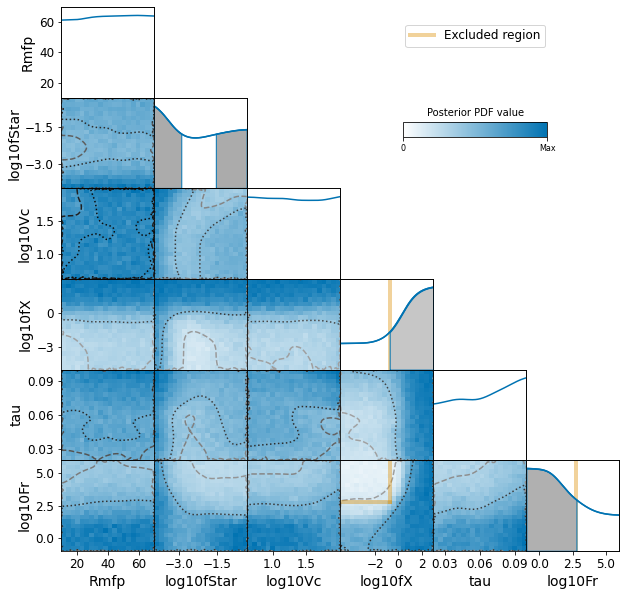

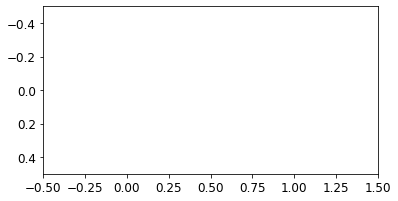

In [65]:
print("=== Corner plots -- check if look different from before ===")

# Here are 3 blocks for the 3 sizes of the figure:

fig, ax = idr3.plot_2d(["log10fX", "log10Fr"], types={'lower':'hist', 'diagonal':'kde'}, lower_kwargs={"bins": 20, 'color': ccb[0], "vmin":0, "zorder":-10, "rasterized":True}, diagonal_kwargs={'edgecolor': ccb[0]})
idr3.plot_2d(ax.loc[['log10fX'],['log10fX']], types={'diagonal':'kde'}, diagonal_kwargs={"edgecolor": ccb[0], "facecolor": 'grey'}, color=ccb[0], levels=[0.68])
idr3.plot_2d(ax.loc[["log10Fr"],["log10Fr"]], types={'diagonal':'kde'}, diagonal_kwargs={"edgecolor": ccb[0], "facecolor": 'grey'}, color=ccb[0], levels=[0.68])
# Yellow band
y1 = yellow_line_Xray #0
y2 = yellow_line_radio #3
ax['log10fX']["log10Fr"].plot([priorDict_Sims["log10fX"][0],y1],[y2,y2], color=ccb[1], lw=4, alpha=0.4, linestyle='solid')
ax['log10fX']["log10Fr"].plot([y1,y1],[y2,priorDict_Sims["log10Fr"][1]], color=ccb[1], lw=4, alpha=0.4, linestyle='solid', label='Excluded region')
ax['log10fX']['log10fX'].axvline(y1, ls='solid', color=ccb[1], lw=4, alpha=0.4)
ax["log10Fr"]["log10Fr"].axvline(y2, ls='solid', color=ccb[1], lw=4, alpha=0.4)
ax['log10fX']["log10Fr"].set_xticks([-2,0,2])
# Pandas fun -- make a dataframe of the lower part of corner plot for anesthetic
lower_ax = {}
for key in ax.keys():
    lower_ax[key] = {}
    axk = ax[key]
    for key2 in axk.keys():
        if key != key2:
            lower_ax[key][key2] = ax[key][key2]
        else:
            lower_ax[key][key2] = None
lower_ax = pd.DataFrame(lower_ax)
# KDE lines for lower part
idr3.plot_2d(lower_ax, types={'lower':'fastkde'}, lower_kwargs={"levels":[0.95, 0.68], "linestyles":['dashed', "dotted"], "color":'black', "facecolor":None}, ncompress=3000)
# Decorations
handles, labels = ax["log10fX"]["log10Fr"].get_legend_handles_labels()
fig.set_size_inches(5,4)
ax["log10fX"]["log10fX"].get_yaxis().set_visible(False)
leg = fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.7, 0.84))
plt.figure()
img = plt.imshow(np.array([[0,1]]), cmap=LinearSegmentedColormap.from_list("CCB", ['#ffffff', ccb[0]]))
img.set_visible(False)
cax = fig.add_axes([0.6, 0.6, 0.2, 0.02])
plt.colorbar(img, cax=cax, orientation='horizontal', ticks=[0,1])
cax.set_title(r"Posterior PDF value", fontsize=10)
cax.set_xticklabels(["0", "Max"], fontsize=8)

# fig.savefig("HERA_small_triangle.pdf")
plt.show()



fig, ax = idr3.plot_2d(["log10fStar", "log10fX", "log10Fr"], types={'lower':'hist', 'diagonal':'kde'}, lower_kwargs={"bins": 20, 'color': ccb[0], "vmin":0, "zorder":-10, "rasterized":True}, diagonal_kwargs={'edgecolor': ccb[0]})
idr3.plot_2d(ax.loc[['log10fX'],['log10fX']], types={'diagonal':'kde'}, diagonal_kwargs={"edgecolor": ccb[0], "facecolor": 'grey'}, color=ccb[0], levels=[0.68])
idr3.plot_2d(ax.loc[['log10fStar'],['log10fStar']], types={'diagonal':'kde'}, diagonal_kwargs={"edgecolor": ccb[0], "facecolor": 'grey'}, color=ccb[0], levels=[0.68])
idr3.plot_2d(ax.loc[["log10Fr"],["log10Fr"]], types={'diagonal':'kde'}, diagonal_kwargs={"edgecolor": ccb[0], "facecolor": 'grey'}, color=ccb[0], levels=[0.68])
# Yellow band
y1 = yellow_line_Xray #0
y2 = yellow_line_radio #3
ax['log10fX']["log10Fr"].plot([priorDict_Sims["log10fX"][0],y1],[y2,y2], color=ccb[1], lw=4, alpha=0.4, linestyle='solid')
ax['log10fX']["log10Fr"].plot([y1,y1],[y2,priorDict_Sims["log10Fr"][1]], color=ccb[1], lw=4, alpha=0.4, linestyle='solid', label='Excluded region')
ax['log10fX']['log10fX'].axvline(y1, ls='solid', color=ccb[1], lw=4, alpha=0.4)
ax["log10Fr"]["log10Fr"].axvline(y2, ls='solid', color=ccb[1], lw=4, alpha=0.4)
ax['log10fX']["log10Fr"].set_xticks([-2,0,2])
# Pandas fun -- make a dataframe of the lower part of corner plot for anesthetic
lower_ax = {}
for key in ax.keys():
    lower_ax[key] = {}
    axk = ax[key]
    for key2 in axk.keys():
        if key != key2:
            lower_ax[key][key2] = ax[key][key2]
        else:
            lower_ax[key][key2] = None
lower_ax = pd.DataFrame(lower_ax)
# KDE lines for lower part
idr3.plot_2d(lower_ax, types={'lower':'fastkde'}, lower_kwargs={"levels":[0.95, 0.68], "linestyles":['dashed', "dotted"], "color":'black', "facecolor":None}, ncompress=3000)
# Decorations
handles, labels = ax["log10fX"]["log10Fr"].get_legend_handles_labels()
fig.set_size_inches(5,4)
ax["log10fX"]["log10fX"].get_yaxis().set_visible(False)
leg = fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.7, 0.84))
plt.figure()
img = plt.imshow(np.array([[0,1]]), cmap=LinearSegmentedColormap.from_list("CCB", ['#ffffff', ccb[0]]))
img.set_visible(False)
cax = fig.add_axes([0.6, 0.7, 0.2, 0.02])
plt.colorbar(img, cax=cax, orientation='horizontal', ticks=[0,1])
cax.set_title(r"Posterior PDF value", fontsize=10)
cax.set_xticklabels(["0", "Max"], fontsize=8)

fig.savefig("HERA_medium_triangle.pdf")
plt.show()



fig, ax = idr3.plot_2d(paramNames, types={'lower':'hist', 'diagonal':'kde'}, lower_kwargs={"bins": 20, 'color': ccb[0], "vmin":0, "zorder":-10, "rasterized":True}, diagonal_kwargs={'edgecolor': ccb[0]})
idr3.plot_2d(ax.loc[['log10fX'],['log10fX']], types={'diagonal':'kde'}, diagonal_kwargs={"edgecolor": ccb[0], "facecolor": 'grey'}, color=ccb[0], levels=[0.68])
idr3.plot_2d(ax.loc[['log10fStar'],['log10fStar']], types={'diagonal':'kde'}, diagonal_kwargs={"edgecolor": ccb[0], "facecolor": 'grey'}, color=ccb[0], levels=[0.68])
idr3.plot_2d(ax.loc[["log10Fr"],["log10Fr"]], types={'diagonal':'kde'}, diagonal_kwargs={"edgecolor": ccb[0], "facecolor": 'grey'}, color=ccb[0], levels=[0.68])
# Yellow band
y1 = yellow_line_Xray #0
y2 = yellow_line_radio #3
ax['log10fX']["log10Fr"].plot([priorDict_Sims["log10fX"][0],y1],[y2,y2], color=ccb[1], lw=4, alpha=0.4, linestyle='solid')
ax['log10fX']["log10Fr"].plot([y1,y1],[y2,priorDict_Sims["log10Fr"][1]], color=ccb[1], lw=4, alpha=0.4, linestyle='solid', label='Excluded region')
ax['log10fX']['log10fX'].axvline(y1, ls='solid', color=ccb[1], lw=4, alpha=0.4)
ax["log10Fr"]["log10Fr"].axvline(y2, ls='solid', color=ccb[1], lw=4, alpha=0.4)
ax['log10fX']["log10Fr"].set_xticks([-2,0,2])
# Pandas fun -- make a dataframe of the lower part of corner plot for anesthetic
lower_ax = {}
for key in ax.keys():
    lower_ax[key] = {}
    axk = ax[key]
    for key2 in axk.keys():
        if key != key2:
            lower_ax[key][key2] = ax[key][key2]
        else:
            lower_ax[key][key2] = None
lower_ax = pd.DataFrame(lower_ax)
# KDE lines for lower part
idr3.plot_2d(lower_ax, types={'lower':'kde'}, lower_kwargs={"levels":[0.95, 0.68], "linestyles":['dashed', "dotted"], "color":'black', "facecolor":None}, ncompress=3000)
# Decorations
handles, labels = ax["log10fX"]["log10Fr"].get_legend_handles_labels()
fig.set_size_inches(10,10)
ax["log10fX"]["log10fX"].get_yaxis().set_visible(False)
leg = fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.7, 0.84))
plt.figure()
img = plt.imshow(np.array([[0,1]]), cmap=LinearSegmentedColormap.from_list("CCB", ['#ffffff', ccb[0]]))
img.set_visible(False)
cax = fig.add_axes([0.6, 0.7, 0.2, 0.02])
plt.colorbar(img, cax=cax, orientation='horizontal', ticks=[0,1])
cax.set_title(r"Posterior PDF value", fontsize=10)
cax.set_xticklabels(["0", "Max"], fontsize=8)

# fig.savefig("HERA_large_triangle.pdf")
plt.show()

=== Temperature plots ===
Constrain at 95% CL:
  Posterior log10(Trad/TS) < 0.6
  Prior log10(Trad/TS) < 1.9
Removed no burn in
Removed no burn in


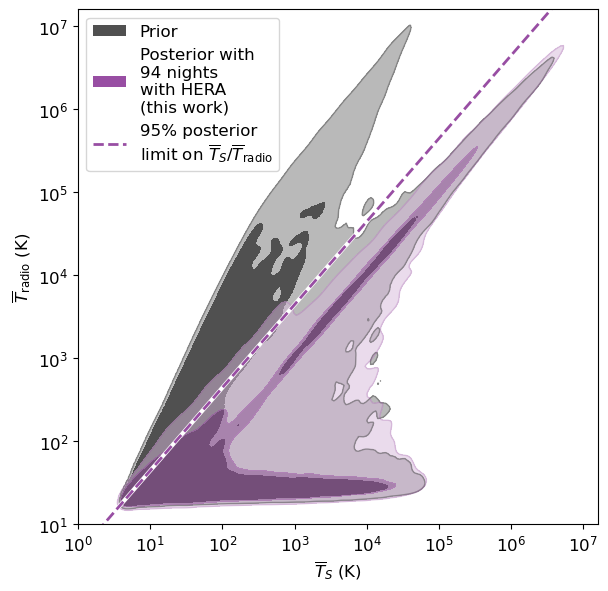

In [66]:
print("=== Temperature plots ===")

# Confidences
posterior_limit_Trad_over_TK = -fastCL(idr3["log10TK_z8"]-idr3["log10TR_z8"], weights=idr3.weights, method="lower-limit", level=0.95)
prior_limit_Trad_over_TK = -fastCL(prior["log10TK_z8"]-prior["log10TR_z8"], weights=prior.weights, method="lower-limit", level=0.95)
posterior_limit_Trad_over_TS = -fastCL(idr3["log10TS_z8"]-idr3["log10TR_z8"], weights=idr3.weights, method="lower-limit", level=0.95)
prior_limit_Trad_over_TS = -fastCL(prior["log10TS_z8"]-prior["log10TR_z8"], weights=prior.weights, method="lower-limit", level=0.95)
print("Constrain at 95% CL:")
print("  Posterior log10(Trad/TS) < {0:.1f}".format(posterior_limit_Trad_over_TS))
print("  Prior log10(Trad/TS) < {0:.1f}".format(prior_limit_Trad_over_TS))

# TS
import getdist
from getdist import plots
settings = plots.GetDistPlotSettings()
settings.legend_fontsize=12
settings.axes_fontsize=12
settings.axes_labelsize=12
sett = {"smooth_scale_2D": -5}
g = plots.get_single_plotter(width_inch=6, ratio=1, settings=settings)
plt.gcf().set_dpi(100)
s = getdist.mcsamples.MCSamples(samples=np.array([prior["log10TS_z8"],prior["log10TR_z8"]]).T, weights=np.array(prior.weights), 
                                names=["log10TS_z8","log10TR_z8"], labels=[r'\log_{10} \overline{T}_S', r'\log_{10} \overline{T}_{\rm radio}'], settings=sett)
s2 = getdist.mcsamples.MCSamples(samples=np.array([idr3["log10TS_z8"],idr3["log10TR_z8"]]).T, weights=np.array(idr3.weights), 
                                 names=["log10TS_z8","log10TR_z8"], labels=[r'\log_{10} \overline{T}_S', r'\log_{10} \overline{T}_{\rm radio}'], settings=sett)
g.plot_2d([s, s2], 'log10TS_z8', 'log10TR_z8', filled=True, colors=["#505050", "#984ea3"], alphas=[1,0.5])


a2 = g.get_axes()
a2.set_xlim(np.min(prior['log10TS_z8']),np.max(prior['log10TS_z8']))
a2.set_ylim(np.min(prior['log10TR_z8']),np.max(prior['log10TR_z8']))

Tplot = np.linspace(0,10,1000)
a2.plot(Tplot, posterior_limit_Trad_over_TS+Tplot, color="w", lw=3)
l = a2.plot(Tplot, posterior_limit_Trad_over_TS+Tplot, ls='dashed', color="#984ea3", lw=2, label='95% posterior\nlimit on $\\overline{T}_S / \\overline{T}_{\\rm radio}$')

# update legend
leg = plt.gca().legend()
from matplotlib.patches import Patch
ax = leg.axes
handles, labels = ax.get_legend_handles_labels()
handles = [Patch(facecolor='#505050'), Patch(facecolor='#984ea3')] + handles
labels = ['Prior', 'Posterior with\n94 nights\nwith HERA\n(this work)'] + labels
ax.legend(handles=handles, labels=labels, loc='upper left')

plt.gca().set_xlim([0, 7.2])
plt.gca().set_ylim([1, 7.2])

plt.gca().set_xticks([0, 1, 2, 3, 4, 5, 6, 7], labels=[f"$10^{i}$" for i in range(8)])
plt.gca().set_yticks([1, 2, 3, 4, 5, 6, 7], labels=[f"$10^{i}$" for i in range(1,8)])
plt.gca().set_xlabel(r'$\overline{T}_S$ (K)', fontsize=12)
plt.gca().set_ylabel(r'$\overline{T}_{\rm radio}$ (K)', fontsize=12)

plt.savefig("./HERA_TS_TRad.pdf", bbox_inches='tight')
plt.show()

Removed no burn in
Removed no burn in


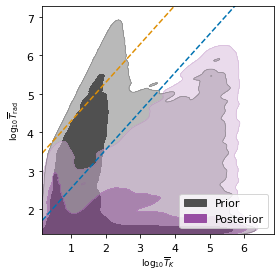

In [67]:
# TK
settings = plots.GetDistPlotSettings()
settings.legend_fontsize=11
settings.axes_fontsize=11
settings.axes_labelsize=9
sett = {"smooth_scale_2D": -5}
g = plots.get_single_plotter(width_inch=4, ratio=1, settings=settings)
s = getdist.mcsamples.MCSamples(samples=np.array([prior["log10TK_z8"],prior["log10TR_z8"]]).T, weights=np.array(prior.weights), names=["log10TK_z8","log10TR_z8"], labels=[r'\log_{10} \overline{T}_K', r'\log_{10} \overline{T}_{\rm rad}'], settings=sett)
s2 = getdist.mcsamples.MCSamples(samples=np.array([idr3["log10TK_z8"],idr3["log10TR_z8"]]).T, weights=np.array(idr3.weights), names=["log10TK_z8","log10TR_z8"], labels=[r'\log_{10} \overline{T}_K', r'\log_{10} \overline{T}_{\rm rad}'], settings=sett)
g.plot_2d([s, s2], 'log10TK_z8', 'log10TR_z8', filled=True, colors=["#505050", "#984ea3"], alphas=[1,0.5])
g.add_legend(['Prior', 'Posterior'], legend_loc='lower right')
a2 = g.get_axes()
a2.set_xlim(np.min(prior['log10TK_z8']),np.max(prior['log10TK_z8']))
a2.set_ylim(np.min(prior['log10TR_z8']),np.max(prior['log10TR_z8']))

Tplot = np.linspace(0,6,1000)
a2.plot(Tplot, posterior_limit_Trad_over_TK+Tplot, ls='dashed', color=ccb[0])
a2.plot(Tplot, prior_limit_Trad_over_TK+Tplot, ls='dashed', color=ccb[1])
plt.savefig("HERA_TK_TRad.pdf")
plt.show()

## Summaries

In [68]:
def weighted_quantile(values, quantiles, sample_weight=None,
                      values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'
    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]
    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses


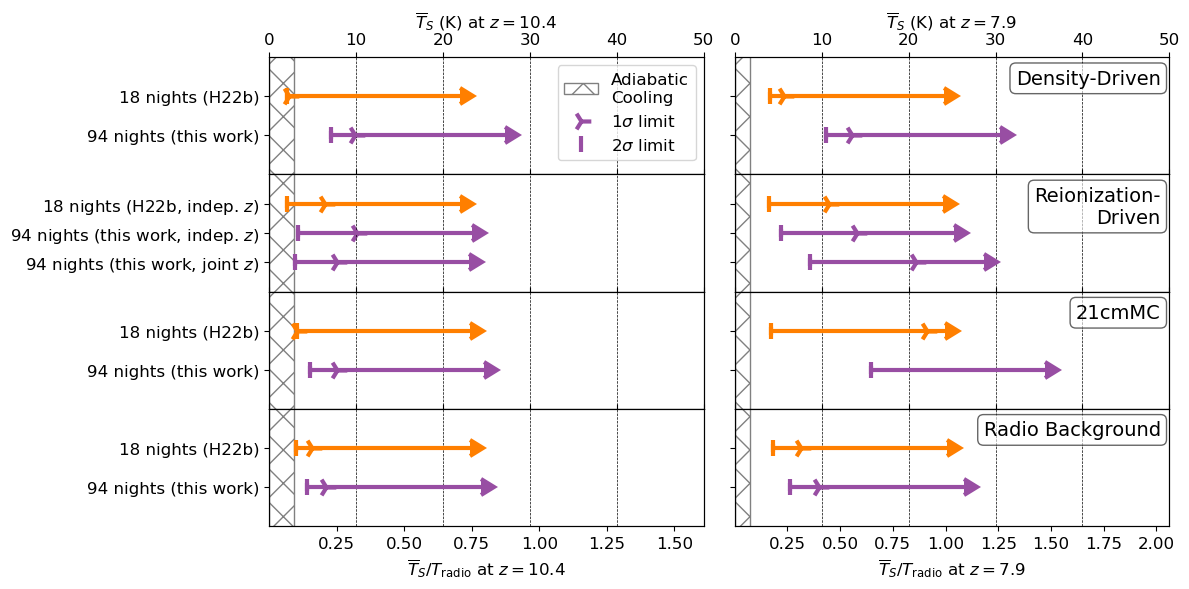

In [69]:
"""

plot_punchline.py

Author: Jordan Mirocha
Affiliation: McGill University
Created on: Sun 29 May 2022 16:18:35 EDT

Description:

"""

import numpy as np
import matplotlib.pyplot as pl
from results import ResultsMCMC
import plotting
import imp
imp.reload(plotting)

# Yuxiang's numbers
data_yq = \
{
 7.9: { # 95% lower bound, 95% upper bound, 68% lower, 68% upper
 'Ts': [15.64072702, 656.67671283, 79.00771728, 627.99634418],
 'Ts_v2': [4.18270818, 644.58371205, 22.06248441, 610.43788811],
 'Ts_prior': [1.56032610e+00, 1.68996500e+03, 1.70611155e+00, 4.80601289e+01]     
 },
 10.4: {
 'Ts': [4.72071187, 171.19165964, 7.85156912, 84.73294397],
 'Ts_v2': [3.14981683, 142.82513268, 3.24924131, 32.68302727],
 'Ts_prior': [2.48513679, 490.93420191, 3.10517677, 24.18525972],
 },
 'model_name': '21cmMC',
 'variant_ids': ('94 nights (this work)', '18 nights (H22b)'),
 'variants': (None, 'v2'),
 'colors': ('#984ea3','#ff7f00'),
 'chains': False,
}

# Julian's numbers
data_jbm = \
{
 7.9: {
 'Ts': [10.5, None, 13.5, 110],
 'Ts_v2': [4.1, None, 5.7, None],
 },
 10.4: {
 'Ts': [7.1, None, 9.9, None],
 'Ts_v2': [2.0, None, 2.3, None], # Same as above!
 },
 'model_name': 'Density-Driven',
 'variant_ids': ('94 nights (this work)', '18 nights (H22b)'),
 'variants': [None, 'v2'],
 'colors': ('#984ea3','#ff7f00'),
 'chains': False,
}

data_jtm = \
{
 7.9: {
 'Ts': [8.69356773, None, 20.86385977, None],
 'Ts_v2': [5.261399817, None, 14.042899441729698, None],
 #'Ts_v3': [5.3, None, 25., None], # published numbers
 'Ts_v3': [3.9521318859237065, None, 10.894316048496254, None]
 },
 10.4: {
 'Ts': [3.0082037288592605, None, 7.8025872825168525, None],
 'Ts_v2': [3.2741043441069873, None, 10.06535068498234, None],
 'Ts_v3': [2.002668972770117, None, 6.375286040366599, None],
 },
 'model_name': 'Reionization-\nDriven',
 'variant_ids': (r'94 nights (this work, joint $z$)', r'94 nights (this work, indep. $z$)', r'18 nights (H22b, indep. $z$)'),
 'variants': [None, 'v2', 'v3'],
 'colors': ('#984ea3','#984ea3','#ff7f00'),
 'chains': False,
}


# Stefan's numbers: have full chains, just trick plotter into initializing
# axes. Will do by hand below.
data_sh = \
{
 7.9: None,
 10.4: None,
 'model_name': 'Radio Background',
 'variants': [],
 'variant_ids': [],
 'chains': True,
}

# Make objects that know what to do with these dictionaries
r_21cmmc = ResultsMCMC(data_yq)
r_jbm_dd = ResultsMCMC(data_jbm)
r_jtm_rd = ResultsMCMC(data_jtm)
r_sh_rbg = ResultsMCMC(data_sh)

# Initialize an object that knows how to plot stuff the way we like to
psum = plotting.PlotSummary((r_jbm_dd, r_jtm_rd, r_21cmmc, r_sh_rbg))

# Tick marks to use in Ts/Tr
psum.ticks_Ts_over_Tr = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2.0]

# Make the "punchline plot"|
fig, axes, axes_r = psum.plot_limits('Ts', redshifts=[10.4, 7.9], pticks=10,
                                     annotate_kw={'fontsize':14}, plim=(0, 50),
                                     conf_level='both', arrow_len=20, temp_ax='top', lw=3, capsize=6, hspace=0)

# Plot Stefan's separately for now
ax_rbg = axes[-1]
zactual = 7.9, 10.4

# Read Stefan's data
s = np.load("stefan/punchline_TS_TR_idr3.npy", allow_pickle=True).item()
p = np.load("stefan/TS_TR_weights_prior.npy", allow_pickle=True).item()
for i, z in enumerate([10, 8]):
    logTs = s['log10TS_z{}'.format(z)]
    logTr = s['log10TR_z{}'.format(z)]

    Ts_over_Tr = 10**(logTs - logTr)

    Ts_Tr_eq_Tcmb = Ts_over_Tr * 2.725 * (1 + zactual[i])

    #lo1a, hi1a = np.percentile(Ts_Tr_eq_Tcmb, (16, 84))
    #lo2a, hi2a = np.percentile(Ts_Tr_eq_Tcmb, (2.5, 97.5))

    lo1, hi1 = weighted_quantile(Ts_Tr_eq_Tcmb, (0.16, 0.84),
        sample_weight=s['weights'])
    lo2, hi2 = weighted_quantile(Ts_Tr_eq_Tcmb, (0.025, 0.975),
        sample_weight=s['weights'])
    
    data_sh[zactual[i]] = {'Ts': [lo2, hi2, lo1, hi1]}

    ax_rbg[i].errorbar(lo2, 0, xerr=20, lolims=True, xlolims=True, fmt='|', capsize=6, lw=3, markeredgewidth=3,
        color='#984ea3')
    ax_rbg[i].scatter(lo1, 0, marker='4', color='#984ea3', s=200, lw=3)

    ax_rbg[i].set_yticks([0, 1])
    ax_rbg[i].set_ylim(-1, 2)
    ax_rbg[i].tick_params(axis='both', which='major', labelsize=12)

s = np.load("stefan/punchline_TS_TR_idr2.npy", allow_pickle=True).item()
for i, z in enumerate([10, 8]):
    logTs = s['log10TS_z{}'.format(z)]
    logTr = s['log10TR_z{}'.format(z)]

    Ts_over_Tr = 10**(logTs - logTr)

    Ts_Tr_eq_Tcmb = Ts_over_Tr * 2.725 * (1 + zactual[i])

    lo1, hi1 = weighted_quantile(Ts_Tr_eq_Tcmb, (0.16, 0.84),
        sample_weight=s['weights'])
    lo2, hi2 = weighted_quantile(Ts_Tr_eq_Tcmb, (0.025, 0.975),
        sample_weight=s['weights'])
    
    data_sh[zactual[i]]['Ts_v2'] = [lo2, hi2, lo1, hi1]

    ax_rbg[i].errorbar(lo2, 1, xerr=20, lolims=True, xlolims=True, fmt='|', capsize=6, lw=3, markeredgewidth=3,
        color='#ff7f00')
    ax_rbg[i].scatter(lo1, 1, marker='4', color='#ff7f00', s=200, lw=3)

# # Plot H1C too
# Ts_over_Tr = 10**np.load("stefan/Fr_posterior_log10_TS_over_Trad.npy")
# Ts_Tr_eq_Tcmb = Ts_over_Tr * 2.725 * (1 + 7.9)
# lo1a, hi1a = np.percentile(Ts_Tr_eq_Tcmb, (16, 84))
# lo2a, hi2a = np.percentile(Ts_Tr_eq_Tcmb, (2.5, 97.5))
# ax_rbg[0].errorbar(lo2a, 1, xerr=20, lolims=True, xlolims=True, fmt='|',
#                    color='#ff7f00', capsize=6, lw=3, markeredgewidth=3)
# ax_rbg[0].scatter(lo1a, 1, marker='4', color='#ff7f00', s=200, lw=3)
ax_rbg[0].set_yticklabels(['94 nights (this work)', '18 nights (H22b)'])

fig.set_size_inches((12, 6))
fig.set_dpi(100)
for i in range(2):
    axes[0][i].set_xlabel('$\\overline{T}_S$ (K)' + f' at $z = {[10.4, 7.9][i]}$', fontsize=12)
    axes_r[-1][i].set_xlabel('$\\overline{T}_S / T_{{\\rm radio}}$'  + f' at $z = {[10.4, 7.9][i]}$', fontsize=12)
    
for i in range(4):
    for j in range(2):
        axes[i][j].tick_params(axis='both', labelsize=12)
        axes_r[i][j].tick_params(axis='both', labelsize=12)
        

legend = axes[0][0].legend([axes[-1][0].get_children()[0], axes[-1][0].get_children()[5], axes[-1][0].get_children()[4]],
                            ['Adiabatic\nCooling','$1\sigma$ limit', '$2\sigma$ limit'], fontsize=12)        
        
plt.subplots_adjust(hspace=0)
plt.tight_layout()
plt.savefig('Ts_summary.pdf', bbox_inches = "tight")

7.9 Reionization-
Driven 0.35846068364086175
7.9 Density-Driven 0.43294505721059684
7.9 21cmMC 0.6449119480465931
7.9 Radio Background 0.17780214602914582
10.4 Reionization-
Driven 0.09683578718362339
10.4 Density-Driven 0.2285530339610494
10.4 21cmMC 0.15196239723161112
10.4 Radio Background 0.205353832846849


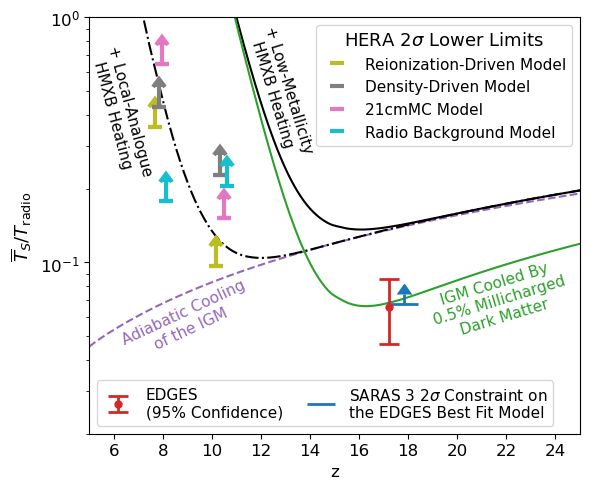

In [70]:
plt.figure(figsize=(6,5), dpi=100)

# HERA
for z in [7.9, 10.4]:
    for i, data in enumerate([data_jtm, data_jbm, data_yq, data_sh]):
        color = [ 'C8', 'C7', 'C6', 'C9',][i]
        lim = data[z]['Ts'][0] / (2.725 * (1 + z))
        plt.plot(z + (-1.5 + i)*.15, lim, '_', c=color, ms=10, mew=3, label=(data['model_name'].replace('\n','') + ' Model' if z == 7.9 else None), zorder=20)
        print(z, data['model_name'], lim)
        plt.errorbar(z + (-1.5 + i)*.15, lim, yerr=lim/5, lolims=True, fmt='', lw=3, capsize=4,mew=3, c=color, zorder=20)

# Plot Heating
temps = pd.read_csv('temps_for_Josh.csv')
zs = temps['z'].values



plt.semilogy(zs, temps['Tad/Tcmb'], '--', color='C4')
plt.semilogy(zs, np.where(temps['TkLX1/Tcmb'] > 0, temps['TkLX1/Tcmb'], np.nan), 'k-.')
plt.semilogy(zs, np.where(temps['TkLX2/Tcmb'] > 0, temps['TkLX2/Tcmb'], np.nan), 'k')
plt.semilogy(zs, np.where(temps['TkmQ+LX2/Tcmb'] > 0, temps['TkmQ+LX2/Tcmb'], np.nan), c='C2')
# plt.semilogy(zs, with_heating, 'k--')

leg1 = plt.legend(fontsize=11, title='HERA 2$\sigma$ Lower Limits', loc='upper right')
plt.setp(leg1.get_title(),fontsize=13)

# EDGES 
EDGES_z = (1420 / 78) - 1
EDGES_lims = np.array([0.0462387, 0.0852806])
EDGES_best_fit = 0.0653538
# p1, = plt.plot(EDGES_z, EDGES_2sigma_upper, '_', c='C3', ms=20, mew=3, label='EDGES 2$\sigma$\nLower Limit')
# plt.errorbar(EDGES_z, EDGES_2sigma_upper, yerr=EDGES_2sigma_upper/10, uplims=True, capsize=5, lw=3, fmt='', c='C3')
p1 = plt.errorbar(EDGES_z, np.mean(EDGES_lims, keepdims=True),  capsize=7, lw=2, fmt='.', ms=8, c='C3', mew=2, ls='',
             yerr=[[EDGES_best_fit - EDGES_lims[0]], [EDGES_lims[1] - EDGES_best_fit]], label='EDGES\n(95% Confidence)')

# SARAS
SARAS_z = (1420 / 75.5) - 1
SARAS_2sigma_lower = 0.067892
p2, = plt.plot(SARAS_z, SARAS_2sigma_lower, '_', c='C0', ms=20, mew=2, label='SARAS 3 2$\sigma$ Constraint on\nthe EDGES Best Fit Model')
plt.errorbar(SARAS_z, SARAS_2sigma_lower, c='C0', yerr=SARAS_2sigma_lower/10, lolims=True, capsize=5, lw=2, fmt='')

plt.gca().add_artist(leg1)
plt.legend(handles =[p1, p2], ncol=2, fontsize=11, loc='lower left', columnspacing=1.5)

# TEXT
plt.text(9, .04, 'Adiabatic Cooling\nof the IGM', fontsize=11, rotation=25, ha='center', color='C4')
plt.text(6.3, .22, '+ Local-Analogue\nHMXB Heating', ha='center', fontsize=11, rotation=-75)
plt.text(12.8, .27, '+ Low-Metallicity\nHMXB Heating', ha='center', fontsize=11, rotation=-73)

plt.text(21.7, .048, 'IGM Cooled By\n0.5% Millicharged\nDark Matter', ha='center', fontsize=11, rotation=17, color='C2')
# plt.text(21.7, .055, '0.5% Millicharged\nDark Matter', ha='center', fontsize=11, rotation=16, color='C2')

plt.ylim(.02, 1)
plt.xlim(5, 25)
plt.xticks([6, 8, 10, 12, 14, 16, 18, 20, 22, 24])
plt.xlabel('z', fontsize=12)
plt.ylabel('$\\overline{T}_S / T_{{\\rm radio}}$', fontsize=13)
plt.gca().tick_params(axis='both', labelsize=12)
plt.tight_layout()
plt.savefig('Ts_over_Trad_vs_z.pdf', bbox_inches = "tight")

# H22b Results for Talks

invalid value encountered in reduce
invalid value encountered in reduce


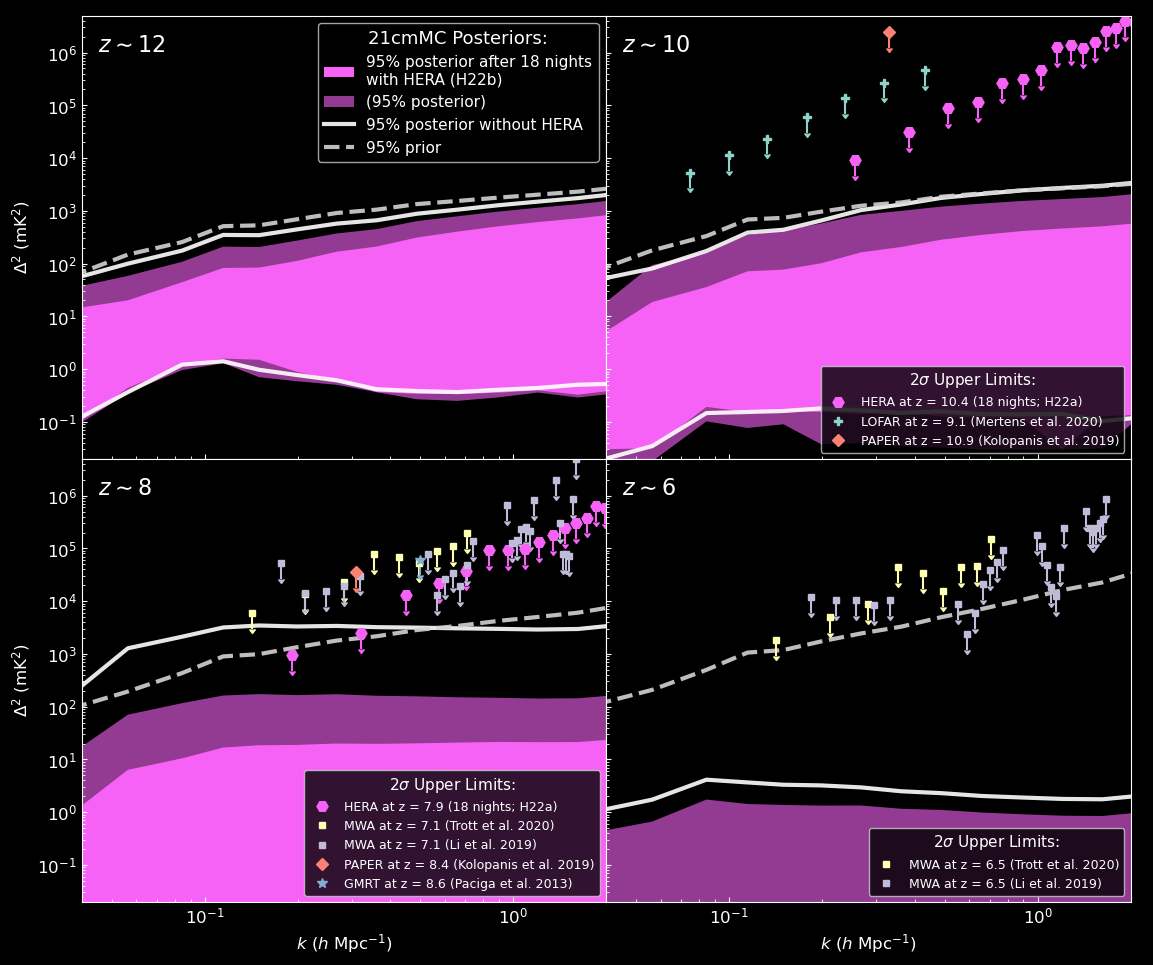

In [71]:
with plt.style.context('dark_background'):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    import eor_limits

    cosmo = {'omega_M_0' : 0.307500,
    'omega_lambda_0' : 0.6925,
    'omega_b_0' : 0.0486,
    'omega_n_0' : 0.0,
    'N_nu' : 0,
    'h' : 0.677400,
    'n' : 0.97000,
    'sigma_8' : 0.82
    }

    sim_names = ['normalL_HERA_update_morelivepts', 'normalL_noHERA', 'prior'] # need to change normalL_HERA_update_H1C (which uses 1e4 livepts) to sth like normalL_HERA_update_H1C_final_morelivepts (which uses 2e4 livepts as well and the finalized data from hera)
    sim_labels = ['95% posterior after 18 nights\nwith HERA (H22b)', 
                  '95% posterior without HERA',
                  '95% prior']
    sim_labels_withdata = ['HERA (18 nights; H22a)']
    zs_PS = np.array([12.00443 , 10.32114 ,  7.926647,  5.90059 ])

    # we have 84 snapshots in the model, we only use these snapshots, correpsonding to z=12, 10, 8 and 6
    snapshots = [32,25,13,0] 

    # these are the wavenumbers for our model
    ks = np.array([0.02513274, 0.03820577, 0.05725007, 0.07778031, 0.101638  ,
           0.1347107 , 0.1815186 , 0.2444601 , 0.3299734 , 0.4460977 ,
           0.6021986 , 0.8131821 , 1.097917  , 1.480195  , 1.920623  ,
           2.388536  ]) / cosmo['h']

    # This is what I got before from you before and used in the inference
    # their structure is [#field, #k mode, {k, power(negative values have been set to 0), sigma, power+2sigma}]
    hera_final_band1 = np.load('power_spectrum_posterior/joshdata_band1.npy') 
    hera_final_band2 = np.load('power_spectrum_posterior/joshdata_band2.npy')

    xlim = [4e-2,2]
    ylim = [2e-2,5e6]

    fig, axsPS = plt.subplots(2,2,figsize=(12, 10), dpi=100, sharex=True, sharey=True, gridspec_kw=dict(hspace=0, wspace=0))
    axsPS = axsPS.flatten()

    # first plot the two posteriors
    for kk, sim_name in enumerate(sim_names[0:3]):

        color = ['#F662F5', 'w',  'lightgrey',][kk]

        for ii in range(len(snapshots)):
            if ii==0:
                label=sim_labels[kk]
            else:
                label=None

            #low, high, low2, high2 are 1 sigma range and 2 sigma range calcualted using highest posterior density (HPD)
            low = np.load('power_spectrum_posterior/ps_%s_z%s_low.npy'%(sim_name, ("%.1f"%zs_PS[ii]).replace('.','pt')))
            low2 = np.load('power_spectrum_posterior/ps_%s_z%s_low2.npy'%(sim_name, ("%.1f"%zs_PS[ii]).replace('.','pt')))
            high = np.load('power_spectrum_posterior/ps_%s_z%s_high.npy'%(sim_name, ("%.1f"%zs_PS[ii]).replace('.','pt')))
            high2 = np.load('power_spectrum_posterior/ps_%s_z%s_high2.npy'%(sim_name, ("%.1f"%zs_PS[ii]).replace('.','pt')))        


            if kk>=1:
                axsPS[ii].plot(ks , low2,color=color,alpha=0.9,lw=3, ls=('--' if sim_name == 'prior' else None), label=label)
                axsPS[ii].plot(ks, high2,color=color,alpha=0.9,ls=('--' if sim_name == 'prior' else None), lw=3)
    #             axsPS[ii].plot(ks , low,color=color,alpha=0.7,lw=3,label=label)
    #             axsPS[ii].plot(ks, high,color=color,alpha=0.7, lw=3)
    #             axsPS[ii].plot(ks, low2,color=color,alpha=0.7,lw=1, label=('(95% posterior)' if ii == 0 else None))
    #             axsPS[ii].plot(ks, high2,color=color,alpha=0.7, lw=1)
            else:
                axsPS[ii].fill_between(ks, low, high,color=color,alpha=1,label=label, edgecolor=None)
                axsPS[ii].fill_between(ks, low2, high2,color=color,alpha=0.6,label=('(95% posterior)' if ii == 0 else None), edgecolor=None)

    ########## HERA #############

    for hera_final, redshift, axP in zip([hera_final_band1, hera_final_band2], [10.4,7.9], [axsPS[1],axsPS[2]]):


#         for ik in range(len(hera_final[0,:,0])):
#             if redshift==7.9:
#                 if ik % 2 == 0:
#                     continue
#             if redshift==10.4:
#                 if ik % 2 == 1:
#                     continue

#             # for each k, I'm looking for the lowest limit (as in power+2sigma)
#             ifield = np.argmin(hera_final[:,ik,-1])
#             hera_k = hera_final[ifield,ik,0]
#             hera_p = max(0, hera_final[ifield,ik,1])
#             hera_ul = hera_final[ifield,ik,-1]

#             eb = axP.errorbar(hera_k, hera_ul, yerr=[[0.5*hera_ul], [0]], uplims=True, alpha=1, c='#984ea3', ls='', ms=8, marker='H', 
#                               label=(sim_labels_withdata[0].replace('HERA', f'HERA at z = {redshift}') if ik <= 1 else None))
#             for cap in eb[1]:
#                 cap.set_markersize(4)

        # these are limits used in H22b
        k_limit_vals  = np.fromfile(f'power_spectrum_posterior/HERA_Phase1_Limits/PS_limit_ks_z{int(np.round(redshift))}.bin') / cosmo['h']
        PS_limit_vals = np.fromfile(f'power_spectrum_posterior/HERA_Phase1_Limits/PS_limit_vals_z{int(np.round(redshift))}.bin')
        PS_limit_vars = np.fromfile(f'power_spectrum_posterior/HERA_Phase1_Limits/PS_limit_vars_z{int(np.round(redshift))}.bin')
        PS_upper_limits = PS_limit_vals + 2 * PS_limit_vars**.5 

        eb = axP.errorbar(k_limit_vals, PS_upper_limits, yerr=np.array([PS_upper_limits * .5, np.zeros_like(PS_upper_limits)]), 
                          uplims=True, alpha=1, c='#F662F5', ls='', ms=8, marker='H', label=sim_labels_withdata[0].replace('HERA', f'HERA at z = {redshift}'))    

        for cap in eb[1]:
            cap.set_markersize(4)

    # ########## PLOT OTHER TELESCOPES #############

    def plot_paper(yaml_name, c=None, marker=None, ms=None, ex_z=[], alpha=1):
        limit_data = eor_limits.plot_eor_limits.read_data_yaml(yaml_name)
        if len(limit_data['redshift']) == 1 and len(limit_data['redshift']) != len(limit_data['k']):
            uls = [limit_data['delta_squared']]
            ks = [limit_data['k']]
        else:
            uls = limit_data['delta_squared']
            ks = limit_data['k']

        for z, ul, k in zip(limit_data['redshift'], uls, ks):
            if isinstance(z, list):
                z = z[0]
            if z in ex_z:
                continue            
            ax = axsPS[int(np.round((12 - z) / 2))]
            label=f'{limit_data["telescope"]} at z = {z:.1f} ({limit_data["author"]} et al. {limit_data["year"]})'.replace(' phase II', '').replace(' phase I', '')
            if isinstance(ul, list) and len(ul) > 1:
                yerr=np.array([np.array(ul) * .5, np.zeros_like(ul)])
            else:
                yerr=np.array([[ul * .5], [0]])
            eb = ax.errorbar(k, ul, yerr=yerr, uplims=True, alpha=alpha, c=c, ls='', ms=ms, marker=marker, label=label)
            for cap in eb[1]:
                cap.set_markersize(4)


    plot_paper('mertens_2020', c=colors[0], marker='P', ms=6)
    # plot_paper('patil_2017', c='C0', marker='d', ms=6)
    # plot_paper('rahimi_2021', c='#7f0000', marker='s', ms=5, ex_z=[6.8])
    plot_paper('trott_2020', c=colors[1], marker='s', ms=5, ex_z=[6.8, 7.8, 8.2, 8.7])
    plot_paper('li_2019', c=colors[2], marker='s', ms=5, ex_z=[6.8])
    plot_paper('kolopanis_2019', c=colors[3], marker='D', ms=6, ex_z=[7.49, 8.13, 8.68, 9.93])
    plot_paper('paciga_2013', c=colors[4], marker='*', ms=7)


    ########## Style #############

    for ii, zcent in enumerate(zs_PS):
        axsPS[ii].text(0.03, 0.96, r'$z{\sim}%d$'%round(zs_PS[ii]),horizontalalignment='left',verticalalignment='top',
                        transform=axsPS[ii].transAxes,fontsize = 16)
        axsPS[ii].grid(False)       
        axsPS[ii].set_xscale('log')
        axsPS[ii].set_yscale('log')
        axsPS[ii].set_xlim(xlim)
        axsPS[ii].set_ylim(ylim)

    axsPS[0].legend(loc='upper right',ncol=1, fontsize=11, title='21cmMC Posteriors:', title_fontsize=13)#, bbox_to_anchor=(1.0, 0.85))

    for ax in axsPS[1:]:
        handles, labels = ax.get_legend_handles_labels()
        handles = [h[0] if isinstance(h, container.ErrorbarContainer) else h for h in handles]
        ax.legend(handles, labels,loc='lower right', fontsize=9, title='2$\sigma$ Upper Limits:',  title_fontsize=11)

    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)

    axsPS[0].set_ylabel(r'$\Delta^2\ ({\rm mK}^2)$', fontsize=12)
    axsPS[2].set_xlabel(r'$k\ (h\ {\rm Mpc}^{-1}$)', fontsize=12)
    axsPS[2].set_ylabel(r'$\Delta^2\ ({\rm mK}^2)$', fontsize=12)
    axsPS[3].set_xlabel(r'$k\ (h\ {\rm Mpc}^{-1}$)', fontsize=12)

    for ax in axsPS:
        ax.tick_params(labelsize=12, direction='in', which='both')

    plt.tight_layout()
    plt.savefig('power_spectrum_posteriors_idr2_dark.pdf', bbox_inches="tight")

7.9 Reionization-
Driven 0.1629577109957203
7.9 Density-Driven 0.16905473662509019
7.9 21cmMC 0.172465031646222
7.9 Radio Background 0.12926050491877328
10.4 Reionization-
Driven 0.06446705207693922
10.4 Density-Driven 0.06438113632705617
10.4 21cmMC 0.10139439336874295
10.4 Radio Background 0.14259544197578172


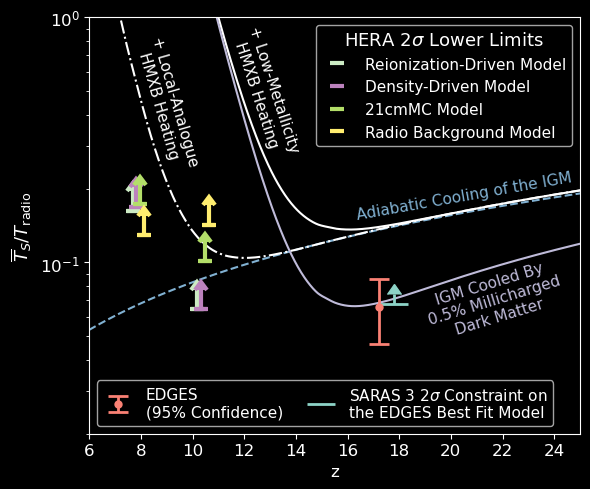

In [72]:
with plt.style.context('dark_background'):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']    
    plt.figure(figsize=(6,5), dpi=100)

    # HERA
    for z in [7.9, 10.4]:
        for i, data in enumerate([data_jtm, data_jbm, data_yq, data_sh]):
            color = [colors[8], colors[7], colors[6], colors[9]][i]
            if data == data_jtm:
                lim = data[z]['Ts_v3'][0] / (2.725 * (1 + z))
            else:
                lim = data[z]['Ts_v2'][0] / (2.725 * (1 + z))
            plt.plot(z + (-1.5 + i)*.15, lim, '_', c=color, ms=10, mew=3, label=(data['model_name'].replace('\n','') + ' Model' if z == 7.9 else None), zorder=20)
            print(z, data['model_name'], lim)
            plt.errorbar(z + (-1.5 + i)*.15, lim, yerr=lim/5, lolims=True, fmt='', lw=3, capsize=4,mew=3, c=color, zorder=20)

    # Plot Heating
    temps = pd.read_csv('temps_for_Josh.csv')
    zs = temps['z'].values



    plt.semilogy(zs, temps['Tad/Tcmb'], '--', color=colors[4])
    plt.semilogy(zs, np.where(temps['TkLX1/Tcmb'] > 0, temps['TkLX1/Tcmb'], np.nan), 'w-.')
    plt.semilogy(zs, np.where(temps['TkLX2/Tcmb'] > 0, temps['TkLX2/Tcmb'], np.nan), 'w')
    plt.semilogy(zs, np.where(temps['TkmQ+LX2/Tcmb'] > 0, temps['TkmQ+LX2/Tcmb'], np.nan), c=colors[2])
    # plt.semilogy(zs, with_heating, 'k--')

    leg1 = plt.legend(fontsize=11, title='HERA 2$\sigma$ Lower Limits', loc='upper right')
    plt.setp(leg1.get_title(),fontsize=13)

    # EDGES 
    EDGES_z = (1420 / 78) - 1
    EDGES_lims = np.array([0.0462387, 0.0852806])
    EDGES_best_fit = 0.0653538
    # p1, = plt.plot(EDGES_z, EDGES_2sigma_upper, '_', c='C3', ms=20, mew=3, label='EDGES 2$\sigma$\nLower Limit')
    # plt.errorbar(EDGES_z, EDGES_2sigma_upper, yerr=EDGES_2sigma_upper/10, uplims=True, capsize=5, lw=3, fmt='', c='C3')
    p1 = plt.errorbar(EDGES_z, np.mean(EDGES_lims, keepdims=True),  capsize=7, lw=2, fmt='.', ms=8, c=colors[3], mew=2, ls='',
                 yerr=[[EDGES_best_fit - EDGES_lims[0]], [EDGES_lims[1] - EDGES_best_fit]], label='EDGES\n(95% Confidence)')

    # SARAS
    SARAS_z = (1420 / 75.5) - 1
    SARAS_2sigma_lower = 0.067892
    p2, = plt.plot(SARAS_z, SARAS_2sigma_lower, '_', c=colors[0], ms=20, mew=2, label='SARAS 3 2$\sigma$ Constraint on\nthe EDGES Best Fit Model')
    plt.errorbar(SARAS_z, SARAS_2sigma_lower, c=colors[0], yerr=SARAS_2sigma_lower/10, lolims=True, capsize=5, lw=2, fmt='')

    plt.gca().add_artist(leg1)
    plt.legend(handles =[p1, p2], ncol=2, fontsize=11, loc='lower left', columnspacing=1.5)

    # TEXT
    plt.text(20.5, .15, 'Adiabatic Cooling of the IGM', fontsize=11, rotation=10, ha='center', color=colors[4])
    plt.text(9.0, .24, '+ Local-Analogue\nHMXB Heating', ha='center', fontsize=11, rotation=-74)
    plt.text(12.8, .27, '+ Low-Metallicity\nHMXB Heating', ha='center', fontsize=11, rotation=-72)

    plt.text(21.7, .048, 'IGM Cooled By\n0.5% Millicharged\nDark Matter', ha='center', fontsize=11, rotation=17, color=colors[2])

    plt.ylim(.02, 1)
    plt.xlim(6, 25)
    plt.xticks([6, 8, 10, 12, 14, 16, 18, 20, 22, 24])
    plt.xlabel('z', fontsize=12)
    plt.ylabel('$\\overline{T}_S / T_{{\\rm radio}}$', fontsize=13)
    plt.gca().tick_params(axis='both', labelsize=12)
    plt.tight_layout()
    plt.savefig('Ts_over_Trad_vs_z_idr2_dark.pdf', bbox_inches = "tight")

# HERA Stats Plots

In [73]:
uvp_xtk_dsq_1 = []
uvp_xtk_dsq_2 = []
for field in 'ABCDE':
    uvp = hera_pspec.UVPSpec()
    uvp.read_hdf5(f'../All_Epochs_Power_Spectra/results_files/Deltasq_Band_1_Field_{field}.h5')
    uvp_xtk_dsq_1.append(uvp)
    
    uvp = hera_pspec.UVPSpec()
    uvp.read_hdf5(f'../All_Epochs_Power_Spectra/results_files/Deltasq_Band_2_Field_{field}.h5')
    uvp_xtk_dsq_2.append(uvp)

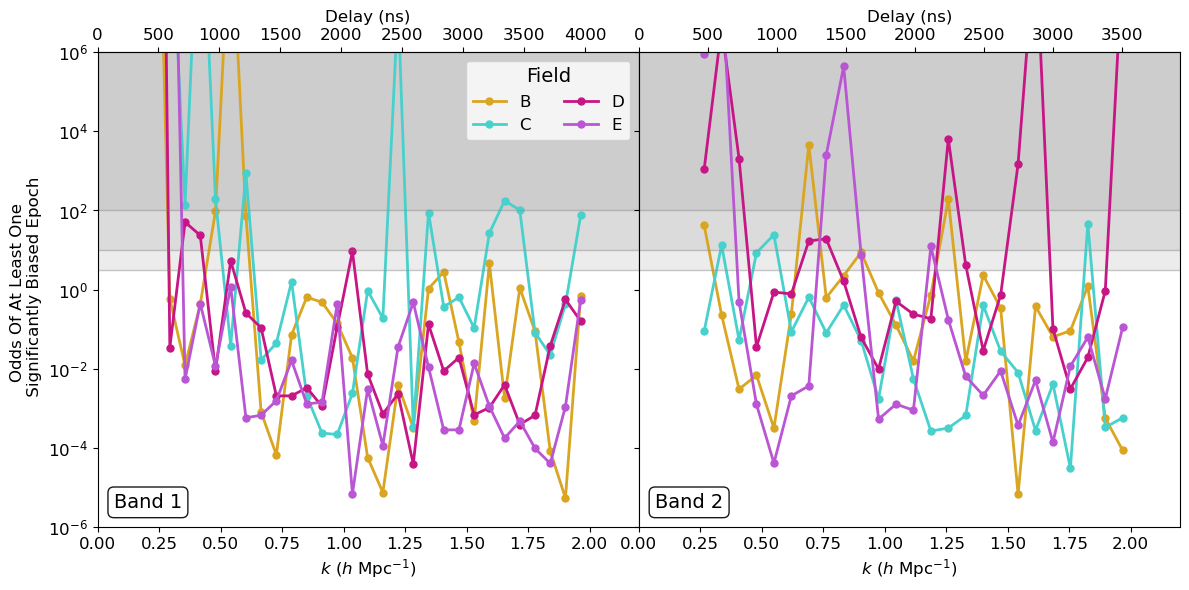

In [74]:
def two_jk_wrapper_IDR3(odds_dir="bias_jackknife", figsize=(16, 8), alpha=1, bands='12', xlim=[0.0, 2.2],
                        ylim=[1e-6, 1e6], ticklen=10, bandlabel_x=0.03, bandlabel_y=0.04, delin_alpha=0.3,
                        delin_wid=1, ylabel=f"Odds Of At Least One \n Significantly Biased Epoch",
                        xlabel=r'$k\ (h\ {\rm Mpc}^{-1}$)', marker='.', fontsize=12,
                        lst_colors=['goldenrod', 'mediumturquoise', 'mediumvioletred', 'mediumorchid'],
                        lw=2, fields='BCDE', dashz=-200, plot_z=True, line=True,
                        markersize=10, xwid=2, shade_alpha=0.15, dash=False, shade=True):
    
    fig, ax = plt.subplots(figsize=figsize, nrows=1, ncols=2, dpi=100, sharey=True, gridspec_kw={'wspace': 0})
    for plot_ind, band in enumerate(bands):
        for field_ind, field in enumerate(fields):
            ks, odds = np.load(f"{odds_dir}/jackknife_odds_band_{band}_field_{field}.npy")

            color = lst_colors[field_ind]
            if line:
                ax[plot_ind].plot(ks, odds, color=color, label=field, marker=marker, markersize=markersize,
                                  alpha=alpha, lw=lw)
            else:
                ax[plot_ind].scatter(ks, odds, color=color, label=field, marker=marker, alpha=alpha)

            if dash:
                ax[plot_ind].axhline(1, linestyle='--', color='black', zorder=dashz)
                ax[plot_ind].axhline(10, linestyle='--', color='red', zorder=dashz)

            ax[plot_ind].tick_params(labelsize=fontsize)

        ax[plot_ind].text(x=bandlabel_x, y=bandlabel_y, s = f"Band {band}", fontsize=fontsize+2,
                          transform=ax[plot_ind].transAxes, bbox=dict(facecolor='w', alpha=0.9, boxstyle='round'))
        ax[plot_ind].set_yscale("log")
        ax[plot_ind].set_ylim(ylim)
        ax[0].set_ylabel(ylabel, fontsize=fontsize)
        ax[plot_ind].set_xlim(xlim)
        if shade:
            for strength in [10**.5, 1e1, 1e2]:
                ax[plot_ind].axhspan(ymin=strength, ymax=1e10, alpha=shade_alpha, color="gray")
                ax[plot_ind].axhline(strength, alpha=delin_alpha, color="gray", lw=delin_wid)
            
        from scipy.interpolate import interp1d
        u = [uvp_xtk_dsq_1, uvp_xtk_dsq_2][plot_ind][0]
        kpara2dly = interp1d(u.get_kparas(0), u.get_dlys(0) * 1e9, fill_value='extrapolate')
        dly2kpara = interp1d(u.get_dlys(0) * 1e9, u.get_kparas(0), fill_value='extrapolate')
        secax =ax[plot_ind].secondary_xaxis('top', functions=(kpara2dly, dly2kpara))    
        secax.set_xlabel('Delay (ns)', fontsize=12)
        secax.tick_params(labelsize=12)
        
        ax[plot_ind].set_xlabel(xlabel, fontsize=fontsize)

    legend = ax[0].legend(fontsize=fontsize, frameon=True, ncol=2, loc="upper right", title='Field')
    plt.setp(legend.get_title(),fontsize=fontsize+2)
#     fig.tight_layout(h_pad=0)
    plt.tight_layout()
    fig.savefig("jackknife_two_panel.pdf", bbox_inches="tight")

two_jk_wrapper_IDR3(figsize=(12, 6), ticklen=5)

In [75]:
def plot_cumul_tavg_onlymean_test1(dlys, spectra, color='r', seed=None, dly_sign=None, title=None, ax=None, beta=1.,
                            alpha=0.2, ls=None, label=None): 
    
    """
    Plot cumulative averages of delay spectra in a redundant group, for a single delay 
    bin, averaged over time.
    """
    dly_min, dly_max = 3000., 3070.
    
    # Get shuffled indices
    idxs = np.arange(spectra.shape[0]) # Get indices for bl-pair axis
    if seed is not None:
        np.random.seed(seed)
        np.random.shuffle(idxs)
    
    if dly_sign == 'pos':
        dly_idx = np.where((dlys > dly_min) & (dlys < dly_max))[0][0]
    if dly_sign == 'neg':
        dly_idx = np.where((dlys < -dly_min) & (dlys > -dly_max))[0][0]
   
    # Do cumulative average
    spectra_blp_cumul = np.cumsum(spectra[idxs], axis=0) \
                  / np.cumsum(np.ones(spectra.shape[0]))[:,np.newaxis,np.newaxis]

    spectra_blp_cumul_tavg = np.mean((spectra_blp_cumul.real), axis=1)
    
    # Plot (abs) power spectrum cumul. average
    _ns = 1. + np.arange(spectra_blp_cumul.shape[0])
    
    std = beta / np.sqrt(_ns)
  
    zz = spectra_blp_cumul_tavg[:,dly_idx] / std
    ax.plot(_ns, zz, color=color, label=label, zorder=10, lw=1.5, alpha=alpha, ls=ls)
    
    ax.set_xlim((0., np.max(_ns)))
    
    ax.tick_params(axis='both', which='major', length=4., labelsize=12)
    ax.tick_params(axis='both', which='minor', length=2., labelsize=12)
    ax.tick_params(axis='x', direction='in')

    return ax, zz

In [76]:
# Data file:
# uvp_xtk: /lustre/aoc/projects/hera/H1C_IDR3/IDR3_2/LSTBIN/all_epochs_preprocessed/pspec/pspec.grp1.of1.LPXLTK.h5
# Data generated by Allan_variance_All_Epoch_noise_data.ipynb on 2022-06-09 (Phil Bull)

# Load data from numpy pickle file
# data_dict = np.load("noise_integ_3070ns_data_dict.npy", allow_pickle=True)

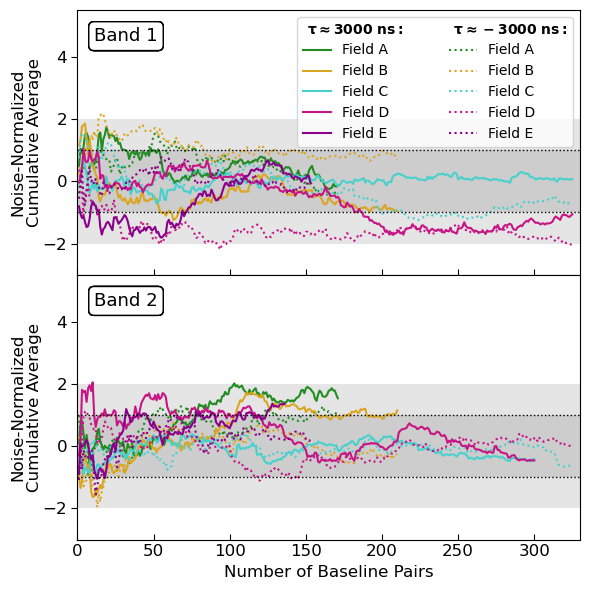

In [77]:
# Flagging and field lists
spw_list = [0, 1]
field_list = [0, 1, 2, 3, 4]
field_name = ['A', 'B', 'C', 'D', 'E']
lst_colors = ['limegreen', 'gold', 'cyan', 'deeppink', 'mediumorchid', 'aquamarine']
lst_colors = ['forestgreen', 'goldenrod', 'mediumturquoise', 'mediumvioletred', 'darkmagenta', 'lightseagreen']
band_ls = ['solid', 'dashed']

seed = 1
fig, ax = plt.subplots(2, 1, figsize=(6, 6), dpi=100, sharex=True, sharey=True, gridspec_kw={'hspace': 0})

# Confidence regions
for i in [0, 1]:
    ax[i].axhspan(-2., 2., facecolor='k', alpha=0.1)
    ax[i].axhspan(-1., 1., facecolor='k', alpha=0.1)

# Load data from numpy pickle file
data_dict = np.load("noise_integ_3070ns_data_dict.npy", allow_pickle=True)
    
# Loop over spws and fields
for fld in field_list:
    for spw in spw_list:

        
        # Extract data from dict
        dd = data_dict.item().get((spw, fld))

        # Plot data
        _ax, zz = plot_cumul_tavg_onlymean_test1(dd['dlys_p'], 
                                                 dd['spectra_pos'], 
                                                 seed=seed, 
                                                 dly_sign='pos', 
                                                 color=lst_colors[fld], 
                                                 ax=ax[spw], 
                                                 ls='solid',
                                                 alpha=1., 
                                                 label=("Field %s" % field_name[fld] if spw == 0 else None),
                                                 beta=dd['beta_pos'])
        _ax, zz = plot_cumul_tavg_onlymean_test1(dd['dlys_n'], 
                                                 dd['spectra_neg'], 
                                                 seed=seed, 
                                                 dly_sign='neg', 
                                                 color=lst_colors[fld], 
                                                 ax=ax[spw], 
                                                 ls=':',
                                                 alpha=1.,
                                                 label=("Field %s" % field_name[fld] if spw == 0 else None),
                                                 beta=dd['beta_neg'])
        ax[spw].text(11, 4.95, f'Band {spw+1}', va='top', ha='left', fontsize=13,
                     bbox=dict(facecolor='w', alpha=1, boxstyle='round'), )
        

for spw in [0, 1]:
    ax[spw].set_xlim((0., 330.))
    ax[spw].set_ylim((-3, 5.5))
    
    xmin,xmax = ax[spw].get_xlim()
    ax[spw].hlines(1., xmin, xmax, ls='dotted', linewidth=1., color='k', zorder=20)
    ax[spw].hlines(-1., xmin, xmax, ls='dotted', linewidth=1., color='k', zorder=20)

    ax[spw].set_ylabel("Noise-Normalized\nCumulative Average", size=12, labelpad=0)
ax[1].set_xlabel('Number of Baseline Pairs', fontsize=12)


h, l = ax[0].get_legend_handles_labels()
ph = [ax[0].plot([],marker="", ls="")[0]]*2
handles = ph[:1] + h[::2] + ph[1:] + h[1::2]
labels = ["$\\mathbf{\\tau \\approx 3000{\\rm\\bf ~ns:}}$    "] + l[::2] + ["$\\hspace{-2}\\mathbf{\\tau \\approx -3000{\\rm\\bf ~ns:}}$"] + l[1::2]
leg = ax[0].legend(handles, labels, ncol=2, fontsize=10)
for vpack in leg._legend_handle_box.get_children():
    for hpack in vpack.get_children()[:1]:
        hpack.get_children()[0].set_width(-5)

# leg0 = ax[0].legend(loc='upper right', title='$\\tau \\approx 3000$ ns:', fontsize=10, ncol=6)



# leg1 = ax[1].legend(loc='upper right', title='$\\tau \\approx -3000$ ns:', fontsize=10, ncol=1)
# for leg in [leg0, leg1]:
#     leg.set_zorder(200)
#     plt.setp(leg.get_title(),fontsize=12)

#fig.suptitle(r'All Epochs, 28m 0$^\circ$ baseline group')
plt.tight_layout()
plt.savefig("noise_integ_allepoch_3070ns.pdf", bbox_inches="tight")

FixedFormatter should only be used together with FixedLocator


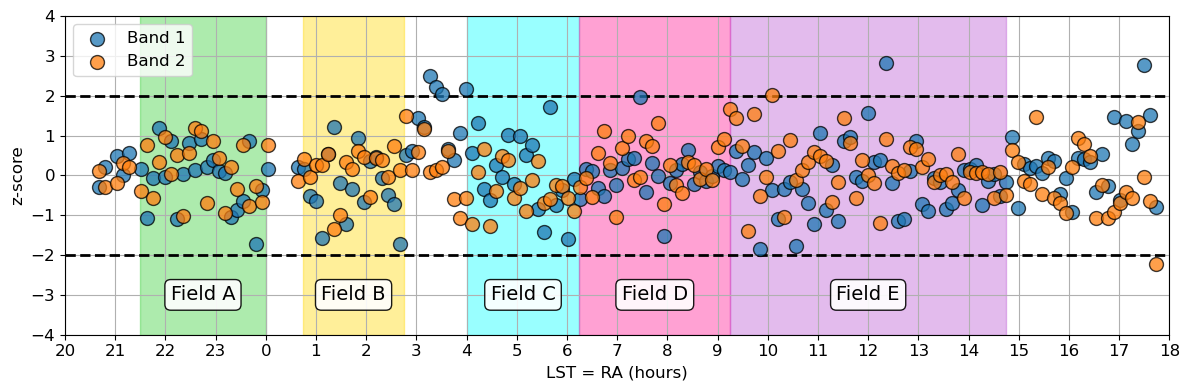

In [78]:
f = h5py.File(f"LST_null_test_nb.h5", 'r')

# LST ranges of fields
lstcuts = [(-2.5, 0), # Field A
           (0.75, 2.75), # Field B
           (4, 6.25), # Field C
           (6.25, 9.25), # Field D
           (9.25, 14.75),  # Field E
          ]

lst_colors = ['limegreen', 'gold', 'cyan', 'deeppink', 'mediumorchid', 'aquamarine']

fig, ax = plt.subplots(1, 1, figsize=(12, 4), dpi=100)
ax.grid()

for field, (lc, c) in enumerate(zip(lstcuts, lst_colors)):
    ax.axvspan(lc[0], lc[1], color=c, alpha=0.4)
    ax.text(np.mean(lc), -3, f'Field {"ABCDEFGHIJ"[field]}', ha='center', va='center', fontsize=14, bbox=dict(facecolor='w', alpha=0.9, boxstyle='round'))


for val in range(2):

    key = str(val)
    
    LST = f[key]['ilst']
    z_score = f[key]['z_score']


    for vv, ilst in enumerate(LST):

        if np.isnan(z_score[vv]):
            continue

        if ilst>=18:
            ilst = ilst-24

        ax.scatter(ilst, z_score[vv], s=100, ec='k', c=f'C{val}', alpha=0.75, label=(f'Band {val+1}' if vv==0 else None), zorder=100)
        
ax.axhline(2, ls='--', c='k', lw=2)
ax.axhline(-2, ls='--', c='k', lw=2)
ax.set_xticklabels(np.arange(-6, 20, 1) % 24)
ax.set_xticks(np.arange(-6, 20, 1))
ax.set_ylim([-4,4])
ax.tick_params(labelsize=12)
ax.set_xlabel("LST = RA (hours)", fontsize=12)
ax.set_ylabel("z-score", fontsize=12)

ax.set_xlim([-4,18])
ax.legend(fontsize=12, loc='upper left')    
fig.tight_layout()
plt.savefig("LST_z_score.pdf", bbox_inches="tight")

f.close()

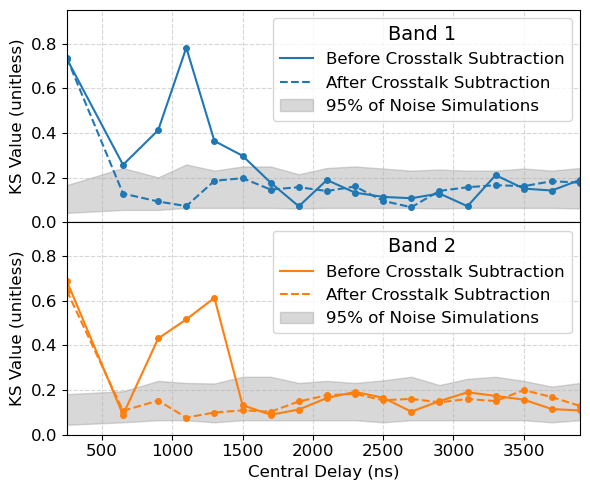

In [79]:
f2 = h5py.File("systematic_delay_v2.h5", 'r')

fig, ax = plt.subplots(2,1,figsize=(6,5), dpi=100, sharex=True, gridspec_kw={'hspace': 0})

for i in range(2):
    dlys = f2[str(i)]['delay'][()]
    ax[i].plot(dlys, f2[str(i)]['KS_pre_sys'][()], c=f'C{i}',
               ls='-', label=f'Before Crosstalk Subtraction')
    ax[i].plot(dlys, f2[str(i)]['KS_pre_sys'][()],'.', ms=8, c=f'C{i}')
    
    ax[i].plot(dlys, f2[str(i)]['KS_post_sys'][()], c=f'C{i}',
               ls='--', label=f'After Crosstalk Subtraction')
    ax[i].plot(dlys, f2[str(i)]['KS_post_sys'][()],'.', ms=8, c=f'C{i}')
    ax[i].fill_between(f2[str(i)]['delay'][()], f2[str(i)]['sigma_low'][()], f2[str(i)]['sigma_high'][()], 
                    alpha=0.3, color='gray', label='95% of Noise Simulations')

    ax[i].grid(ls='--', alpha=0.5)
    ax[i].legend(fontsize=12, title=f'Band {i+1}', title_fontsize=14)
    ax[i].set_ylabel("KS Value (unitless)", fontsize=12)
    ax[i].set_ylim([0,0.95])
    ax[i].set_xlim([250, 3900])
    ax[i].tick_params(labelsize=12)    
ax[1].set_xlabel("Central Delay (ns)", fontsize=12)
    
plt.tight_layout()
plt.savefig("KS_delays.pdf", bbox_inches="tight")

f2.close()

In [80]:
band1_dfs = sorted(glob.glob('../All_Epochs_Power_Spectra/results_files/Pofk*Band_1*'))
band2_dfs = sorted(glob.glob('../All_Epochs_Power_Spectra/results_files/Pofk*Band_2*'))
band1_uvps, band2_uvps = [], []
fields = ['A', 'B', 'C', 'D', 'E']
for b1_df, b2_df in zip(band1_dfs, band2_dfs):
    uvp = hera_pspec.UVPSpec()
    uvp.read_hdf5(b1_df)
    band1_uvps.append(uvp)
    uvp = hera_pspec.UVPSpec()
    uvp.read_hdf5(b2_df)
    band2_uvps.append(uvp)
all_uvps = [band1_uvps, band2_uvps]

import sys
import imp
sys.path.insert(1, "../../")
import utils
imp.reload(utils);

In [81]:
# likelihood tests: Monte Carlo chisq for each covariance, with different k cuts
N = 300000
n_x2 = {}
pvals_real,  pvals_imag, pvals_min = {}, {}, {}
k_cuts = [0.23, 0.5, 1.0]
for k, kc in enumerate(k_cuts):
    n_x2[k] = {}
    pvals_real[k], pvals_imag[k] = [], []
    for i in range(2):
        print("working on band {}".format(i+1))
        n_x2[k][i] = {}
        uvps = all_uvps[i]
        kp = uvps[0].get_kparas(0)
        ks = slice(np.argmax(kp > kc), None)
        pv_real, pv_imag = [], []
        for j in range(5):
            uvp = all_uvps[i][j]
            # get P_SN covariance
            cov_SN = uvp.cov_array_real[0].squeeze()[ks, ks]
            # normalize, and re-scale by P_N
            s = np.diag(1/np.sqrt(cov_SN.diagonal()))
            cov_N = s @ cov_SN @ s
            s = np.diag(uvp.stats_array['P_N'][0].squeeze()[ks].real)
            cov_N = s @ cov_N @ s
            n_x2[k][i][j] = utils.monte_carlo_chisq(cov_N, len(cov_N), N=N)
            patches = np.histogram(n_x2[k][i][j], bins=100)
            y = uvp.data_array[0].squeeze()[ks]
            pval_real = utils.p_value(y.real, cov_N, n_x2=n_x2[k][i][j])[1]
            pval_imag = utils.p_value(y.imag, cov_N, n_x2=n_x2[k][i][j])[1]
            # compute minimum p-value testable by N sims
            y, x = np.histogram(n_x2[k][i][j], bins=200)
            y = np.concatenate([[0], y])
            index = np.argmax((x > x.mean()) & (np.abs(y - 20) < 5))
            exceed = n_x2[k][i][j] > x[index]
            pval_min = sum(exceed) / exceed.size
            if pval_real < pval_min:
                pval_real = "< {:.3f}".format(pval_min)
            else:
                pval_real = "{:.3f}".format(pval_real)
            if pval_imag < pval_min:
                pval_imag = "< {:.3f}".format(pval_min)
            else:
                pval_imag = "{:.3f}".format(pval_imag)
            pv_real.append(pval_real)
            pv_imag.append(pval_imag)
        pvals_real[k].append(pv_real)
        pvals_imag[k].append(pv_imag)

working on band 1
working on band 2
working on band 1
working on band 2
working on band 1
working on band 2


In [82]:
outstr = ''
for spw in [0, 1]:
    for f, field in enumerate('ABCDE'):
        if f > 0: 
            outstr += '\\midrule\n'
        else:
            outstr += '\\toprule\n'
        for pvals, func in zip([pvals_real, pvals_imag], ['Re', 'Im']):
            outstr += f'{func}[$\\Delta^2$], Band {spw+1}, Field {field} & '            
            for i in range(3):
                if '<' in pvals[i][spw][f]:
                    outstr += '\\textbf{$<$0.001} '
                elif float(pvals[i][spw][f]) < .01:
                    outstr += '\\textbf{' + f'{pvals[i][spw][f]:.5}' + '} '
                else:
                    outstr += f'{pvals[i][spw][f]:.5}' + ' '
                if i < 2:
                    outstr += '& '
            outstr += '\\\\\n'
print(outstr)

\toprule
Re[$\Delta^2$], Band 1, Field A & \textbf{$<$0.001} & 0.378 & 0.464 \\
Im[$\Delta^2$], Band 1, Field A & \textbf{$<$0.001} & 0.052 & 0.089 \\
\midrule
Re[$\Delta^2$], Band 1, Field B & \textbf{$<$0.001} & 0.015 & 0.730 \\
Im[$\Delta^2$], Band 1, Field B & 0.773 & 0.633 & 0.844 \\
\midrule
Re[$\Delta^2$], Band 1, Field C & \textbf{$<$0.001} & 0.016 & 0.050 \\
Im[$\Delta^2$], Band 1, Field C & 0.182 & 0.790 & 0.859 \\
\midrule
Re[$\Delta^2$], Band 1, Field D & \textbf{$<$0.001} & 0.015 & 0.024 \\
Im[$\Delta^2$], Band 1, Field D & 0.810 & 0.925 & 0.686 \\
\midrule
Re[$\Delta^2$], Band 1, Field E & \textbf{$<$0.001} & 0.745 & 0.939 \\
Im[$\Delta^2$], Band 1, Field E & 0.343 & 0.686 & 0.506 \\
\toprule
Re[$\Delta^2$], Band 2, Field A & \textbf{$<$0.001} & 0.182 & 0.124 \\
Im[$\Delta^2$], Band 2, Field A & 0.262 & 0.320 & 0.144 \\
\midrule
Re[$\Delta^2$], Band 2, Field B & 0.077 & 0.385 & 0.654 \\
Im[$\Delta^2$], Band 2, Field B & 0.499 & 0.398 & 0.356 \\
\midrule
Re[$\Delta^2$], Ba